In [1]:
#%pip install --upgrade pip
#%pip uninstall torch torchvision torchaudio -y

In [2]:
#%pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
#%pip install scikit-learn
#%pip install ultralytics opencv-python 
#%pip install pandas matplotlib seaborn
#%pip install ipywidgets
#%pip install optuna
#%pip install plotly
#%pip install kaleido
#%pip install bokeh 

In [3]:
#%pip install --upgrade numpy
#%pip install numpy==1.26.4
#%pip install --upgrade jupyter ipywidgets
#%pip install -U ultralytics
#%pip install --upgrade albumentations


In [4]:
import os
#os.environ['YOLO_VERBOSE'] = 'False'

In [5]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from sklearn.model_selection import train_test_split # Para dividir datos
import random
from tqdm.notebook import tqdm # Barra de progreso
import torchvision
import optuna
import plotly.graph_objects as go
import optuna.visualization as vis

In [6]:
# Verificacion de GPU 
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

PyTorch version: 2.7.0+cu128
CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


## 1 : EDA

In [7]:
# Ruta al archivo CSV con las anotaciones
csv_file_path = 'train.csv' 

# Ruta al directorio de imágenes
image_dir = './images/' 

df_annots = pd.read_csv(csv_file_path, delimiter=',')

In [8]:
df_annots.head()

filename    class  xmin  ymin  xmax  ymax  object_count
0  image_00373.jpeg   cougar   506   303   628   414             1
1  image_00065.jpeg  seahawk   381    35   856   273             1
2  image_00111.jpeg   cougar   467   136   830   302             1
3  image_00112.jpeg   cougar   447   122   799   287             1
4  image_00113.jpeg   cougar   418   141   631   291             1

In [9]:
df_annots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      189 non-null    object
 1   class         189 non-null    object
 2   xmin          189 non-null    int64 
 3   ymin          189 non-null    int64 
 4   xmax          189 non-null    int64 
 5   ymax          189 non-null    int64 
 6   object_count  189 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 10.5+ KB


In [10]:
print(f"\nNúmero total de anotaciones: {len(df_annots)}")
print(f"Número de imágenes únicas: {df_annots['filename'].nunique()}")
print(f"\nClases presentes: {df_annots['class'].unique()}")
print(f"\nNúmero de anotaciones por clase:")
print(df_annots['class'].value_counts())


Número total de anotaciones: 189
Número de imágenes únicas: 189

Clases presentes: ['cougar' 'seahawk' 'ah64' 'f16' 'f15' 'chinook']

Número de anotaciones por clase:
class
f16        41
cougar     37
chinook    35
ah64       34
f15        23
seahawk    19
Name: count, dtype: int64


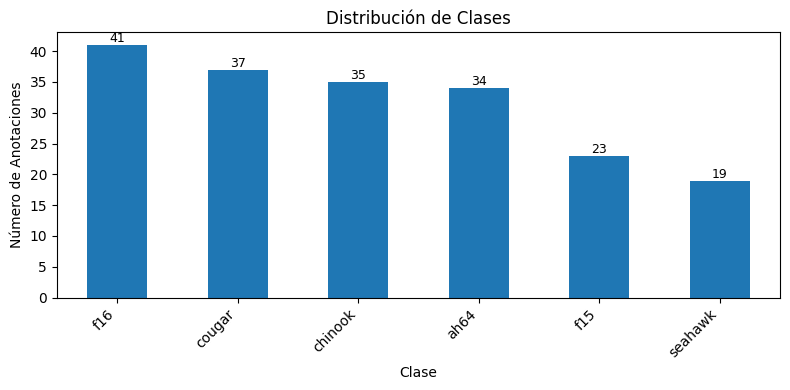

In [11]:
# Crear el gráfico de barras
class_counts = df_annots['class'].value_counts()
ax = class_counts.plot(kind='bar', figsize=(8, 4))
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Anotaciones')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Añadir las cantidades encima de cada barra
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

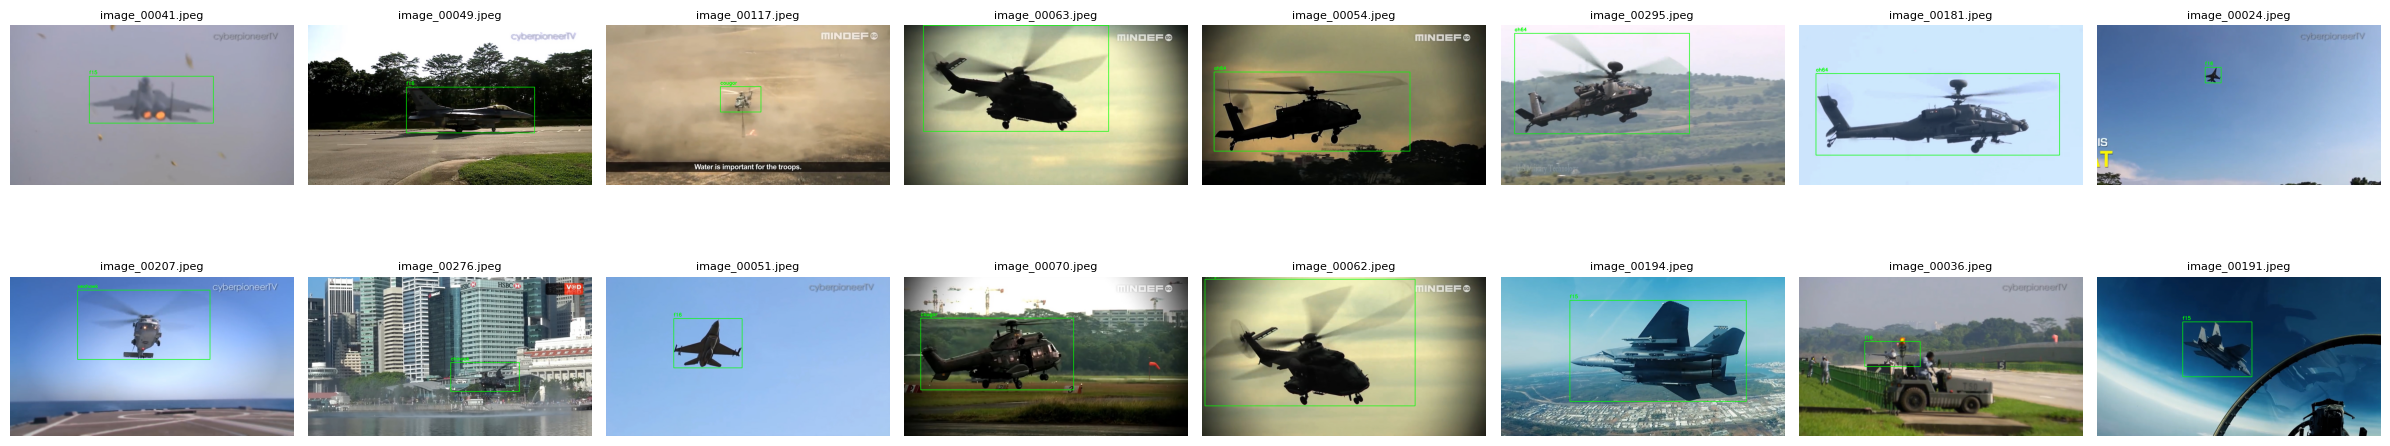

In [12]:
# Función para visualizar una imagen con sus bounding boxes
def display_image_with_boxes(image_filename, df_annotations, img_directory):
    """Muestra una imagen con sus recuadros delimitadores y etiquetas."""
    img_path = os.path.join(img_directory, image_filename)
    if not os.path.exists(img_path):
        print(f"Error: Imagen no encontrada en {img_path}")
        return

    # Leer la imagen
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error al leer la imagen {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convertir a RGB para Matplotlib

    # Obtener las anotaciones para esta imagen
    img_annots = df_annotations[df_annotations['filename'] == image_filename]

    if img_annots.empty:
        print(f"No hay anotaciones para {image_filename}")
    else:
        # Dibujar cada bounding box
        for _, row in img_annots.iterrows():
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            label = row['class']
            # Dibujar rectángulo (verde, grosor 2)
            cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            # Poner etiqueta
            cv2.putText(img_rgb, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Mostrar la imagen
    return img_rgb


# Visualizar una imagen de ejemplo (si el CSV se cargó)
if 'df_annots' in locals() and not df_annots.empty:
    # Seleccionar aleatoriamente 16 nombres de archivo únicos
    num_images = min(16, df_annots['filename'].nunique())  # No exceder el número total de imágenes
    sample_filenames = random.sample(list(df_annots['filename'].unique()), num_images)

    # Crear una figura con subplots
    fig, axes = plt.subplots(2, 8, figsize=(24, 6))  # 2 filas, 8 columnas
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

    # Iterar sobre los nombres de archivo seleccionados y mostrar las imágenes en los subplots
    for i, filename in enumerate(sample_filenames):
        img = display_image_with_boxes(filename, df_annots, image_dir)
        if img is not None:
            axes[i].imshow(img)
            axes[i].set_title(filename, fontsize=8)
            axes[i].axis('off')
        else:
            # Si la imagen no se puede mostrar, ocultar el subplot
            axes[i].axis('off')
            axes[i].text(0.5, 0.5, "Error", ha='center', va='center', color='red')

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    plt.show()
else:
    print("\nNo se pueden mostrar ejemplos porque el DataFrame no se cargó o está vacío.")

In [13]:
# --- 1. Crear mapeo de clases a índices ---
if 'df_annots' in locals() and not df_annots.empty:
    class_names = sorted(df_annots['class'].unique())
    class_to_id = {name: i for i, name in enumerate(class_names)}
    id_to_class = {i: name for name, i in class_to_id.items()}
    num_classes = len(class_names)
    print(f"Mapeo de clases: {class_to_id}")
    print(f"Número de clases: {num_classes}")
else:
    print("DataFrame no disponible. No se puede crear el mapeo de clases.")
    # Salir o manejar el error apropiadamente si df_annots no existe

Mapeo de clases: {'ah64': 0, 'chinook': 1, 'cougar': 2, 'f15': 3, 'f16': 4, 'seahawk': 5}
Número de clases: 6


## 2 : Preparación de los datos

In [14]:
# --- 2. Definir estructura de directorios para YOLO ---
dataset_base_dir = './yolo_dataset'
images_base_dir = os.path.join(dataset_base_dir, 'images')
labels_base_dir = os.path.join(dataset_base_dir, 'labels')

# Crear directorios para train y val
for split in ['train', 'val']:
    os.makedirs(os.path.join(images_base_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_base_dir, split), exist_ok=True)

print(f"Directorios creados en: {dataset_base_dir}")

Directorios creados en: ./yolo_dataset


In [15]:
# --- 3. Dividir datos en Entrenamiento y Validación ---
if 'df_annots' in locals() and not df_annots.empty:
    all_filenames = df_annots['filename'].unique()
    # Dividir la *lista de nombres de archivo*, no las anotaciones directamente
    # Usar stratify si tienes desbalance de imágenes por clase (más complejo)
    train_filenames, val_filenames = train_test_split(
        all_filenames,
        test_size=0.2, # 20% para validación
        stratify=df_annots['class'], # estratificar por clase
        random_state=42 # Para reproducibilidad
    )
    print(f"Total imágenes: {len(all_filenames)}")
    print(f"Imágenes de entrenamiento: {len(train_filenames)}")
    print(f"Imágenes de validación: {len(val_filenames)}")

    # --- 4. Convertir anotaciones y copiar archivos ---
    def process_annotations(filenames, df_all_annots, source_img_dir, target_img_dir, target_label_dir, class_mapping):
        """Convierte anotaciones a formato YOLO .txt y copia imágenes."""
        img_not_found_count = 0
        for filename in filenames:
            source_img_path = os.path.join(source_img_dir, filename)
            target_img_path = os.path.join(target_img_dir, filename)
            target_label_path = os.path.join(target_label_dir, os.path.splitext(filename)[0] + '.txt')

            if not os.path.exists(source_img_path):
                print(f"¡Advertencia! Imagen no encontrada: {source_img_path}. Saltando.")
                img_not_found_count += 1
                continue

            # Copiar archivo de imagen
            try:
                # Podrías usar shutil.copy, pero leer/escribir es más explícito
                img = cv2.imread(source_img_path)
                if img is None:
                    print(f"¡Advertencia! No se pudo leer la imagen: {source_img_path}. Saltando.")
                    img_not_found_count += 1
                    continue
                cv2.imwrite(target_img_path, img)
                img_h, img_w = img.shape[:2]
            except Exception as e:
                 print(f"¡Error! Al procesar la imagen {source_img_path}: {e}. Saltando.")
                 img_not_found_count += 1
                 continue


            # Obtener anotaciones para esta imagen
            img_annots = df_all_annots[df_all_annots['filename'] == filename]
            yolo_labels = []

            for _, row in img_annots.iterrows():
                class_name = row['class']
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

                # Convertir a formato YOLO
                class_id = class_mapping[class_name]
                box_w = xmax - xmin
                box_h = ymax - ymin
                center_x = xmin + box_w / 2
                center_y = ymin + box_h / 2

                # Normalizar
                norm_center_x = center_x / img_w
                norm_center_y = center_y / img_h
                norm_w = box_w / img_w
                norm_h = box_h / img_h

                # Validar coordenadas normalizadas (deben estar entre 0 y 1)
                coords = [norm_center_x, norm_center_y, norm_w, norm_h]
                if not all(0.0 <= c <= 1.0 for c in coords):
                   print(f"¡Advertencia! Coordenadas normalizadas inválidas para {filename} en box [{xmin},{ymin},{xmax},{ymax}]: {coords}. Saltando esta anotación.")
                   continue # Saltar esta anotación específica


                yolo_labels.append(f"{class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_w:.6f} {norm_h:.6f}")

            # Guardar archivo .txt de etiquetas (incluso si está vacío, YOLO lo necesita)
            with open(target_label_path, 'w') as f:
                f.write("\n".join(yolo_labels))

        if img_not_found_count > 0:
             print(f"Total de imágenes no encontradas o con error: {img_not_found_count}")


    # Procesar para el conjunto de entrenamiento
    print("\nProcesando datos de entrenamiento...")
    process_annotations(
        train_filenames, df_annots, image_dir,
        os.path.join(images_base_dir, 'train'),
        os.path.join(labels_base_dir, 'train'),
        class_to_id
    )

    # Procesar para el conjunto de validación
    print("\nProcesando datos de validación...")
    process_annotations(
        val_filenames, df_annots, image_dir,
        os.path.join(images_base_dir, 'val'),
        os.path.join(labels_base_dir, 'val'),
        class_to_id
    )

    print("\n¡Preprocesamiento completado!")

else:
    print("\nNo se puede continuar con el preprocesamiento, el DataFrame no está cargado.")

Total imágenes: 189
Imágenes de entrenamiento: 151
Imágenes de validación: 38

Procesando datos de entrenamiento...

Procesando datos de validación...

¡Preprocesamiento completado!


## 3 : Configuracion YOLO

In [16]:
# Cargar un modelo YOLOv8 pre-entrenado (ej. yolov8n)
# 'n' es por nano, el más pequeño. Puedes probar 's', 'm', 'l', 'x' para modelos más grandes.
model = YOLO('yolo11n.pt') # Descargará los pesos si no los tienes localmente

# Cargar un modelo desde cero (menos recomendable para empezar)
# model = YOLO('yolov8n.yaml') # Construye desde la configuración YAML

# Cargar un modelo pre-entrenado y adaptarlo explícitamente (normalmente no es necesario)
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')

print("Modelo YOLO cargado.")
print(f"Tipo de modelo: {type(model)}")
# La adaptación de la capa de salida ocurre AUTOMÁTICAMENTE durante el .train()
# basado en el 'nc' (número de clases) de tu archivo data.yaml.

Modelo YOLO cargado.
Tipo de modelo: <class 'ultralytics.models.yolo.model.YOLO'>


In [17]:
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

PyTorch version: 2.7.0+cu128
TorchVision version: 0.22.0+cu128
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4060 Laptop GPU


## 4 : Optimizacion OPTUNA

In [18]:
# Asumiendo que 'model' ya está cargado (e.g., model = torch.hub.load('ultralytics/yolov8', 'yolov8s'))
# y que 'dataset_base_dir' está definido

# Ruta al archivo data.yaml
dataset_base_dir = 'yolo_dataset' # Reemplaza con la ruta real
data_yaml_path = os.path.join(dataset_base_dir, 'data.yaml')

# Asegúrate de que data.yaml existe
if not os.path.exists(data_yaml_path):
    raise FileNotFoundError(f"El archivo {data_yaml_path} no existe.")

def objective(trial):
    """Función objetivo para Optuna. Define los hiperparámetros a optimizar y el entrenamiento."""

    # Hiperparámetros a optimizar
    # lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    # batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    # optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "AdamW"])
    # epochs = trial.suggest_int("epochs", 50, 200)
    # imgsz = trial.suggest_categorical("image_size", [320, 416, 640])

    #lr = trial.suggest_float("learning_rate", 0.0001, 0.001, log=True) #trial.suggest_float("learning_rate", 0.00011, 0.00016, log=True)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16,32,64])
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "AdamW"])    
    epochs = trial.suggest_int("epochs", 200, 300)
    
    image_sizes = list(range(320, 737, 32))
    imgsz = trial.suggest_categorical("image_size", image_sizes)

    print(f"\n--- Trial {trial.number} ---")
    print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Optimizer: {optimizer_name}, Epochs: {epochs}, Image Size: {imgsz}")

    # Redirigir la salida estándar a un archivo
    # file_name = f"training_trial_{trial.number}.log"
    # log_file = open(file_name, "w")
    # sys.stdout = log_file
    # sys.stderr = log_file # También redirigir la salida de errores

    # Entrenar el modelo con los hiperparámetros sugeridos
    try:
        results = model.train(
            data=data_yaml_path,
            epochs=epochs,
            imgsz=imgsz,
            augment=True,
            #mode='train',
            batch=batch_size,
            project='optuna_runs',  # Carpeta para las ejecuciones de Optuna
            name=f'trial_{trial.number}',
            exist_ok=True,
            optimizer=optimizer_name,
            lr0=lr,
            device=0  #if torch.cuda.is_available() else 'cpu',
            #verbose=False  # Para evitar la salida detallada durante cada trial
        )
        # Restaurar la salida estándar y cerrar el archivo de registro
        # sys.stdout = sys.__stdout__
        # sys.stderr = sys.__stderr__
        # log_file.close()

        # print(f"  mAP50-95 (Box): {results.box.map:.4f}")
        # print(f"  mAP50 (Box):    {results.box.map50:.4f}")
        # print(f"  mAP75 (Box):    {results.box.map75:.4f}")
        # Optuna necesita una métrica para optimizar. Aquí usamos el mAP50-95 (media Average Precision)
        # Puedes ajustar esto a la métrica que consideres más importante.
        #best_map = results.best[6] if results and results.best else 0.0
        #best_loss = results.best[0] if results and results.best else 0.0
        #best_map = results.metrics["metrics/mAP50(B)"]
        best_map = results.box.map
        print(f"Trial {trial.number} - mAP50-95: {results.box.map} - map50: {results.box.map50} - map75: {results.box.map75}")

        return best_map #best_map  # Devolver la métrica de interés para Optuna

    except Exception as e:
        print(f"Error durante el entrenamiento del trial {trial.number}: {e}")
        return 0.0  # Devolver un valor para que Optuna pueda continuar

## 4.1 : Optuna trials

In [19]:
# Crear un estudio de Optuna
study = optuna.create_study(direction="maximize",study_name="optuna_study")  # Queremos maximizar la métrica (e.g., mAP)

# Ejecutar la optimización
study.optimize(objective, n_trials=300)  # Define el número de trials (pruebas) que quieres ejecutar


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/251      1.78G     0.3263     0.2684     0.8352         38        384: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         38         38      0.915      0.735      0.852       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/251      1.78G     0.3522     0.2887     0.8582         49        384: 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]

                   all         38         38      0.925      0.733      0.847      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/251      1.78G     0.3678     0.3026     0.8509         62        384: 100%|██████████| 5/5 [00:00<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         38         38      0.924      0.737      0.836      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/251      1.78G     0.3202     0.2957     0.8403         48        384: 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


                   all         38         38      0.922      0.737      0.837      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/251      1.78G     0.3485     0.2898     0.8414         38        384: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         38         38      0.847      0.777      0.831      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/251      1.78G     0.3623     0.2714     0.8588         57        384: 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         38         38      0.848      0.776      0.831      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/251      1.78G     0.3327     0.2624     0.8284         45        384: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         38         38      0.904      0.743      0.841       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/251      1.78G      0.366     0.3003     0.8509         39        384: 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]

                   all         38         38      0.915       0.74      0.851      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/251      1.78G     0.3729     0.2907     0.8532         55        384: 100%|██████████| 5/5 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         38         38      0.844      0.777      0.844      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/251      1.78G     0.3094     0.2506     0.8372         42        384: 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

                   all         38         38      0.843      0.776      0.844      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/251      1.78G     0.3395     0.2676     0.8367         57        384: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all         38         38      0.842      0.776      0.847      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/251      1.78G     0.3388     0.2495     0.8275         46        384: 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         38         38       0.84      0.777      0.849      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/251      1.78G     0.3596      0.281     0.8452         50        384: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]

                   all         38         38       0.91      0.735      0.861      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/251      1.78G     0.3328     0.2614      0.848         50        384: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         38         38      0.839      0.816      0.878      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/251      1.78G     0.3337     0.2587     0.8427         47        384: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all         38         38      0.907      0.737      0.864      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/251      1.78G     0.3534     0.2769     0.8338         62        384: 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

                   all         38         38      0.837      0.786      0.862      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/251      1.78G      0.362     0.2805     0.8367         56        384: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.828       0.79      0.825      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/251      1.78G     0.3563     0.2747     0.8472         49        384: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         38         38      0.835      0.788      0.828      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/251      1.78G     0.3575     0.2865     0.8497         52        384: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         38         38      0.882      0.748      0.831      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/251      1.78G     0.3356     0.2599     0.8393         54        384: 100%|██████████| 5/5 [00:00<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


                   all         38         38      0.898       0.75       0.84      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/251      1.78G     0.3047     0.2548      0.846         45        384: 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         38         38      0.925      0.736      0.865      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/251      1.78G     0.3229     0.2541      0.839         52        384: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         38         38       0.84       0.82      0.873      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/251      1.78G     0.3458     0.2563     0.8425         53        384: 100%|██████████| 5/5 [00:00<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         38         38      0.866      0.805      0.874      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/251      1.78G      0.325     0.2617     0.8462         51        384: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         38         38      0.867       0.81      0.865      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/251      1.78G     0.3193     0.2573      0.833         57        384: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         38         38      0.916      0.737      0.845       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/251      1.78G      0.337     0.2827     0.8507         60        384: 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         38         38      0.915      0.742      0.829      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/251      1.78G     0.3385     0.2701     0.8489         49        384: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         38         38      0.901       0.75      0.833      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/251      1.78G      0.353     0.2828     0.8599         55        384: 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         38         38      0.897      0.754      0.852      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/251      1.78G     0.3422     0.2614     0.8454         59        384: 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         38         38      0.929      0.735      0.862      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/251      1.78G     0.3335     0.2639     0.8467         43        384: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         38         38      0.884      0.797      0.875      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/251      1.78G     0.3332     0.2741     0.8466         43        384: 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         38         38      0.892      0.796      0.875      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/251      1.78G     0.3359      0.258     0.8394         56        384: 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38       0.87      0.778      0.865      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/251      1.78G     0.3234     0.2497     0.8308         47        384: 100%|██████████| 5/5 [00:00<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.889      0.789      0.862      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/251      1.78G      0.381     0.2987     0.8496         54        384: 100%|██████████| 5/5 [00:00<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         38         38      0.886      0.789       0.85      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/251      1.78G     0.3389     0.2713     0.8291         55        384: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         38         38      0.869      0.778      0.837      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/251      1.78G     0.3235     0.2616     0.8263         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         38         38       0.86      0.779      0.833      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/251      1.78G     0.3524     0.2635      0.848         46        384: 100%|██████████| 5/5 [00:00<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         38         38      0.852       0.78      0.836      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/251      1.78G     0.3037     0.2531      0.848         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


                   all         38         38      0.847       0.78      0.831      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/251      1.78G     0.3445     0.2808     0.8375         44        384: 100%|██████████| 5/5 [00:00<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         38         38       0.84      0.782      0.832      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/251      1.78G     0.3587     0.2924     0.8669         50        384: 100%|██████████| 5/5 [00:00<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.894      0.743      0.848       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/251      1.78G     0.3497     0.2926     0.8428         59        384: 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         38         38      0.926      0.736      0.841      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/251      1.78G     0.3408     0.2638     0.8502         48        384: 100%|██████████| 5/5 [00:00<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38       0.93      0.734      0.841      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/251      1.78G     0.3607     0.2803     0.8568         49        384: 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.922      0.734      0.843      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/251      1.78G     0.3426     0.2798     0.8404         61        384: 100%|██████████| 5/5 [00:00<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         38         38      0.919      0.732      0.844      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/251      1.78G     0.3332     0.2452     0.8359         51        384: 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         38         38      0.922       0.75       0.86      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/251      1.78G      0.336     0.2686     0.8439         51        384: 100%|██████████| 5/5 [00:00<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         38         38      0.925      0.742       0.85      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/251      1.78G     0.3186     0.2572     0.8397         54        384: 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         38         38      0.856      0.819      0.867      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/251      1.78G     0.3346     0.2625     0.8406         56        384: 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38       0.86       0.82      0.865      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/251      1.78G     0.3335     0.2677     0.8445         53        384: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         38         38      0.866      0.817      0.861      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/251      1.78G      0.317     0.2314     0.8484         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.866      0.816      0.846      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/251      1.78G     0.3495     0.2751     0.8522         42        384: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         38         38       0.91       0.74      0.823      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/251      1.78G     0.3279     0.2666     0.8445         65        384: 100%|██████████| 5/5 [00:00<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         38         38       0.92      0.737      0.835       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/251      1.78G     0.3321     0.2658     0.8453         45        384: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         38         38      0.864      0.817      0.854      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/251      1.78G     0.3242     0.2604      0.843         50        384: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         38         38      0.865      0.813      0.868      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/251      1.78G     0.3413     0.2647     0.8714         57        384: 100%|██████████| 5/5 [00:00<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         38         38       0.84      0.817       0.87      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/251      1.78G     0.3416     0.2744     0.8406         45        384: 100%|██████████| 5/5 [00:00<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         38         38      0.842      0.816      0.871      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/251      1.78G     0.3393     0.2724     0.8432         48        384: 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         38         38      0.842      0.817      0.871      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/251      1.78G     0.3168     0.2758     0.8399         51        384: 100%|██████████| 5/5 [00:00<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.841      0.818      0.871      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/251      1.78G     0.3213     0.2446     0.8544         50        384: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all         38         38      0.843      0.819      0.875      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/251      1.78G     0.3188     0.2692     0.8482         58        384: 100%|██████████| 5/5 [00:00<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         38         38      0.936      0.742      0.869      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/251      1.78G     0.3388     0.2812     0.8508         60        384: 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         38         38      0.936      0.743      0.873      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/251      1.78G     0.3409     0.2649     0.8365         52        384: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.932      0.744      0.873      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/251      1.78G      0.335     0.2606     0.8446         56        384: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         38         38      0.913      0.739       0.85      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/251      1.78G     0.3435     0.2569     0.8391         55        384: 100%|██████████| 5/5 [00:00<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         38         38      0.907       0.74      0.841      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/251      1.78G     0.3331     0.2781     0.8526         51        384: 100%|██████████| 5/5 [00:00<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.911      0.739      0.828      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/251      1.78G     0.3139     0.2486     0.8382         53        384: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         38         38      0.915      0.738      0.831      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/251      1.78G     0.3171     0.2527     0.8273         43        384: 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         38         38      0.921      0.737      0.858      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/251      1.78G     0.3486     0.2754     0.8513         49        384: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         38         38      0.938      0.736      0.866      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/251      1.78G     0.2972     0.2468     0.8276         50        384: 100%|██████████| 5/5 [00:00<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         38         38      0.935      0.736      0.863      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/251      1.78G     0.3403     0.2628     0.8455         56        384: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         38         38      0.931      0.735      0.864      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/251      1.78G     0.3285       0.27     0.8493         48        384: 100%|██████████| 5/5 [00:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         38         38       0.92      0.735      0.861      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/251      1.78G     0.3516     0.2804      0.846         45        384: 100%|██████████| 5/5 [00:00<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         38         38      0.917      0.735      0.859      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    106/251      1.78G     0.3403     0.2767     0.8416         53        384: 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         38         38      0.917      0.736      0.865       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/251      1.78G      0.324     0.2456     0.8378         49        384: 100%|██████████| 5/5 [00:00<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.935       0.74      0.871      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/251      1.78G     0.3122     0.2532     0.8406         49        384: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38      0.934       0.74      0.871      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/251      1.78G     0.3299     0.2676      0.839         56        384: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         38         38      0.934       0.74      0.871      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/251      1.78G     0.3254     0.2556      0.851         53        384: 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         38         38      0.931       0.74      0.871      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/251      1.78G     0.3495     0.2598      0.841         56        384: 100%|██████████| 5/5 [00:00<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         38         38      0.934       0.74       0.87      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/251      1.78G     0.3462     0.2694     0.8498         50        384: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         38         38      0.939      0.736      0.875      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/251      1.78G     0.3529     0.2771      0.835         56        384: 100%|██████████| 5/5 [00:00<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         38         38      0.913      0.712      0.859      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/251      1.78G     0.3497     0.2683     0.8438         49        384: 100%|██████████| 5/5 [00:00<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         38         38      0.839      0.775      0.848      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/251      1.78G     0.3386     0.2664     0.8497         47        384: 100%|██████████| 5/5 [00:00<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         38         38      0.836      0.777      0.836       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/251      1.78G     0.3366       0.27     0.8368         59        384: 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         38         38      0.836      0.777      0.837      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/251      1.78G     0.3046     0.2404     0.8386         44        384: 100%|██████████| 5/5 [00:00<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         38         38      0.838      0.777      0.841      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/251      1.78G      0.351     0.2747     0.8538         55        384: 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.899      0.742      0.853      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/251      1.78G      0.323     0.2686     0.8409         48        384: 100%|██████████| 5/5 [00:00<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         38         38      0.871      0.804      0.863      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/251      1.78G     0.2873     0.2486     0.8333         47        384: 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         38         38      0.879      0.803      0.867      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/251      1.78G     0.3248     0.2612     0.8474         45        384: 100%|██████████| 5/5 [00:00<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         38         38      0.846      0.814      0.869      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/251      1.78G     0.3426      0.279     0.8452         57        384: 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.872      0.808      0.869      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/251      1.78G     0.3375     0.2531     0.8424         57        384: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         38         38      0.878      0.807      0.862      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/251      1.78G     0.3453     0.2638     0.8506         53        384: 100%|██████████| 5/5 [00:00<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.877      0.812      0.852      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/251      1.78G     0.3289     0.2628      0.834         56        384: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         38         38      0.917      0.741      0.842      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/251      1.78G      0.311     0.2545     0.8426         52        384: 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.878      0.809      0.864      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/251      1.78G     0.3327     0.2607     0.8576         49        384: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         38         38      0.867      0.812      0.859      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/251      1.78G     0.3246     0.2606     0.8415         48        384: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         38         38       0.92      0.737      0.855      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/251      1.78G     0.3408     0.2548     0.8458         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         38         38      0.919      0.738      0.857      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/251      1.78G     0.2995     0.2361     0.8438         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38      0.909      0.741      0.854      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/251      1.78G      0.331     0.2562     0.8292         49        384: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         38         38      0.908      0.741      0.858       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/251      1.78G     0.3269     0.2468     0.8553         52        384: 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38      0.908      0.741      0.851      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/251      1.78G     0.3427     0.2683     0.8523         52        384: 100%|██████████| 5/5 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.908      0.741      0.851      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/251      1.78G     0.3201     0.2442     0.8412         48        384: 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         38         38      0.936      0.742      0.869      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/251      1.78G     0.3128     0.2411     0.8428         49        384: 100%|██████████| 5/5 [00:00<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         38         38      0.938      0.741      0.871      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/251      1.78G     0.3105     0.2434     0.8291         50        384: 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         38         38      0.841      0.816      0.873      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/251      1.78G     0.3504     0.2563     0.8476         47        384: 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         38         38      0.842      0.815      0.873      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/251      1.78G     0.3558     0.2786     0.8623         55        384: 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         38         38      0.845      0.813      0.874      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/251      1.78G     0.3434     0.2649     0.8491         51        384: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         38         38      0.947       0.74      0.874      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/251      1.78G     0.3534     0.2687     0.8468         47        384: 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         38         38      0.853      0.809      0.877      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/251      1.78G     0.3631     0.2734      0.837         54        384: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38      0.927      0.739      0.858      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/251      1.78G     0.3417     0.2577     0.8572         59        384: 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         38         38      0.917      0.738      0.852       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/251      1.78G     0.3536     0.2779     0.8629         57        384: 100%|██████████| 5/5 [00:00<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         38         38      0.919      0.738       0.85      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/251      1.78G       0.33     0.2527     0.8402         47        384: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         38         38       0.92      0.737      0.855      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/251      1.78G     0.3199     0.2576     0.8484         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.919      0.737      0.858       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/251      1.78G     0.3111     0.2435      0.843         48        384: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         38         38      0.856      0.812      0.872      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/251      1.78G     0.3213     0.2749     0.8446         54        384: 100%|██████████| 5/5 [00:00<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.857      0.813      0.868      0.767
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



147 epochs completed in 0.036 hours.
Optimizer stripped from optuna_runs\trial_292\weights\last.pt, 5.4MB
Optimizer stripped from optuna_runs\trial_292\weights\best.pt, 5.4MB

Validating optuna_runs\trial_292\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


                   all         38         38      0.873      0.741       0.85       0.71
                  ah64          7          7      0.655      0.857      0.769      0.657
               chinook          7          7      0.843      0.857      0.863      0.731
                cougar          7          7      0.826      0.714       0.83      0.743
                   f15          5          5      0.934        0.6      0.881      0.696
                   f16          8          8      0.982      0.875      0.971      0.846
               seahawk          4          4          1       0.54      0.788      0.589
Speed: 0.0ms preprocess, 1.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to optuna_runs\trial_292


[I 2025-05-22 23:16:55,736] Trial 292 finished with value: 0.7103012826851857 and parameters: {'learning_rate': 0.00017936821028585547, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 251, 'image_size': 384}. Best is trial 22 with value: 0.8424869864858258.


Trial 292 - mAP50-95: 0.7103012826851857 - map50: 0.8504011692555808 - map75: 0.7850848397770811

--- Trial 293 ---
Learning Rate: 0.0002386292938715146, Batch Size: 32, Optimizer: SGD, Epochs: 292, Image Size: 576
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=292, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=576, int8=False, iou=0.7, kera

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 727.8354.1 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_293\labels.jpg... 
optimizer: SGD(lr=0.0002386292938715146, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 576 train, 576 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_293
Starting training for 292 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/292      3.66G     0.2693     0.2385     0.8438         48        576: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         38         38       0.87      0.724      0.824      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/292      3.68G       0.27     0.2321     0.8463         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.902      0.729      0.838      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/292      3.68G     0.2591     0.2306     0.8421         62        576: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         38         38      0.935      0.733      0.841      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/292      3.68G     0.2128     0.1933     0.8219         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


                   all         38         38      0.932      0.728      0.837      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/292      3.68G     0.2189     0.1974     0.8282         43        576: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         38         38      0.917      0.706      0.835       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/292      3.69G     0.2369     0.2005     0.8237         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         38         38      0.919      0.708      0.837      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/292      3.69G     0.2276     0.1903     0.8201         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         38         38      0.922      0.705      0.831      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/292      3.69G     0.2358     0.1994     0.8351         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.921      0.709      0.834      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/292      3.69G     0.2112     0.1812      0.812         66        576: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.918      0.707      0.834      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/292      3.69G      0.207     0.1827     0.8205         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         38         38      0.909      0.718      0.842      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/292      3.69G     0.2048     0.1818      0.827         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38      0.904      0.723      0.834      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/292      3.69G     0.1962     0.1738     0.8311         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         38         38      0.915      0.718      0.842      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/292      3.69G     0.2352     0.1951     0.8304         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38      0.921      0.699      0.843      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/292       3.7G     0.2192     0.1873     0.8298         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         38         38      0.871       0.73      0.839      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/292       3.7G     0.2307     0.1923     0.8288         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         38         38      0.866      0.705      0.824      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/292       3.7G      0.191      0.167     0.8076         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         38         38       0.92      0.667      0.817      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/292       3.7G     0.2249     0.1885     0.8264         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         38         38      0.925      0.667      0.818      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/292      3.71G     0.2222     0.1891      0.825         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         38         38      0.858      0.767      0.835      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/292      3.71G     0.2258     0.1902     0.8292         58        576: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38      0.889      0.759      0.836      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/292      3.71G     0.2119     0.1823     0.8215         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         38         38       0.96      0.711      0.855      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/292      3.71G     0.2265     0.1898     0.8332         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         38         38      0.947      0.714      0.851      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/292      3.71G     0.2116     0.1771     0.8271         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         38         38      0.947      0.716      0.851      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/292      3.71G     0.2485     0.2037     0.8385         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         38         38      0.855      0.717      0.826      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/292      3.71G      0.203     0.1762     0.8244         55        576: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.831      0.734      0.835      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/292      3.71G     0.2254     0.1874     0.8239         46        576: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         38         38      0.829       0.74      0.834      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/292      3.71G     0.2304      0.189     0.8345         60        576: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         38         38      0.913      0.686      0.838      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/292      3.71G     0.2315     0.1948     0.8284         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         38         38      0.806       0.77      0.845      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/292      3.71G     0.2017     0.1744     0.8281         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.804      0.776      0.839      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/292      3.71G     0.2141     0.1787     0.8217         62        576: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.883      0.755      0.852      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/292      3.71G     0.2258     0.1924     0.8271         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         38         38      0.892      0.747      0.857      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/292      3.71G      0.217     0.1861     0.8291         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.893      0.756      0.854      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/292      3.71G     0.2099       0.18     0.8383         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         38         38      0.833      0.744      0.835      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/292      3.71G     0.2241     0.1822     0.8267         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.837      0.742      0.828      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/292      3.71G     0.1873     0.1636     0.8093         38        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.819      0.758      0.828      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/292      3.71G     0.1996     0.1847     0.8235         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         38         38      0.818      0.763      0.831      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/292      3.71G     0.2231     0.2026     0.8341         62        576: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         38         38      0.891      0.753      0.849      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/292      3.71G     0.2071      0.183     0.8443         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         38         38      0.894      0.746      0.847      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/292      3.71G     0.2219     0.1792     0.8431         38        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.935      0.694      0.839      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/292      3.71G     0.2044     0.1746     0.8404         58        576: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         38         38      0.945      0.695      0.838      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/292      3.71G     0.2027     0.1695     0.8202         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38        0.9      0.708      0.827      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/292      3.71G     0.2277     0.1895       0.82         39        576: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38      0.909      0.704      0.829      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/292      3.71G      0.223     0.1835     0.8359         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         38         38      0.929      0.664       0.82      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/292      3.71G     0.1841     0.1634     0.8114         42        576: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38      0.877      0.698      0.824      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/292      3.71G     0.2061     0.1762     0.8295         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.908      0.696      0.839      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/292      3.71G     0.1909     0.1661     0.8318         46        576: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         38         38      0.891      0.705      0.833      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/292      3.71G      0.211     0.1831     0.8232         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         38         38      0.948      0.661      0.832       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/292      3.71G      0.202     0.1728     0.8123         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         38         38      0.791      0.789      0.835      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/292      3.71G     0.2034     0.1706     0.8177         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         38         38      0.789      0.776      0.837      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/292      3.71G     0.2167     0.1766     0.8348         62        576: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         38         38      0.934      0.661      0.827      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/292      3.71G     0.2124     0.1877      0.816         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.927      0.682      0.837      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/292      3.71G     0.2276     0.1832     0.8428         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         38         38      0.857      0.762      0.848      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/292      3.71G     0.2141     0.1751     0.8264         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         38         38       0.93       0.71      0.853      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/292      3.71G     0.2082     0.1752     0.8229         54        576: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         38         38      0.883      0.752      0.849       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/292      3.71G     0.1864     0.1685     0.8275         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         38         38      0.881       0.76      0.845      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/292      3.71G     0.2015     0.1721      0.827         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         38         38      0.877      0.763      0.842      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/292      3.71G     0.2137     0.1829       0.83         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         38         38      0.871      0.753      0.852      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/292      3.71G     0.2183     0.1759     0.8355         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         38         38      0.866      0.754      0.852      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/292      3.71G     0.2004     0.1671     0.8195         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.866      0.752      0.854      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/292      3.71G       0.21     0.1848     0.8372         60        576: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         38         38      0.866      0.752      0.847      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/292      3.71G     0.2047      0.182     0.8253         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         38         38      0.936      0.683      0.829       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/292      3.71G     0.2279      0.193     0.8458         55        576: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.938      0.684      0.833       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/292      3.71G     0.2272      0.192     0.8417         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.868      0.764      0.849      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/292      3.71G     0.2135      0.179     0.8293         43        576: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         38         38      0.814      0.809       0.85      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/292      3.71G     0.2017     0.1742     0.8248         43        576: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.871      0.768      0.847      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/292      3.71G     0.2224     0.1908     0.8348         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         38         38      0.868      0.759      0.838      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/292      3.71G     0.2131     0.1676     0.8228         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         38         38      0.858      0.722      0.827        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/292      3.71G     0.2432     0.2035     0.8244         54        576: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         38         38      0.857       0.72      0.825      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/292      3.71G     0.2173     0.1834     0.8204         55        576: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         38         38      0.784      0.761      0.804      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/292      3.71G     0.2073     0.1767     0.8314         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         38         38      0.777      0.776      0.806      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/292      3.71G     0.2237     0.1799     0.8254         46        576: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.768      0.772      0.796      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/292      3.71G     0.2047     0.1791     0.8227         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         38         38      0.817      0.724        0.8      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/292      3.71G     0.2232     0.1906     0.8248         44        576: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         38         38      0.872      0.708      0.814       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/292      3.71G       0.24     0.1919     0.8484         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         38         38      0.829      0.743      0.831      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/292      3.71G     0.2061     0.1885     0.8296         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         38         38      0.928      0.668      0.832      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/292      3.71G      0.215     0.1852     0.8382         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38       0.93      0.663      0.832      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/292      3.71G     0.2378     0.1924     0.8459         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         38         38      0.856      0.759      0.849      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/292      3.71G     0.2093      0.178     0.8238         61        576: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         38         38      0.767      0.776      0.833      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/292      3.71G     0.2127     0.1754     0.8234         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         38         38      0.771      0.776       0.83      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/292      3.71G      0.214     0.1795     0.8377         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         38         38      0.778      0.771      0.836      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/292      3.71G      0.199     0.1711     0.8205         54        576: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38      0.772       0.77       0.83        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/292      3.71G     0.2035     0.1691     0.8281         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38      0.772      0.776      0.838      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/292      3.71G     0.2116     0.1808     0.8242         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         38         38      0.843      0.767      0.834      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/292      3.71G     0.2015     0.1642     0.8279         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.817      0.773      0.833      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/292      3.71G     0.2153     0.1844     0.8222         42        576: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.835      0.729      0.824       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/292      3.71G     0.2224     0.1797     0.8325         65        576: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         38         38      0.863      0.728      0.832      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/292      3.71G     0.2045     0.1815     0.8301         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.893      0.715      0.834      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/292      3.71G      0.218     0.1782     0.8445         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.904      0.693      0.839      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/292      3.71G      0.222     0.1802     0.8367         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         38         38      0.915      0.675      0.841      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/292      3.71G     0.2151     0.1802     0.8301         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         38         38       0.86      0.732      0.834      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/292      3.71G     0.2115      0.178     0.8229         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         38         38      0.864      0.732      0.833      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/292      3.71G     0.2072     0.1916     0.8283         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.854      0.721      0.824      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/292      3.71G     0.2048     0.1733     0.8256         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         38         38      0.856      0.729      0.826      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/292      3.71G      0.203     0.1725      0.816         58        576: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38       0.88      0.749      0.844      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/292      3.71G     0.2095     0.1812     0.8266         60        576: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         38         38      0.862      0.752      0.855      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/292      3.71G     0.2148     0.1775     0.8338         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         38         38      0.869      0.754      0.852      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/292      3.71G     0.2051     0.1745     0.8278         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.861      0.766      0.844      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/292      3.71G     0.2057     0.1727     0.8238         55        576: 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         38         38      0.855       0.77      0.851      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/292      3.71G     0.2077     0.1752      0.841         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         38         38      0.873       0.77       0.84      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/292      3.71G     0.2049     0.1678     0.8295         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         38         38      0.873      0.769      0.841      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/292      3.71G     0.2023     0.1747      0.835         43        576: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.882       0.78      0.852      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/292      3.71G      0.226     0.1907     0.8321         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.876      0.782      0.845      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/292      3.71G      0.204     0.1725     0.8209         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         38         38      0.867      0.777      0.846      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/292      3.71G     0.2289      0.186     0.8354         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         38         38      0.863      0.775      0.857      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/292      3.71G     0.2125     0.1793      0.824         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         38         38      0.856      0.734      0.838      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/292      3.71G     0.2258     0.1843      0.827         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         38         38       0.89      0.716      0.822      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/292      3.71G     0.2161     0.1843     0.8316         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         38         38      0.921      0.682      0.826      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/292      3.71G      0.204     0.1734     0.8255         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         38         38      0.889       0.71      0.821      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/292      3.71G     0.2121     0.1801     0.8319         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.794      0.776      0.822      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/292      3.71G     0.2038     0.1742      0.825         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         38         38       0.85      0.722      0.823      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/292      3.71G     0.2091     0.1741     0.8262         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.779      0.775      0.807      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/292      3.71G     0.2128     0.1676      0.832         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         38         38      0.805      0.748       0.81      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/292      3.71G     0.2229     0.1832     0.8368         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         38         38      0.868      0.751      0.821      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/292      3.71G     0.2217     0.1818     0.8296         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.865      0.765      0.825      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/292      3.71G      0.234     0.1894     0.8308         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         38         38      0.861      0.768      0.824      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/292      3.71G     0.2087     0.1758     0.8278         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         38         38      0.864      0.771       0.83      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/292      3.71G     0.2107     0.1753      0.817         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         38         38      0.875      0.684      0.827      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/292      3.71G     0.1963     0.1696     0.8167         44        576: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         38         38      0.899      0.677      0.831      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/292      3.71G     0.2348     0.1835     0.8337         55        576: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         38         38      0.907      0.677      0.832      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/292      3.71G     0.2066     0.1877     0.8318         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.877      0.727      0.827       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/292      3.71G     0.1883     0.1608     0.8214         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         38         38      0.875      0.752      0.833      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/292      3.71G     0.2064     0.1759     0.8139         45        576: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         38         38      0.874      0.754      0.848      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/292      3.71G     0.2281     0.1909      0.835         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         38         38      0.923      0.682      0.829      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/292      3.71G     0.2212     0.1796     0.8236         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         38         38      0.922      0.682      0.824      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/292      3.71G     0.2234     0.1779     0.8424         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.852      0.728      0.829       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/292      3.71G     0.2143     0.1782     0.8216         56        576: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         38         38      0.853      0.734      0.832      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/292      3.71G     0.2026     0.1725     0.8268         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         38         38      0.877      0.753      0.843      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/292      3.71G     0.2197     0.1808      0.834         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.878      0.758      0.839      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/292      3.71G     0.2135     0.1764     0.8237         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         38         38      0.859       0.76      0.829      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/292      3.71G     0.2129     0.1749     0.8034         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         38         38      0.857      0.766      0.825      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/292      3.71G     0.2119     0.1726     0.8387         53        576: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.859      0.769      0.828      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/292      3.71G     0.2032     0.1707     0.8302         49        576: 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         38         38      0.862      0.769      0.841      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/292      3.71G     0.2129      0.175     0.8289         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         38         38      0.848      0.762      0.854      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/292      3.71G     0.2239     0.1761     0.8261         52        576: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         38         38      0.937       0.67      0.844      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/292      3.71G     0.2181     0.1804     0.8338         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         38         38      0.935      0.702      0.851      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/292      3.71G     0.1996     0.1683     0.8399         49        576: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         38         38      0.937      0.669      0.845      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/292      3.71G      0.202     0.1636      0.819         50        576: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         38         38      0.817      0.776      0.845      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/292      3.71G     0.2224     0.1799     0.8285         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.853      0.742      0.829      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/292      3.71G     0.2307     0.1854     0.8382         55        576: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         38         38      0.843      0.745      0.818      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/292      3.71G     0.2201     0.1802     0.8311         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38       0.85      0.741      0.822      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/292      3.71G     0.2339      0.186     0.8316         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.832      0.765      0.824      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/292      3.71G     0.2164     0.1884     0.8252         54        576: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         38         38      0.867      0.762      0.833      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/292      3.71G     0.2216     0.1791     0.8332         59        576: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         38         38      0.871      0.757      0.841      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/292      3.71G     0.2268     0.1958     0.8329         57        576: 100%|██████████| 5/5 [00:00<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.869      0.758      0.842      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/292      3.71G     0.2136     0.1768     0.8434         47        576: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         38         38      0.867      0.755      0.842      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/292      3.71G     0.2134     0.1727     0.8437         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         38         38      0.871      0.753      0.841      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/292      3.71G     0.2045     0.1632     0.8259         48        576: 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.838      0.731       0.83      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/292      3.71G     0.2036     0.1777     0.8313         54        576: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.793      0.776      0.827      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/292      3.71G     0.2124     0.1706     0.8307         54        576: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.781      0.776      0.821      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/292      3.71G     0.2072     0.1712     0.8352         51        576: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         38         38      0.865      0.764      0.836      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/292      3.71G     0.2215     0.1844     0.8269         36        576: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         38         38      0.865      0.759      0.846      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/292      3.71G     0.2223     0.1825     0.8387         60        576: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.878      0.724      0.837       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/292      3.71G      0.241     0.1852      0.832         61        576: 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.886      0.716      0.834      0.707
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



152 epochs completed in 0.052 hours.
Optimizer stripped from optuna_runs\trial_293\weights\last.pt, 5.5MB
Optimizer stripped from optuna_runs\trial_293\weights\best.pt, 5.5MB

Validating optuna_runs\trial_293\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


                   all         38         38      0.929      0.738      0.887       0.76
                  ah64          7          7      0.729      0.857       0.89      0.775
               chinook          7          7      0.905      0.857      0.964      0.812
                cougar          7          7      0.978      0.714      0.857      0.756
                   f15          5          5      0.981        0.6      0.777      0.699
                   f16          8          8       0.98      0.875      0.944      0.856
               seahawk          4          4          1      0.524      0.888      0.664
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to optuna_runs\trial_293


[I 2025-05-22 23:20:19,520] Trial 293 finished with value: 0.7603222893014061 and parameters: {'learning_rate': 0.0002386292938715146, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 292, 'image_size': 576}. Best is trial 22 with value: 0.8424869864858258.


Trial 293 - mAP50-95: 0.7603222893014061 - map50: 0.8865787872458925 - map75: 0.8533480879683181

--- Trial 294 ---
Learning Rate: 0.0006317766100826693, Batch Size: 32, Optimizer: SGD, Epochs: 258, Image Size: 608
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=258, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=608, int8=False, iou=0.7, kera

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 742.0502.5 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_294\labels.jpg... 
optimizer: SGD(lr=0.0006317766100826693, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_294
Starting training for 258 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/258      3.82G     0.2116     0.1896     0.8388         48        608: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         38         38      0.911      0.687      0.825      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/258      3.82G     0.2111      0.176     0.8329         59        608: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         38         38      0.902      0.686      0.826      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/258      3.82G     0.2142     0.1859     0.8293         62        608: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


                   all         38         38      0.859      0.719      0.827      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/258      3.82G     0.1987     0.1702     0.8306         50        608: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         38         38      0.859      0.726      0.826      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/258      3.82G     0.1929     0.1759     0.8272         43        608: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38      0.858      0.717      0.829      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/258      3.82G     0.2067     0.1731     0.8146         52        608: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.822      0.758      0.827      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/258      3.82G     0.2047      0.171     0.8321         57        608: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         38         38      0.799      0.769      0.817      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/258      3.82G     0.2093     0.1824     0.8318         53        608: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         38         38      0.937      0.694      0.833       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/258      3.82G     0.1976       0.17     0.8117         66        608: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         38         38      0.924      0.696      0.834      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/258      3.82G     0.1884     0.1654     0.8186         52        608: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.783       0.77      0.818      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/258      3.82G       0.19     0.1716     0.8007         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         38         38      0.784       0.77      0.819      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/258      3.82G     0.1841     0.1654     0.8245         49        608: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38       0.93      0.692      0.831      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/258      3.83G     0.2114     0.1787     0.8281         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.915      0.705      0.832      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/258      3.83G     0.2022     0.1737     0.8271         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.832      0.726      0.817      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/258      3.83G     0.2063      0.175     0.8201         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         38         38      0.849      0.686      0.808      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/258      3.83G     0.1762     0.1586     0.8141         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         38         38      0.802      0.761      0.818      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/258      3.83G     0.2024     0.1774     0.8191         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         38         38      0.822      0.748      0.819      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/258      3.83G     0.2053     0.1785     0.8291         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         38         38      0.895      0.691      0.836      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/258      3.83G      0.211     0.1758     0.8279         58        608: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.865      0.716      0.822      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/258      3.83G     0.1972     0.1727     0.8217         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.886      0.703      0.831       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/258      3.83G     0.2083     0.1762     0.8231         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.867      0.714      0.828      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/258      3.83G     0.2058     0.1732     0.8304         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         38         38      0.925       0.68      0.837      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/258      3.83G     0.2286     0.1943     0.8422         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         38         38      0.861       0.72      0.821      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/258      3.83G     0.1909      0.169     0.8183         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.804      0.759      0.817      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/258      3.83G     0.2107     0.1831     0.8224         46        608: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         38         38      0.904      0.686      0.828      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/258      3.83G     0.2138     0.1787     0.8216         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         38         38      0.847      0.718      0.815      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/258      3.83G     0.2119     0.1791     0.8035         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         38         38      0.878      0.694      0.821      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/258      3.83G      0.188      0.165     0.8092         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         38         38      0.913       0.68      0.842      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/258      3.83G     0.1885     0.1674     0.8269         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         38         38      0.925      0.679      0.842       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/258      3.83G     0.2115     0.1786     0.8311         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         38         38       0.79      0.768      0.829      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/258      3.83G     0.2058     0.1808     0.8262         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.841      0.727       0.83      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/258      3.83G     0.2069     0.1755     0.8316         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         38         38      0.934      0.676       0.83      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/258      3.83G     0.2131     0.1744     0.8292         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         38         38      0.932      0.676      0.819      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/258      3.83G     0.1831     0.1595     0.8265         38        608: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         38         38       0.94       0.68       0.84      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/258      3.83G     0.2021     0.1811     0.8236         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         38         38      0.914       0.68      0.819      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/258      3.83G     0.2138     0.1875     0.8347         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.941      0.676      0.815      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/258      3.83G     0.1965      0.173     0.8263         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         38         38      0.877      0.681      0.815      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/258      3.83G     0.2106     0.1783      0.836         38        608: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         38         38      0.823      0.744       0.82      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/258      3.83G     0.2065     0.1717     0.8387         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         38         38      0.927       0.68      0.819      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/258      3.83G     0.1808     0.1623      0.828         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.935       0.68      0.826      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/258      3.83G     0.2165     0.1879     0.8467         39        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38      0.935       0.68      0.821      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/258      3.83G     0.2072     0.1804     0.8372         56        608: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         38         38      0.831      0.738      0.833      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/258      3.83G     0.1859     0.1623     0.8204         42        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.877      0.682      0.832      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/258      3.83G     0.2028     0.1703     0.8287         57        608: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         38         38      0.837      0.739      0.834      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/258      3.83G     0.1929     0.1642     0.8214         46        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38      0.874      0.668      0.822      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/258      3.83G     0.2153     0.1838     0.8218         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.936       0.68      0.826      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/258      3.83G     0.1989     0.1753     0.8369         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         38         38      0.935      0.682      0.827      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/258      3.83G     0.2053     0.1761     0.8239         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         38         38      0.899       0.68      0.833      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/258      3.83G     0.2151     0.1753      0.825         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.898       0.68      0.833      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/258      3.83G     0.1989     0.1804     0.8234         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         38         38      0.918      0.679      0.841      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/258      3.83G      0.211     0.1825     0.8279         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         38         38      0.916       0.68      0.839      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/258      3.83G     0.2191      0.181     0.8238         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.917      0.689      0.837      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/258      3.83G     0.1988     0.1693     0.8291         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         38         38      0.913      0.689      0.839      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/258      3.83G     0.1863     0.1666     0.8232         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         38         38       0.91      0.687       0.84      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/258      3.83G     0.2006     0.1658     0.8166         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.888      0.684      0.832       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/258      3.83G     0.2108     0.1841     0.8321         53        608: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         38         38      0.913      0.687       0.83      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/258      3.83G     0.2067     0.1702     0.8372         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         38         38      0.876      0.679      0.818      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/258      3.83G     0.1988     0.1703     0.8289         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         38         38      0.932      0.679       0.83       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/258      3.83G     0.2081     0.1846     0.8277         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         38         38      0.931      0.679      0.834      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/258      3.83G     0.2015     0.1762     0.8229         49        608: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         38         38      0.824      0.736      0.841      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/258      3.83G       0.23     0.1919      0.842         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         38         38      0.819       0.76      0.845      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/258      3.83G     0.2158       0.18     0.8287         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         38         38      0.848      0.735      0.851      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/258      3.83G     0.2132     0.1765     0.8204         43        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         38         38      0.843      0.729      0.845       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/258      3.83G     0.1982     0.1729     0.8126         43        608: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         38         38      0.913      0.679      0.827      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/258      3.83G     0.2129     0.1819     0.8215         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.895      0.679      0.846      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/258      3.83G     0.2033     0.1659     0.8262         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         38         38      0.885      0.679      0.839      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/258      3.83G     0.2284     0.1875     0.8384         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         38         38       0.88      0.679       0.84       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/258      3.84G     0.2086     0.1772     0.8237         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         38         38      0.859      0.689      0.845      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/258      3.84G     0.2021     0.1753     0.8345         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         38         38      0.857      0.693      0.846      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/258      3.84G     0.2138     0.1769     0.8397         46        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         38         38      0.854      0.708      0.827      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/258      3.84G     0.2021     0.1758     0.8384         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         38         38      0.815      0.717      0.828      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/258      3.84G     0.2103     0.1922     0.8338         44        608: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         38         38      0.897      0.701       0.83      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/258      3.84G     0.2219     0.1833     0.8341         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.914      0.655      0.827      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/258      3.84G     0.2057     0.1819     0.8262         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         38         38      0.926      0.666      0.822      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/258      3.84G     0.2144     0.1827     0.8366         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         38         38      0.934      0.691      0.832      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/258      3.84G     0.2252      0.184     0.8376         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         38         38      0.921      0.655      0.807      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/258      3.84G     0.2096     0.1808     0.8146         61        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         38         38       0.92      0.707      0.825      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/258      3.84G     0.2118     0.1749     0.8202         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         38         38      0.889       0.71      0.817      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/258      3.84G      0.212      0.181     0.8248         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         38         38      0.911      0.656      0.813      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/258      3.85G     0.1885     0.1621     0.8146         54        608: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         38         38      0.916      0.687      0.832       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/258      3.85G     0.2137     0.1753     0.8293         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         38         38      0.914      0.686      0.828      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/258      3.85G     0.2132     0.1795     0.8398         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         38         38      0.902      0.708      0.823      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/258      3.85G     0.1966     0.1635     0.8286         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         38         38      0.886      0.698      0.831       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/258      3.85G     0.2049     0.1791     0.8298         42        608: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.878      0.701      0.816      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/258      3.85G     0.2161      0.178     0.8448         65        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         38         38      0.884      0.705      0.817      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/258      3.85G        0.2     0.1741     0.8183         45        608: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         38         38       0.91      0.708      0.818        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/258      3.85G     0.2136     0.1804     0.8373         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         38         38      0.912      0.681      0.818      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/258      3.85G     0.2226     0.1741     0.8466         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         38         38      0.926      0.671       0.82      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/258      3.85G     0.2061     0.1715     0.8348         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         38         38      0.896      0.707      0.817      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/258      3.85G      0.208     0.1743     0.8242         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         38         38      0.882      0.681      0.815      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/258      3.85G     0.2025     0.1878     0.8396         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         38         38      0.886      0.681      0.832      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/258      3.85G     0.1958     0.1669     0.8289         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         38         38      0.917       0.68      0.829      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/258      3.85G     0.2012     0.1719     0.8303         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         38         38      0.922      0.683       0.83      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/258      3.85G     0.2056     0.1776     0.8299         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         38         38      0.924       0.68      0.835      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/258      3.85G     0.2005     0.1765     0.8312         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         38         38      0.879       0.68      0.833      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/258      3.85G     0.1966     0.1665     0.8227         56        608: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.951      0.679      0.825      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/258      3.85G     0.2029     0.1722     0.8278         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.938      0.679      0.823      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/258      3.85G     0.2125     0.1762     0.8348         51        608: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         38         38      0.874      0.677       0.81      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/258      3.85G     0.1953     0.1657     0.8216         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.877       0.68      0.816       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/258      3.85G     0.1911     0.1655     0.8116         43        608: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         38         38      0.887       0.68      0.817        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/258      3.85G     0.2129     0.1824      0.846         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38      0.799      0.765      0.825      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/258      3.85G     0.1969      0.169     0.8295         50        608: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         38         38      0.799       0.77      0.848      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/258      3.85G     0.2239     0.1809     0.8363         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         38         38      0.824      0.755      0.851      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/258      3.85G     0.2031     0.1725     0.8165         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38       0.83      0.762      0.838      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/258      3.85G     0.2145     0.1782     0.8139         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.926       0.68      0.827      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/258      3.85G     0.2094     0.1789     0.8258         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         38         38      0.823       0.76      0.832      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/258      3.85G     0.1978     0.1698     0.8155         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.934      0.685      0.834      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/258      3.85G     0.2079     0.1785     0.8345         49        608: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         38         38      0.829      0.744      0.835      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/258      3.85G     0.2064     0.1774     0.8356         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         38         38      0.865       0.71      0.827      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/258      3.85G     0.1973     0.1708     0.8197         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.839      0.736      0.827      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/258      3.85G     0.2055     0.1689     0.8344         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         38         38      0.809      0.759      0.825      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/258      3.85G      0.212     0.1791     0.8389         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38       0.92      0.685      0.848      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/258      3.85G     0.2076      0.183     0.8199         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         38         38      0.906      0.685      0.835      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/258      3.85G     0.2264     0.1817     0.8319         49        608: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         38         38      0.834      0.747       0.83      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/258      3.85G     0.2098     0.1737      0.833         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         38         38      0.803      0.759      0.823      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/258      3.85G     0.2022     0.1706     0.8267         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         38         38      0.845      0.732      0.834      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/258      3.85G     0.1971      0.165     0.8199         44        608: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         38         38      0.914      0.679      0.837      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/258      3.85G     0.2243     0.1823      0.832         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         38         38      0.852      0.734      0.846      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/258      3.85G     0.2027     0.1786     0.8246         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         38         38      0.851      0.728      0.833      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/258      3.85G     0.1783     0.1574     0.8159         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         38         38       0.95      0.703      0.841      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/258      3.85G     0.1964     0.1698     0.8268         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         38         38      0.943      0.683      0.851      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/258      3.85G     0.2177     0.1844      0.831         56        608: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         38         38      0.922      0.684      0.843      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/258      3.85G     0.2113     0.1742     0.8224         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38      0.916      0.685      0.843      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/258      3.85G     0.2198     0.1803     0.8332         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         38         38      0.918      0.686      0.839       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/258      3.85G     0.2114     0.1771     0.8318         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         38         38      0.912      0.684      0.854      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/258      3.85G     0.2006     0.1721     0.8276         52        608: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         38         38      0.941      0.693      0.847      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/258      3.85G     0.2056     0.1722     0.8397         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         38         38      0.776       0.79      0.866      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/258      3.85G     0.2102     0.1723     0.8259         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         38         38      0.779      0.769      0.853      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/258      3.85G     0.2007     0.1696     0.8185         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         38         38      0.826       0.73      0.854      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/258      3.85G     0.2043     0.1728     0.8408         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.782      0.769      0.856      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/258      3.85G     0.1989     0.1685     0.8265         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         38         38      0.772      0.749      0.842      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/258      3.85G     0.2051     0.1693     0.8258         52        608: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38      0.895      0.692      0.837      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/258      3.85G     0.2173     0.1728     0.8284         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         38         38      0.888      0.697      0.835      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/258      3.85G     0.2147     0.1753     0.8371         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         38         38      0.899      0.706      0.847       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/258      3.85G      0.194     0.1672     0.8221         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38      0.787      0.756      0.836      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/258      3.85G     0.1843     0.1596      0.828         50        608: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         38         38      0.909      0.669      0.855      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/258      3.85G      0.219     0.1759     0.8152         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.909      0.673      0.845      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/258      3.85G     0.2139     0.1785     0.8266         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         38         38      0.894      0.656      0.829      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/258      3.85G     0.2207     0.1805      0.853         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         38         38        0.9      0.656      0.823      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/258      3.85G     0.2254      0.178     0.8207         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.911       0.68      0.835      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/258      3.85G     0.2024     0.1862      0.818         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.895       0.68       0.84      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/258      3.85G     0.2066     0.1756     0.8196         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         38         38        0.9       0.68      0.841      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/258      3.85G     0.2291     0.1846     0.8456         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         38         38      0.898       0.68      0.838      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/258      3.85G     0.2106     0.1731     0.8336         47        608: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         38         38        0.9       0.68      0.836      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/258      3.85G     0.2092     0.1673     0.8268         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         38         38      0.905       0.68      0.826      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/258      3.85G      0.198     0.1606     0.8327         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         38         38      0.854      0.699      0.829      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/258      3.85G     0.2069     0.1738     0.8313         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         38         38      0.855      0.697      0.829      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/258      3.85G     0.2047     0.1666     0.8176         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.899       0.68       0.84      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/258      3.85G     0.1996     0.1654     0.8303         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         38         38      0.932      0.679      0.829      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/258      3.85G     0.2141     0.1814     0.8382         36        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         38         38      0.937      0.687      0.844      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/258      3.85G     0.2186     0.1819     0.8331         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         38         38      0.921      0.679      0.842      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/258      3.85G     0.2284     0.1823       0.84         61        608: 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38       0.89      0.681      0.834      0.715
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



152 epochs completed in 0.056 hours.
Optimizer stripped from optuna_runs\trial_294\weights\last.pt, 5.5MB
Optimizer stripped from optuna_runs\trial_294\weights\best.pt, 5.5MB

Validating optuna_runs\trial_294\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


                   all         38         38      0.934      0.735      0.877       0.77
                  ah64          7          7      0.799      0.857      0.887      0.791
               chinook          7          7      0.824      0.857      0.953       0.79
                cougar          7          7          1      0.741      0.916      0.844
                   f15          5          5          1      0.545      0.772      0.661
                   f16          8          8      0.982      0.875      0.931      0.857
               seahawk          4          4          1      0.537      0.801      0.681
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to optuna_runs\trial_294


[I 2025-05-22 23:23:58,094] Trial 294 finished with value: 0.7704785119314941 and parameters: {'learning_rate': 0.0006317766100826693, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 258, 'image_size': 608}. Best is trial 22 with value: 0.8424869864858258.


Trial 294 - mAP50-95: 0.7704785119314941 - map50: 0.8766332559339526 - map75: 0.8332271777371236

--- Trial 295 ---
Learning Rate: 0.0003954761275849971, Batch Size: 16, Optimizer: SGD, Epochs: 272, Image Size: 320
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=272, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, kera

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 1391.8708.4 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_295\labels.jpg... 
optimizer: SGD(lr=0.0003954761275849971, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_295
Starting training for 272 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/272     0.658G     0.6749     0.7962     0.9236         15        320: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.31it/s]

                   all         38         38      0.827      0.684      0.788      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/272     0.672G     0.5619     0.6611       0.88         11        320: 100%|██████████| 10/10 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.50it/s]

                   all         38         38      0.782      0.724      0.784      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/272     0.682G     0.5545     0.6193     0.8974         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]

                   all         38         38      0.773      0.732      0.787      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/272     0.684G      0.512     0.4714     0.8841         16        320: 100%|██████████| 10/10 [00:00<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]

                   all         38         38      0.886      0.675      0.796      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/272     0.691G     0.5266     0.4169     0.8929         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]

                   all         38         38      0.893      0.675      0.796      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/272     0.701G     0.4761     0.4168     0.8633         17        320: 100%|██████████| 10/10 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]

                   all         38         38      0.905      0.688      0.784      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/272     0.701G     0.5002     0.4679     0.8796         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         38         38      0.888      0.683      0.793      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/272     0.701G     0.5042     0.4359     0.8832         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]

                   all         38         38       0.89      0.682      0.782      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/272     0.701G      0.482     0.4355     0.8634         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         38         38      0.832      0.733      0.818      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/272     0.701G     0.5145     0.4207     0.8832         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.40it/s]

                   all         38         38      0.855      0.741      0.789      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/272     0.701G     0.5346     0.4483     0.8885         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.54it/s]

                   all         38         38      0.814      0.767      0.791      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/272     0.701G     0.5356     0.4392     0.8928         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.61it/s]

                   all         38         38      0.891      0.726      0.773      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/272     0.701G     0.5091     0.4427     0.8742         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]

                   all         38         38      0.838      0.779      0.772      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/272     0.701G     0.4836     0.3948     0.9011         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]

                   all         38         38      0.884      0.782       0.79      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/272     0.701G     0.5152     0.4296     0.8886         20        320: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.56it/s]

                   all         38         38      0.892      0.741      0.803      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/272     0.701G     0.4861     0.4291     0.8689         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.32it/s]

                   all         38         38      0.914      0.722      0.791      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/272     0.701G     0.4526     0.3846     0.8556         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.88it/s]

                   all         38         38      0.879      0.737      0.786      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/272     0.711G     0.4803     0.4152      0.867         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.56it/s]

                   all         38         38      0.883      0.736      0.787      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/272     0.711G     0.5071     0.4178     0.8866         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]

                   all         38         38      0.842      0.778      0.796      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/272     0.711G     0.4863     0.3971     0.8813         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]

                   all         38         38      0.906       0.74      0.804      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/272     0.711G     0.5029     0.4229     0.8783         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.57it/s]

                   all         38         38      0.891      0.759      0.799      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/272     0.711G     0.4585     0.3651     0.8878          8        320: 100%|██████████| 10/10 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]

                   all         38         38      0.886      0.748      0.807       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/272     0.711G     0.5163     0.3978     0.8915         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]

                   all         38         38      0.851      0.736        0.8       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/272     0.711G     0.4918     0.4017     0.8799         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.84it/s]

                   all         38         38      0.817      0.791      0.814      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/272     0.711G     0.4921     0.4064     0.8695         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.00it/s]

                   all         38         38      0.836      0.786      0.811      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/272     0.711G     0.4752     0.4105     0.8814          8        320: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.94it/s]

                   all         38         38      0.841      0.786      0.815       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/272     0.711G     0.5083     0.4107     0.8787         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]

                   all         38         38      0.892      0.735      0.805      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/272     0.711G     0.4867     0.3878     0.8636         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]

                   all         38         38      0.897      0.748      0.824      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/272     0.711G     0.4834      0.403     0.8757         13        320: 100%|██████████| 10/10 [00:00<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]

                   all         38         38      0.845      0.785      0.807       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/272     0.711G      0.449     0.3731     0.8701         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.49it/s]

                   all         38         38      0.845       0.77      0.818      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/272     0.711G     0.4721     0.3772     0.8827         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.50it/s]

                   all         38         38      0.855      0.753      0.809      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/272     0.711G      0.493     0.3945     0.8799         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.33it/s]

                   all         38         38      0.867      0.747      0.809      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/272     0.711G     0.4477     0.3824     0.8567         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.95it/s]

                   all         38         38      0.879      0.739      0.813      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/272     0.711G     0.4189     0.3606     0.8743          9        320: 100%|██████████| 10/10 [00:00<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.85it/s]

                   all         38         38      0.863       0.75       0.81      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/272     0.711G     0.4182     0.3426     0.8674         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         38         38      0.857      0.754      0.819       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/272     0.711G     0.4603     0.3704     0.8884         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]

                   all         38         38      0.876      0.763      0.832       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/272     0.711G     0.4674     0.3534     0.8877         17        320: 100%|██████████| 10/10 [00:00<00:00, 15.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]

                   all         38         38      0.871      0.753      0.833      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/272     0.711G     0.4681     0.3783     0.8583         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]

                   all         38         38      0.885      0.759      0.829      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/272     0.711G     0.4825     0.3712     0.8688         20        320: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]

                   all         38         38      0.881      0.759       0.83      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/272     0.711G      0.443     0.3472     0.8764         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]

                   all         38         38      0.864      0.767      0.812      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/272     0.711G     0.5101     0.4225     0.9052         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.82it/s]

                   all         38         38      0.865      0.716      0.821      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/272     0.711G     0.4367     0.3439     0.8573         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]

                   all         38         38      0.874      0.714      0.825      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/272     0.711G     0.4369      0.335     0.8601         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]

                   all         38         38      0.889      0.727       0.82      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/272     0.711G     0.4584     0.3412     0.8698         13        320: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]

                   all         38         38      0.892      0.722      0.825      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/272     0.711G     0.4559     0.3631      0.858         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.61it/s]

                   all         38         38      0.878       0.76      0.833      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/272     0.711G      0.455     0.3297     0.8741         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.41it/s]

                   all         38         38      0.884      0.736      0.822      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/272     0.711G     0.4429     0.3653     0.8635         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]

                   all         38         38      0.895      0.744      0.822      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/272     0.711G     0.4622     0.3609     0.8698         14        320: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         38         38      0.888       0.76      0.814      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/272     0.711G     0.4787     0.3607     0.8967         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]

                   all         38         38      0.906       0.76      0.816      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/272     0.711G     0.4343     0.3988     0.8886         12        320: 100%|██████████| 10/10 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.50it/s]

                   all         38         38       0.88      0.778      0.835      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/272     0.711G     0.4356     0.3563     0.8542         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]

                   all         38         38      0.892      0.754       0.84      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/272     0.711G     0.4441     0.3501     0.8703         13        320: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]

                   all         38         38      0.876      0.754      0.838      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/272     0.711G     0.4165     0.3459     0.8644         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         38         38      0.887      0.732      0.833      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/272     0.711G     0.4475     0.3474     0.8795         10        320: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]

                   all         38         38       0.84      0.724      0.813      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/272     0.711G     0.4415     0.3491     0.8698         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]

                   all         38         38      0.845      0.732      0.826       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/272     0.711G     0.4879     0.3788     0.8703         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.66it/s]

                   all         38         38      0.835       0.74       0.82      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/272     0.711G     0.4341      0.324     0.8478         16        320: 100%|██████████| 10/10 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.00it/s]

                   all         38         38      0.834      0.742      0.825      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/272     0.711G     0.4512      0.353     0.8641         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.86it/s]

                   all         38         38      0.869      0.726       0.83       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/272     0.711G     0.4395     0.3501     0.8709         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.27it/s]

                   all         38         38      0.887      0.761      0.835        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/272     0.711G     0.4148     0.3266     0.8686         10        320: 100%|██████████| 10/10 [00:00<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.65it/s]

                   all         38         38      0.884      0.744      0.835      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/272     0.711G     0.4365      0.315     0.8849         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.42it/s]

                   all         38         38      0.841      0.782      0.838      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/272     0.711G     0.4453     0.3402     0.8685         18        320: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]

                   all         38         38      0.883      0.729       0.84      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/272     0.711G     0.4352     0.3398     0.8595         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.96it/s]

                   all         38         38      0.857       0.76      0.838      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/272     0.711G     0.4434     0.3276     0.8545         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]

                   all         38         38       0.86      0.785       0.84        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/272     0.711G     0.5133     0.3661     0.8852         21        320: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]

                   all         38         38      0.864      0.786      0.844      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/272     0.711G     0.4249     0.3224     0.8613         12        320: 100%|██████████| 10/10 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.63it/s]

                   all         38         38      0.892      0.755      0.839      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/272     0.711G     0.4485     0.3468     0.8857         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.37it/s]

                   all         38         38      0.877      0.738      0.827      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/272     0.711G     0.4263     0.3401     0.8629         10        320: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]

                   all         38         38      0.886      0.727      0.801      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/272     0.711G      0.491     0.3751     0.8846         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         38         38      0.883      0.735      0.821      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/272     0.711G     0.4322     0.3429     0.8662         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.98it/s]

                   all         38         38      0.891      0.763      0.835      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/272     0.711G     0.4612     0.3481     0.8633         24        320: 100%|██████████| 10/10 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.91it/s]

                   all         38         38      0.861       0.75      0.833      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/272     0.711G     0.4593     0.3569     0.8815         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]

                   all         38         38      0.879      0.757      0.834      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/272     0.711G     0.4299     0.3451     0.8585         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.00it/s]

                   all         38         38      0.859      0.771      0.841      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/272     0.711G     0.4472     0.3558     0.8732         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]

                   all         38         38      0.867      0.761      0.839      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/272     0.711G     0.3985     0.3113     0.8832         13        320: 100%|██████████| 10/10 [00:00<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         38         38       0.87       0.76      0.843      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/272     0.711G     0.4511     0.3659     0.8761         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]

                   all         38         38      0.895      0.762      0.843      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/272     0.711G     0.4439     0.3771     0.8649         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         38         38      0.904      0.727      0.839      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/272     0.711G     0.4231     0.3378     0.8899         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         38         38      0.878      0.708      0.839      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/272     0.711G     0.4278     0.3388     0.8679         14        320: 100%|██████████| 10/10 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]

                   all         38         38      0.891       0.73      0.844      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/272     0.711G     0.4418     0.3418     0.8557         18        320: 100%|██████████| 10/10 [00:00<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]

                   all         38         38      0.902      0.708      0.834      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/272     0.711G     0.4294     0.3221     0.8757         19        320: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]

                   all         38         38      0.895      0.708      0.836      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/272     0.711G     0.4421     0.3307     0.8697         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.26it/s]

                   all         38         38       0.83      0.761      0.832      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/272     0.711G     0.4129     0.3446     0.8694         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.38it/s]

                   all         38         38      0.838      0.758      0.831      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/272     0.711G     0.4681     0.3432     0.8639         18        320: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.75it/s]

                   all         38         38      0.847      0.747      0.837      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/272     0.711G     0.4248      0.342     0.8407         10        320: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.26it/s]

                   all         38         38      0.873      0.714       0.83      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/272     0.711G     0.4214     0.3315     0.8722         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]

                   all         38         38      0.829      0.746      0.828      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/272     0.711G     0.4052     0.3151      0.853         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.41it/s]

                   all         38         38      0.809      0.751      0.824      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/272     0.711G      0.396     0.3113     0.8559         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.04it/s]

                   all         38         38      0.805      0.753      0.822      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/272     0.711G     0.4432     0.3393     0.8626         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]

                   all         38         38      0.812       0.76      0.831      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/272     0.711G     0.4178     0.3395     0.8788         17        320: 100%|██████████| 10/10 [00:00<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]

                   all         38         38       0.83      0.757       0.84      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/272     0.711G     0.4406     0.3294     0.8486         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         38         38      0.836       0.76      0.844      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/272     0.711G     0.3966     0.3425      0.864         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.10it/s]

                   all         38         38      0.824      0.759       0.83       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/272     0.711G     0.4374     0.3362     0.8624         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]

                   all         38         38      0.827      0.762      0.834      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/272     0.711G     0.4001     0.3173     0.8658         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.60it/s]

                   all         38         38      0.826      0.781      0.819      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/272     0.711G     0.4542     0.3697     0.8689         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]

                   all         38         38      0.867       0.71      0.814      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/272     0.711G     0.4626     0.3625     0.8663         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.27it/s]

                   all         38         38      0.875       0.71      0.815      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/272     0.711G     0.4137     0.3407     0.8533         19        320: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]

                   all         38         38      0.819      0.765      0.826      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/272     0.711G      0.454     0.3488     0.8793         12        320: 100%|██████████| 10/10 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]

                   all         38         38      0.809      0.775      0.824      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/272     0.711G     0.4162     0.3217     0.8722         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]

                   all         38         38      0.814      0.769      0.816      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/272     0.711G     0.4171     0.3147     0.8685         12        320: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]

                   all         38         38       0.82      0.779      0.815      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/272     0.711G     0.4445     0.3455      0.849         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.37it/s]

                   all         38         38      0.824      0.771      0.812      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/272     0.711G     0.4542     0.3307     0.8767         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.51it/s]

                   all         38         38      0.806      0.786      0.811      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/272     0.711G     0.4244     0.3373     0.8718         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         38         38      0.828      0.791      0.828      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/272     0.711G     0.4273     0.3142     0.8553         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.67it/s]

                   all         38         38      0.807      0.789      0.834      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/272     0.711G     0.4172     0.3387     0.8622         11        320: 100%|██████████| 10/10 [00:00<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]

                   all         38         38      0.798      0.791      0.827        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/272     0.711G     0.4252     0.3364     0.8676         12        320: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]

                   all         38         38      0.787      0.775      0.819      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/272     0.711G     0.4091     0.3268     0.8571         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.86it/s]

                   all         38         38      0.802      0.776      0.817      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/272     0.711G     0.4349     0.3364     0.8728         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         38         38      0.817      0.785      0.824      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/272     0.711G     0.4256     0.3347     0.8667         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.37it/s]

                   all         38         38      0.827      0.791      0.833      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/272     0.711G     0.4337     0.3298     0.8773         12        320: 100%|██████████| 10/10 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]

                   all         38         38      0.826      0.787      0.822      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/272     0.711G     0.4377     0.3382     0.8556         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.43it/s]

                   all         38         38      0.812       0.75      0.811      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/272     0.711G     0.4306     0.3499     0.8754         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]

                   all         38         38      0.809      0.757      0.805      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/272     0.711G      0.419     0.3188     0.8636         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.69it/s]

                   all         38         38      0.804      0.786      0.831      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/272     0.711G     0.4081      0.316     0.8543         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.06it/s]

                   all         38         38       0.81      0.784       0.83      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/272     0.711G      0.446     0.3406     0.8721         14        320: 100%|██████████| 10/10 [00:00<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         38         38      0.808      0.783      0.832      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/272     0.711G     0.4095     0.3314      0.867         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.91it/s]

                   all         38         38      0.921      0.706      0.839      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/272     0.711G     0.4348     0.3419     0.8685         18        320: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.07it/s]

                   all         38         38      0.916      0.703      0.839      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/272     0.711G      0.441       0.33     0.8699         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.00it/s]

                   all         38         38      0.866       0.75      0.832      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/272     0.711G     0.4534     0.3294     0.8701         19        320: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.52it/s]

                   all         38         38      0.869      0.731      0.818      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/272     0.711G     0.4384     0.3249     0.8487         20        320: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]

                   all         38         38      0.864       0.73       0.82      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/272     0.711G     0.4141     0.3558     0.8762         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]

                   all         38         38      0.865      0.729       0.82      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/272     0.711G     0.4452     0.3285     0.8588         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]

                   all         38         38      0.843      0.754      0.809      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/272     0.711G     0.3781     0.3129      0.844         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]

                   all         38         38      0.817      0.781      0.813      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/272     0.711G     0.4177     0.3223     0.8599         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.61it/s]

                   all         38         38      0.813      0.788      0.817        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/272     0.711G      0.408     0.2981     0.8701         18        320: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.61it/s]

                   all         38         38       0.82      0.789       0.84      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/272     0.711G     0.4448     0.3322     0.8694         23        320: 100%|██████████| 10/10 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.71it/s]

                   all         38         38      0.822      0.789      0.839      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/272     0.711G     0.3817     0.3102     0.8535         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.56it/s]

                   all         38         38      0.824      0.784      0.829      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/272     0.711G     0.4363     0.3288     0.8537         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]

                   all         38         38      0.833      0.779      0.819      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/272     0.711G     0.3947     0.3035     0.8534         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         38         38      0.825      0.786      0.831      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/272     0.711G     0.4335     0.3561     0.8696         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]

                   all         38         38      0.821      0.782      0.828      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/272     0.711G      0.445     0.3487     0.8616         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

                   all         38         38      0.821      0.786       0.82      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/272     0.711G     0.4467     0.3379     0.8654         16        320: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.53it/s]

                   all         38         38      0.826      0.786      0.822      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/272     0.711G     0.4265     0.3053     0.8754         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]

                   all         38         38      0.824      0.786      0.825      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/272     0.715G     0.4549     0.3762     0.8654         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.79it/s]

                   all         38         38      0.792      0.784       0.82      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/272     0.715G     0.4641     0.3532     0.8686         10        320: 100%|██████████| 10/10 [00:00<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]

                   all         38         38      0.837      0.731      0.815      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/272     0.715G     0.4175     0.3334     0.8745         17        320: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         38         38      0.838      0.753       0.81      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/272     0.715G      0.373     0.3068     0.8508         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.52it/s]

                   all         38         38      0.832      0.737      0.807      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/272     0.715G     0.4244     0.3425     0.8599         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.37it/s]

                   all         38         38      0.829      0.756      0.825      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/272     0.715G     0.4203     0.2979     0.8626         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


                   all         38         38      0.833      0.769      0.825      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/272     0.715G     0.3934     0.3038     0.8333         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

                   all         38         38      0.835      0.774      0.824      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/272     0.715G     0.3835     0.3157     0.8488         20        320: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

                   all         38         38      0.845      0.789      0.828      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/272     0.715G     0.4365     0.3372     0.8801         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]

                   all         38         38      0.836      0.783      0.827      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/272     0.715G     0.4542      0.328     0.8634         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]

                   all         38         38      0.801      0.784      0.822      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/272     0.715G     0.4308      0.329     0.8691         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]

                   all         38         38      0.832      0.785      0.823        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/272     0.715G     0.4484     0.3467     0.8593         10        320: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         38         38       0.84      0.778      0.826      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/272     0.715G     0.4237     0.3206     0.8639         14        320: 100%|██████████| 10/10 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.32it/s]

                   all         38         38      0.808      0.787      0.809      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/272     0.715G     0.4169     0.3566     0.8541         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]

                   all         38         38      0.803      0.777      0.812      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/272     0.715G     0.4193     0.3256     0.8772         12        320: 100%|██████████| 10/10 [00:00<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]

                   all         38         38      0.835      0.775      0.801      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/272     0.715G     0.4199     0.3235      0.868         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]

                   all         38         38      0.834      0.774      0.814      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/272     0.715G     0.4169     0.3149     0.8597         22        320: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.88it/s]

                   all         38         38      0.821      0.786      0.826      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/272     0.715G     0.4361     0.3302     0.8754         18        320: 100%|██████████| 10/10 [00:00<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]

                   all         38         38      0.828      0.775      0.837      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/272     0.715G      0.403     0.3126     0.8695         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.24it/s]

                   all         38         38       0.82      0.773      0.841        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/272     0.715G     0.3922     0.3035     0.8548         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]

                   all         38         38      0.813      0.779      0.844      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/272     0.715G     0.4165     0.3087     0.8542         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]

                   all         38         38       0.83      0.779      0.833        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/272     0.715G     0.4089     0.2988     0.8565         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

                   all         38         38      0.817      0.782      0.833      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/272     0.715G     0.4066     0.3213     0.8674         22        320: 100%|██████████| 10/10 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.34it/s]

                   all         38         38      0.816      0.782      0.829      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/272     0.715G     0.4218     0.3182     0.8593         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]

                   all         38         38      0.809      0.786      0.833      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/272     0.715G     0.4299     0.3243     0.8678         12        320: 100%|██████████| 10/10 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]

                   all         38         38      0.807      0.784      0.831      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/272     0.715G     0.4364     0.3331     0.8601         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]

                   all         38         38      0.809      0.783      0.832      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/272     0.715G     0.3817     0.3026     0.8571          9        320: 100%|██████████| 10/10 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]

                   all         38         38      0.806      0.784      0.829      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/272     0.715G     0.4363      0.332     0.8569         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]

                   all         38         38       0.81      0.777      0.823      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/272     0.715G     0.4577     0.3459     0.8727         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.26it/s]

                   all         38         38      0.811      0.782      0.817      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/272     0.715G     0.4302     0.3313     0.8739         22        320: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.17it/s]

                   all         38         38       0.81       0.78      0.818      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/272     0.715G     0.4138     0.3217     0.8638         18        320: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]

                   all         38         38      0.853       0.74      0.813      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/272     0.715G     0.4238     0.3297     0.8615         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.91it/s]

                   all         38         38      0.804      0.786      0.813      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/272     0.715G     0.4344     0.3229     0.8706         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

                   all         38         38      0.811      0.779      0.821      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/272     0.715G     0.4116     0.3197     0.8649         11        320: 100%|██████████| 10/10 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]

                   all         38         38      0.804       0.78      0.818      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/272     0.715G     0.4013     0.2958     0.8493         11        320: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.15it/s]

                   all         38         38      0.814      0.774       0.81      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/272     0.715G     0.4309     0.3347     0.8842         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]

                   all         38         38      0.801      0.781      0.807      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/272     0.715G     0.3924     0.3077     0.8485         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]

                   all         38         38      0.786      0.785      0.808      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/272     0.715G     0.4539     0.3349     0.8576         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.45it/s]

                   all         38         38      0.794      0.783       0.81      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/272     0.715G     0.4115     0.3241     0.8642         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.92it/s]

                   all         38         38       0.79      0.789      0.816      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/272     0.715G     0.4333     0.3258     0.8777         12        320: 100%|██████████| 10/10 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]

                   all         38         38      0.792      0.789      0.816       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/272     0.715G     0.4033     0.3197     0.8551         19        320: 100%|██████████| 10/10 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.46it/s]

                   all         38         38        0.8       0.79      0.821      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/272     0.715G      0.427     0.3367     0.8741         20        320: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.31it/s]

                   all         38         38      0.802      0.789      0.817      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/272     0.715G     0.4044     0.3108     0.8661         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]

                   all         38         38      0.805      0.774      0.827      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/272     0.715G     0.4032     0.3235     0.8577         12        320: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.88it/s]

                   all         38         38      0.801      0.777      0.825      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/272     0.715G      0.441     0.3527     0.8642         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.79it/s]

                   all         38         38      0.796      0.782      0.826      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/272     0.715G     0.4084     0.3144     0.8528         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.22it/s]

                   all         38         38      0.796      0.778      0.831      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/272     0.715G     0.4276     0.3438     0.8703         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.02it/s]

                   all         38         38      0.795      0.781       0.82      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/272     0.715G      0.418     0.3197     0.8646         11        320: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]

                   all         38         38      0.796      0.784      0.812      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/272     0.715G     0.4275     0.3249     0.8632         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]

                   all         38         38      0.814      0.777      0.824      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/272     0.715G     0.4204     0.3352     0.8662         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.15it/s]

                   all         38         38       0.82      0.778      0.827      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/272     0.715G     0.3862     0.2965     0.8468         14        320: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]

                   all         38         38      0.828      0.776      0.826      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/272     0.715G     0.4076     0.3288     0.8656         16        320: 100%|██████████| 10/10 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         38         38      0.828      0.775      0.831      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/272     0.715G     0.4111     0.3333     0.8663         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.62it/s]

                   all         38         38      0.817      0.785      0.813      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/272     0.715G     0.4506     0.3348     0.8739         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

                   all         38         38      0.823      0.778      0.813      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/272     0.715G     0.4558     0.3505     0.8807         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]

                   all         38         38      0.853      0.747      0.817      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/272     0.715G     0.3889     0.3147     0.8552         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]

                   all         38         38      0.803      0.782      0.825      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/272     0.715G     0.4168     0.3248     0.8656         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.18it/s]

                   all         38         38      0.825      0.747      0.829      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/272     0.715G     0.3841     0.3156     0.8405         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]

                   all         38         38      0.842      0.739      0.831      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/272     0.715G     0.4131     0.3164     0.8598         18        320: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.67it/s]

                   all         38         38      0.847      0.741      0.824      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/272     0.715G     0.4533     0.3461     0.8822         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.11it/s]

                   all         38         38      0.859      0.738      0.815      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/272     0.715G     0.4387     0.3292     0.8502         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.46it/s]

                   all         38         38      0.805      0.763      0.803      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/272     0.715G     0.4239     0.3262     0.8706         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]

                   all         38         38      0.875      0.706      0.803      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/272     0.715G     0.4098      0.311     0.8619         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]

                   all         38         38      0.788      0.779        0.8      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/272     0.715G     0.3806      0.307     0.8455         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.46it/s]

                   all         38         38      0.827      0.766      0.804      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/272     0.715G     0.4067     0.3148     0.8677         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]

                   all         38         38      0.808      0.777      0.818      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/272     0.715G     0.4383     0.3489     0.8617         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.20it/s]

                   all         38         38      0.804      0.782      0.819      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/272     0.715G     0.4383     0.3393     0.8683         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.16it/s]

                   all         38         38      0.798      0.779      0.828      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/272     0.715G     0.3839     0.2922     0.8647         15        320: 100%|██████████| 10/10 [00:00<00:00, 15.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]

                   all         38         38      0.841      0.747      0.824      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/272     0.715G     0.3981     0.3225     0.8665         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]

                   all         38         38       0.84      0.746      0.829      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/272     0.715G     0.4149     0.3224     0.8708         14        320: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]

                   all         38         38      0.869      0.734      0.826      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/272     0.715G     0.3828     0.2987     0.8428         22        320: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.64it/s]

                   all         38         38      0.907       0.71      0.841      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/272     0.715G     0.3893     0.3228     0.8451         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]

                   all         38         38      0.912      0.709      0.838       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/272     0.715G     0.4134     0.3276     0.8407         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.64it/s]

                   all         38         38      0.891      0.714      0.843      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/272     0.715G     0.3849     0.3005       0.87         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.38it/s]

                   all         38         38      0.893      0.715      0.844      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/272     0.715G     0.4056     0.3131      0.854         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.02it/s]

                   all         38         38      0.875      0.729      0.838      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/272     0.715G     0.4327     0.3487     0.8642         14        320: 100%|██████████| 10/10 [00:00<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]

                   all         38         38      0.813      0.773      0.836      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/272     0.715G     0.4024     0.2991     0.8505         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.54it/s]

                   all         38         38      0.882      0.704      0.815      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/272     0.715G     0.4341      0.317     0.8459         13        320: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.88it/s]

                   all         38         38      0.848      0.732      0.818      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/272     0.715G     0.4179     0.3179     0.8478         13        320: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.09it/s]

                   all         38         38      0.844      0.738       0.81       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/272     0.715G     0.3961     0.3142     0.8644         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]

                   all         38         38      0.879      0.713      0.816      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/272     0.715G     0.4125     0.3199     0.8563         20        320: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.45it/s]

                   all         38         38      0.887       0.72       0.83      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/272     0.715G     0.3945     0.3133     0.8591         16        320: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]

                   all         38         38      0.891      0.731      0.832      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/272     0.715G     0.4116     0.3067     0.8555         22        320: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]

                   all         38         38      0.927      0.688      0.838      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/272     0.715G     0.4144     0.3325     0.8821         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.41it/s]

                   all         38         38      0.936      0.686      0.839      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/272     0.715G     0.4387     0.3423     0.8707         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]

                   all         38         38      0.861      0.729      0.833      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/272     0.715G     0.3898     0.2954     0.8546         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]

                   all         38         38      0.806      0.769      0.827      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/272     0.715G     0.4283     0.3327     0.8644         12        320: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]

                   all         38         38      0.801      0.775      0.818      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/272     0.715G      0.426     0.3162     0.8725         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]

                   all         38         38      0.788      0.782      0.824      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/272     0.715G     0.4147      0.321      0.859         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]

                   all         38         38      0.914      0.691       0.83      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/272     0.715G      0.429       0.33     0.8705         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]

                   all         38         38      0.916      0.684      0.831      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/272     0.715G     0.4148     0.3055      0.843         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.90it/s]

                   all         38         38      0.898      0.693      0.831      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/272     0.715G     0.3968     0.3025       0.86         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.90it/s]

                   all         38         38      0.883       0.69      0.833      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/272     0.715G     0.4308     0.3257     0.8703         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.56it/s]

                   all         38         38      0.786      0.783      0.823      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/272     0.715G     0.4141     0.3376     0.8598         23        320: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]

                   all         38         38      0.788      0.784      0.822      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/272     0.715G     0.4322     0.3228     0.8636         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]

                   all         38         38      0.789      0.784      0.824      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/272     0.715G     0.4198     0.3326     0.8517         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]

                   all         38         38       0.79      0.782       0.82      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/272     0.715G     0.4458     0.3579      0.874         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]

                   all         38         38      0.784      0.787      0.824      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/272     0.715G     0.4122     0.3221     0.8765         13        320: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.15it/s]

                   all         38         38      0.784      0.785      0.821      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/272     0.715G     0.4217     0.3313     0.8643         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]

                   all         38         38      0.869      0.691      0.813      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/272     0.715G     0.4125     0.3316     0.8671         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]

                   all         38         38      0.871      0.689      0.811      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/272     0.715G     0.4042     0.3103     0.8715         19        320: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         38         38      0.869      0.684      0.813      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/272     0.715G     0.4484     0.3422     0.8691         13        320: 100%|██████████| 10/10 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]


                   all         38         38      0.808       0.73      0.805      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/272     0.715G     0.3997     0.3382     0.8633         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         38         38      0.818      0.724      0.809      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/272     0.715G     0.4083     0.3162     0.8556         18        320: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.56it/s]

                   all         38         38      0.798      0.758      0.818        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/272     0.715G     0.3675      0.274     0.8426         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.49it/s]

                   all         38         38      0.805      0.762      0.825      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/272     0.715G     0.4167     0.3344     0.8813         20        320: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]

                   all         38         38      0.802      0.763      0.826      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/272     0.715G     0.4126     0.3193     0.8668         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]

                   all         38         38        0.8      0.763      0.839      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/272     0.715G      0.438     0.3122     0.8674         16        320: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]

                   all         38         38        0.8      0.767       0.84      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/272     0.715G     0.4357     0.3275     0.8666         17        320: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.21it/s]

                   all         38         38      0.926      0.676      0.841      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/272     0.715G     0.3812     0.3003     0.8507         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         38         38       0.92      0.676      0.837      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/272     0.715G     0.4236     0.3243     0.8752         18        320: 100%|██████████| 10/10 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]

                   all         38         38      0.916       0.68      0.837      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/272     0.715G     0.4194     0.3248     0.8673         14        320: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]

                   all         38         38      0.786      0.787      0.835      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/272     0.715G      0.386     0.2842     0.8517         17        320: 100%|██████████| 10/10 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]

                   all         38         38      0.794      0.784      0.838      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/272     0.715G     0.3955     0.2944      0.854         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         38         38      0.797      0.782      0.829        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/272     0.715G     0.3736     0.2929      0.857         15        320: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.26it/s]

                   all         38         38      0.799      0.778      0.818      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/272     0.715G     0.4254     0.3219     0.8624         19        320: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]

                   all         38         38      0.794      0.784       0.82      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/272     0.715G     0.4261      0.326     0.8538         15        320: 100%|██████████| 10/10 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]

                   all         38         38      0.867      0.728      0.823      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/272     0.715G     0.3787     0.3023     0.8534         15        320: 100%|██████████| 10/10 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]

                   all         38         38      0.792      0.777      0.821       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/272     0.715G     0.4399     0.3342     0.8684         23        320: 100%|██████████| 10/10 [00:00<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.08it/s]

                   all         38         38       0.89      0.703      0.823      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/272     0.715G      0.418     0.3202     0.8546         17        320: 100%|██████████| 10/10 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.11it/s]

                   all         38         38      0.807      0.765      0.828      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/272     0.715G      0.402     0.2999     0.8451         13        320: 100%|██████████| 10/10 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]

                   all         38         38      0.909      0.695      0.832      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/272     0.715G     0.3947     0.3075      0.854         12        320: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.75it/s]

                   all         38         38      0.917      0.692      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/272     0.715G     0.4222       0.34     0.8674         14        320: 100%|██████████| 10/10 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]

                   all         38         38      0.788      0.786      0.839      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/272     0.715G     0.4557     0.3444     0.8781         21        320: 100%|██████████| 10/10 [00:00<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         38         38      0.792      0.788      0.837      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/272     0.715G     0.4021     0.3153     0.8524         16        320: 100%|██████████| 10/10 [00:01<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]

                   all         38         38      0.794      0.782      0.837        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/272     0.715G     0.3867     0.3141     0.8598         15        320: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]

                   all         38         38      0.802      0.778      0.836        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/272     0.715G     0.4083     0.3163     0.8508         18        320: 100%|██████████| 10/10 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         38         38      0.808      0.773      0.832      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/272     0.715G     0.3872     0.2929     0.8438         14        320: 100%|██████████| 10/10 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]

                   all         38         38      0.803      0.783      0.824      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/272     0.715G     0.3937      0.296     0.8578         19        320: 100%|██████████| 10/10 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]

                   all         38         38      0.803      0.785      0.824      0.701


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/272     0.715G     0.3011     0.2281     0.7856          7        320: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.71it/s]

                   all         38         38      0.808      0.789      0.819      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/272     0.715G      0.291     0.2261      0.779          7        320: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]

                   all         38         38      0.838      0.721      0.819      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/272     0.715G     0.3089     0.2369     0.8101          7        320: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         38         38      0.836      0.719      0.799      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/272     0.715G      0.307     0.2324     0.7987          7        320: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

                   all         38         38      0.789      0.749        0.8      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/272     0.715G     0.3014     0.2243     0.7769          7        320: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]

                   all         38         38      0.784      0.756       0.79      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/272     0.715G       0.32     0.3087      0.775          7        320: 100%|██████████| 10/10 [00:00<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]

                   all         38         38      0.779      0.764      0.791      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/272     0.715G     0.2641     0.2159     0.7892          7        320: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.14it/s]

                   all         38         38      0.783      0.763      0.792      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/272     0.715G     0.2814     0.2377     0.7988          7        320: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.21it/s]

                   all         38         38      0.851      0.693      0.784      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/272     0.715G     0.2778     0.2201     0.7919          7        320: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.80it/s]

                   all         38         38       0.78      0.755      0.781      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/272     0.715G     0.2967     0.2373      0.795          7        320: 100%|██████████| 10/10 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.36it/s]

                   all         38         38       0.78      0.754      0.782      0.657



272 epochs completed in 0.086 hours.
Optimizer stripped from optuna_runs\trial_295\weights\last.pt, 5.5MB
Optimizer stripped from optuna_runs\trial_295\weights\best.pt, 5.5MB

Validating optuna_runs\trial_295\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


                   all         38         38      0.703      0.864       0.89      0.709
                  ah64          7          7      0.525      0.951      0.783      0.673
               chinook          7          7      0.663          1      0.995      0.805
                cougar          7          7      0.737      0.807      0.838      0.685
                   f15          5          5      0.748          1      0.928      0.639
                   f16          8          8      0.787      0.925      0.971       0.85
               seahawk          4          4      0.758        0.5      0.825      0.601
Speed: 0.0ms preprocess, 4.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to optuna_runs\trial_295


[I 2025-05-22 23:29:21,324] Trial 295 finished with value: 0.7089124761164954 and parameters: {'learning_rate': 0.0003954761275849971, 'batch_size': 16, 'optimizer': 'SGD', 'epochs': 272, 'image_size': 320}. Best is trial 22 with value: 0.8424869864858258.


Trial 295 - mAP50-95: 0.7089124761164954 - map50: 0.890099951159951 - map75: 0.7634211114811115

--- Trial 296 ---
Learning Rate: 0.0018880959317311083, Batch Size: 64, Optimizer: SGD, Epochs: 281, Image Size: 512
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=281, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 885.6482.4 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_296\labels.jpg... 
optimizer: SGD(lr=0.0018880959317311083, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_296
Starting training for 281 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/281      5.25G     0.3724     0.3463      0.861         49        512: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         38         38      0.943      0.714      0.868      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/281      5.23G     0.3219     0.2881     0.8492         50        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.854      0.798      0.868      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/281      5.23G     0.3069     0.2846     0.8426         54        512: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         38         38      0.934      0.731      0.872      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/281      5.23G     0.2711     0.2743     0.8439         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         38         38       0.88      0.759      0.875      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/281      5.23G     0.2539     0.2388     0.8476         53        512: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.892      0.766      0.873       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/281      5.23G     0.3086     0.2568     0.8696         50        512: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         38         38      0.915       0.79      0.882      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/281      5.23G      0.283     0.2568     0.8697         52        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         38         38      0.916       0.75      0.868      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/281      5.23G     0.2637     0.2321      0.832         49        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         38         38      0.877      0.755      0.851      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/281      5.23G     0.2925     0.2339      0.839         46        512: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         38         38      0.903      0.774      0.853        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/281      5.23G     0.2604     0.2298     0.8374         60        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.895      0.776      0.859      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/281      5.23G     0.2845     0.2351      0.838         54        512: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.852      0.777      0.857      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/281      5.23G     0.2588     0.2241     0.8291         47        512: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         38         38      0.903      0.756      0.864      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/281      5.23G     0.2903     0.2333     0.8475         59        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         38         38      0.804      0.818      0.856      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/281      5.23G     0.2849     0.2214     0.8435         56        512: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         38         38      0.898      0.735      0.856      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/281      5.23G     0.2517     0.2158      0.823         48        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.907      0.748      0.862      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/281      5.23G     0.2467     0.2042     0.8312         60        512: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.896      0.725      0.863      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/281      5.23G     0.2847     0.2325     0.8493         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         38         38      0.888      0.722       0.85      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/281      5.23G      0.257      0.217     0.8426         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         38         38      0.817      0.797      0.857      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/281      5.23G     0.2688     0.2135     0.8457         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all         38         38      0.927      0.721      0.871      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/281      5.23G     0.2761     0.2342     0.8492         50        512: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         38         38      0.815      0.803      0.868      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/281      5.23G     0.2699     0.2184     0.8658         45        512: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         38         38      0.904      0.755      0.884      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/281      5.23G     0.2618     0.2151     0.8396         57        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         38         38      0.818      0.785      0.865      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/281      5.23G     0.2513      0.196     0.8425         51        512: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.915      0.706      0.866      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/281      5.23G     0.2603     0.2118     0.8378         56        512: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         38         38        0.9       0.74      0.872      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/281      5.23G     0.2636     0.2347     0.8342         61        512: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         38         38      0.803      0.818      0.869      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/281      5.23G     0.2812      0.225     0.8426         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         38         38      0.877      0.765      0.872      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/281      5.23G     0.2669     0.2128     0.8335         44        512: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.933      0.691      0.855      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/281      5.23G     0.2614     0.2034     0.8375         47        512: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         38         38      0.845      0.819      0.846       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/281      5.23G      0.285     0.2193     0.8532         66        512: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.901      0.766      0.846      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/281      5.23G     0.3031      0.226     0.8566         60        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38       0.89      0.741       0.84      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/281      5.23G     0.2872     0.2133     0.8531         54        512: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         38         38      0.911      0.704       0.84      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/281      5.23G       0.27     0.2208     0.8374         47        512: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         38         38      0.916      0.695      0.842      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/281      5.23G     0.2448     0.2029     0.8253         65        512: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         38         38      0.871      0.711      0.817      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/281      5.23G     0.2824     0.2445     0.8456         59        512: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         38         38      0.812      0.763      0.833      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/281      5.23G     0.2737     0.2175       0.83         52        512: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.799      0.743      0.825      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/281      5.23G     0.2614     0.2323     0.8279         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.816      0.757      0.814      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/281      5.23G     0.2743     0.2246     0.8355         47        512: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         38         38        0.9      0.657      0.789       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/281      5.23G     0.3017     0.2379     0.8373         59        512: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         38         38      0.762      0.801      0.817      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/281      5.23G     0.2841     0.2325      0.839         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38       0.77      0.797      0.816      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/281      5.23G     0.2497     0.2061     0.8395         46        512: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         38         38      0.796      0.813      0.801      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/281      5.23G      0.271     0.2195     0.8328         54        512: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         38         38      0.756      0.772      0.818      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/281      5.23G     0.2644     0.2097     0.8565         47        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         38         38      0.889      0.718       0.81      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/281      5.23G     0.2748     0.2264     0.8246         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.894      0.731       0.84      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/281      5.23G     0.2862     0.2207     0.8424         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38       0.93      0.701      0.859      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/281      5.23G     0.2893     0.2444     0.8423         43        512: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         38         38      0.934      0.722      0.856      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/281      5.23G     0.2444      0.201      0.823         51        512: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.809       0.76      0.817      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/281      5.23G     0.2658     0.2214     0.8395         58        512: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         38         38      0.883       0.74      0.842      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/281      5.23G      0.256     0.2075     0.8367         47        512: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.845      0.748      0.823      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/281      5.23G     0.2906     0.2257      0.837         43        512: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.881      0.753      0.835      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/281      5.23G     0.2745     0.2359     0.8555         48        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.895      0.762      0.852      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/281      5.23G     0.3081     0.2269     0.8449         65        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         38         38      0.886      0.734      0.829      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/281      5.23G     0.2687     0.2183     0.8347         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.877      0.746      0.843      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/281      5.23G     0.2807     0.2332     0.8432         40        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.859        0.8      0.893      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/281      5.23G     0.2781     0.2226     0.8363         59        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.895      0.765      0.887      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/281      5.23G     0.2832     0.2227     0.8336         62        512: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.909      0.734      0.866      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/281      5.23G     0.2721     0.2172     0.8398         51        512: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         38         38      0.867      0.746       0.85      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/281      5.23G     0.2843     0.2207     0.8361         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.907      0.728       0.86      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/281      5.23G     0.2714     0.2222     0.8413         48        512: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         38         38      0.899      0.769      0.868      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/281      5.23G     0.2772     0.2089     0.8509         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.859      0.746      0.857      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/281      5.23G     0.2633     0.2132     0.8453         50        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         38         38      0.814      0.797      0.879      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/281      5.23G     0.2503     0.2076     0.8361         46        512: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.843       0.79      0.883      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/281      5.23G     0.2626     0.2051      0.844         45        512: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         38         38      0.819      0.781      0.875      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/281      5.23G     0.2767     0.2334     0.8273         52        512: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         38         38      0.856      0.785      0.865      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/281      5.23G     0.2696     0.2123     0.8393         46        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         38         38       0.81      0.738       0.84      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/281      5.23G      0.273     0.2174     0.8586         49        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38       0.76      0.812      0.843      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/281      5.23G     0.2722     0.2166     0.8481         40        512: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.869      0.773       0.87      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/281      5.23G     0.2611     0.2033     0.8185         58        512: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         38         38      0.859      0.761      0.872      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/281      5.23G      0.262     0.2204     0.8391         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         38         38      0.898      0.717      0.872      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/281      5.23G     0.2681     0.2144     0.8226         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         38         38      0.899      0.763      0.866      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/281      5.23G     0.2456     0.2051     0.8267         54        512: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         38         38      0.883      0.799      0.856      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/281      5.23G     0.2432     0.2065     0.8357         49        512: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         38         38      0.839      0.792       0.84      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/281      5.23G     0.2603     0.2119     0.8357         49        512: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.719      0.715       0.76       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/281      5.23G      0.284      0.225     0.8431         50        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         38         38      0.863      0.703      0.826      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/281      5.23G     0.2828     0.2282     0.8377         54        512: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         38         38       0.85      0.649      0.819      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/281      5.23G     0.2791     0.2147     0.8515         52        512: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.837      0.671      0.824      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/281      5.23G      0.276     0.2256     0.8493         48        512: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         38         38      0.853       0.72      0.815      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/281      5.23G     0.2785     0.2232     0.8379         56        512: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         38         38      0.768      0.727      0.798      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/281      5.23G     0.2642     0.2076      0.838         50        512: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.788       0.76      0.821      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/281      5.23G     0.2839     0.2314     0.8372         51        512: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         38         38      0.812      0.715      0.812      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/281      5.23G     0.2747     0.2172       0.85         55        512: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         38         38       0.77      0.767       0.82      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/281      5.23G     0.2432     0.2045     0.8298         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         38         38      0.868      0.694      0.848        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/281      5.23G     0.2686     0.2138     0.8452         60        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         38         38      0.827      0.769      0.851      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/281      5.23G     0.2566     0.2198     0.8363         45        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.901      0.684      0.824      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/281      5.23G     0.2736     0.2402     0.8461         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         38         38      0.801      0.804      0.854      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/281      5.23G     0.2617     0.2286     0.8447         47        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.737      0.795      0.825      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/281      5.23G     0.2582     0.2169     0.8409         56        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         38         38       0.92      0.707      0.876      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/281      5.23G     0.2796     0.2258     0.8595         55        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         38         38      0.814      0.824      0.873      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/281      5.23G     0.2563     0.2055      0.829         61        512: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.771      0.793      0.835      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/281      5.23G     0.2932     0.2366     0.8506         57        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.803      0.818      0.846      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/281      5.23G     0.2807     0.2461     0.8507         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         38         38      0.891      0.794      0.859      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/281      5.23G     0.2473     0.2008     0.8253         46        512: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         38         38      0.891      0.796      0.862       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/281      5.23G     0.2597     0.2024     0.8384         50        512: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         38         38      0.832      0.799      0.838      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/281      5.23G     0.2639     0.2206     0.8315         54        512: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.817      0.798      0.836      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/281      5.23G     0.2734     0.2119     0.8479         49        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.792      0.796      0.845       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/281      5.23G     0.2835     0.2192     0.8389         55        512: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         38         38      0.851      0.675      0.824      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/281      5.23G       0.27     0.2098     0.8249         57        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.776      0.801      0.837      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/281      5.23G     0.2581     0.2092      0.841         55        512: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         38         38      0.793      0.783      0.819      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/281      5.23G     0.2589     0.1987     0.8432         53        512: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.873      0.719      0.849      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/281      5.23G     0.2679     0.2078     0.8319         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         38         38      0.912      0.697      0.863      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/281      5.23G     0.2742     0.2272     0.8482         41        512: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.882      0.739      0.869      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/281      5.23G     0.2527     0.2048     0.8248         54        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         38         38       0.92      0.762      0.891      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/281      5.23G      0.267     0.2124      0.835         61        512: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         38         38      0.825      0.857      0.894      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/281      5.23G     0.2719     0.2146     0.8281         57        512: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         38         38      0.924      0.712      0.848      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/281      5.23G     0.2368     0.2018       0.84         47        512: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         38         38       0.83      0.798      0.866      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/281      5.23G     0.2772     0.2085     0.8319         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         38         38      0.762      0.754      0.843      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/281      5.23G     0.2884     0.2208     0.8481         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.916      0.767      0.852      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/281      5.23G     0.2777     0.2207     0.8564         43        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.845       0.74      0.826      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/281      5.23G     0.2724     0.2222     0.8469         53        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         38         38      0.845      0.797      0.849      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/281      5.23G      0.242     0.2049     0.8241         44        512: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         38         38      0.878        0.8      0.859      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/281      5.23G     0.2654     0.2056     0.8404         51        512: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         38         38      0.808      0.794      0.845      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/281      5.23G     0.2728     0.2165     0.8317         57        512: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.917      0.755       0.85       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/281      5.23G     0.2662     0.2176     0.8478         52        512: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.803      0.729      0.835      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/281      5.23G     0.2634     0.2113     0.8369         47        512: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         38         38      0.927       0.75      0.851      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/281      5.23G     0.2624     0.2122     0.8315         56        512: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         38         38      0.904      0.741      0.871      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/281      5.23G     0.2682      0.206     0.8177         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         38         38       0.93      0.723      0.872      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/281      5.23G     0.2894     0.2199     0.8378         58        512: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.791      0.823      0.844      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/281      5.23G     0.2673     0.2197     0.8513         56        512: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         38         38      0.912       0.69      0.821      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/281      5.23G     0.2798      0.229     0.8494         60        512: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.826      0.803      0.844      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/281      5.23G     0.2526     0.2153     0.8507         55        512: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.827      0.794      0.833      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/281      5.23G     0.2603     0.2159     0.8289         44        512: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38      0.868      0.765      0.854      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/281      5.23G     0.2516      0.211     0.8279         50        512: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         38         38      0.883      0.776      0.862       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/281      5.23G     0.2687      0.214     0.8318         63        512: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38       0.85      0.747      0.848      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/281      5.23G     0.2579     0.2169     0.8461         56        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         38         38      0.837      0.758      0.819      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/281      5.23G     0.2645     0.2097     0.8306         50        512: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         38         38      0.838      0.741       0.83      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/281      5.23G     0.2404     0.2142     0.8301         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         38         38      0.808      0.762      0.805      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/281      5.23G     0.2401     0.1907     0.8265         44        512: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.854      0.787      0.839       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/281      5.23G     0.2564     0.2205     0.8129         45        512: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         38         38      0.839      0.791      0.864      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/281      5.23G     0.2718     0.2128     0.8408         51        512: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         38         38      0.921      0.685      0.809      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/281      5.23G     0.2449      0.207     0.8199         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         38         38      0.905      0.744      0.843      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/281      5.23G      0.256     0.2041     0.8452         46        512: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         38         38      0.887      0.768      0.831      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/281      5.23G     0.2636     0.2091     0.8372         53        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         38         38      0.843      0.776      0.824       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/281      5.23G     0.2352     0.2011     0.8326         49        512: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         38         38      0.824      0.785       0.82      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/281      5.23G      0.221     0.1859     0.8366         52        512: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         38         38       0.87      0.791      0.823       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/281      5.23G     0.2615     0.2137     0.8313         56        512: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38      0.871      0.754      0.816      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/281      5.23G     0.2595     0.2012     0.8442         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         38         38       0.86      0.793      0.862      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/281      5.23G     0.2502     0.2027      0.824         49        512: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         38         38      0.795      0.719      0.811      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/281      5.23G       0.27     0.2156     0.8443         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         38         38      0.852      0.754      0.843      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/281      5.23G     0.2776     0.2175     0.8392         56        512: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         38         38      0.796      0.781      0.816      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/281      5.23G     0.2534     0.2013      0.825         63        512: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38       0.79      0.791       0.85       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/281      5.23G     0.2268     0.1933     0.8184         44        512: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.847       0.78      0.864      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/281      5.23G     0.2557     0.2166     0.8407         57        512: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         38         38       0.84      0.829      0.862      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/281      5.23G     0.2643     0.2091     0.8455         58        512: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         38         38      0.818      0.796      0.843      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/281      5.23G     0.2732     0.2076     0.8359         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38      0.872      0.751      0.854      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/281      5.23G     0.2721     0.2068     0.8357         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         38         38      0.787      0.813      0.844      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/281      5.23G     0.2383     0.1923      0.834         54        512: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         38         38      0.787       0.78      0.854       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/281      5.23G     0.2599     0.2131     0.8366         48        512: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38      0.899      0.696      0.835      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/281      5.23G     0.2589     0.2165     0.8446         55        512: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         38         38      0.887      0.703      0.836      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/281      5.23G     0.2642     0.2127     0.8303         49        512: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         38         38       0.85      0.759       0.85      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/281      5.23G     0.2499     0.2094     0.8499         46        512: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38      0.926      0.711      0.866      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/281      5.23G     0.2673     0.2115     0.8412         55        512: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         38         38      0.921      0.688      0.861      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/281      5.23G     0.2467     0.2088     0.8344         70        512: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         38         38      0.939      0.681      0.844       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/281      5.23G     0.2669     0.2134     0.8424         60        512: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38      0.861      0.778       0.86      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/281      5.23G     0.2318     0.1926     0.8223         59        512: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         38         38      0.731      0.802      0.838      0.713
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 53, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



153 epochs completed in 0.057 hours.
Optimizer stripped from optuna_runs\trial_296\weights\last.pt, 5.5MB
Optimizer stripped from optuna_runs\trial_296\weights\best.pt, 5.5MB

Validating optuna_runs\trial_296\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


                   all         38         38      0.883      0.741      0.878      0.718
                  ah64          7          7      0.646      0.857      0.916      0.787
               chinook          7          7      0.737      0.857      0.895      0.742
                cougar          7          7       0.98      0.714       0.83      0.726
                   f15          5          5      0.946        0.6      0.928      0.668
                   f16          8          8      0.989      0.875      0.949      0.844
               seahawk          4          4          1      0.542      0.749      0.542
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to optuna_runs\trial_296


[I 2025-05-22 23:33:03,161] Trial 296 finished with value: 0.7182298446743148 and parameters: {'learning_rate': 0.0018880959317311083, 'batch_size': 64, 'optimizer': 'SGD', 'epochs': 281, 'image_size': 512}. Best is trial 22 with value: 0.8424869864858258.


Trial 296 - mAP50-95: 0.7182298446743148 - map50: 0.8778212204462205 - map75: 0.7822796575423908

--- Trial 297 ---
Learning Rate: 0.00021529152265458145, Batch Size: 32, Optimizer: SGD, Epochs: 263, Image Size: 672
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=263, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=672, int8=False, iou=0.7, ker

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 442.0245.6 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_297\labels.jpg... 
optimizer: SGD(lr=0.00021529152265458145, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 672 train, 672 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_297
Starting training for 263 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/263      4.85G     0.2604     0.2186     0.8481         48        672: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.795      0.771      0.847      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/263      4.61G     0.2487     0.2092     0.8485         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all         38         38      0.932       0.67      0.851      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/263      4.61G     0.2683     0.2139     0.8541         62        672: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38      0.866      0.718      0.849      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/263      4.61G      0.227     0.1938     0.8343         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         38         38      0.872      0.726      0.851      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/263      4.61G     0.2275     0.2062     0.8447         43        672: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         38         38      0.883      0.723      0.847      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/263      4.61G     0.2353      0.192     0.8347         52        672: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

                   all         38         38      0.896      0.717      0.864      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/263      4.61G     0.2264     0.1831     0.8209         57        672: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.907      0.706      0.857      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/263      4.61G     0.2289     0.1951     0.8578         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         38         38      0.914      0.705       0.86      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/263      4.61G     0.2024     0.1764     0.8173         66        672: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         38         38      0.928      0.696      0.862      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/263      4.61G      0.203     0.1784     0.8316         52        672: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         38         38      0.876      0.756      0.878      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/263      4.61G     0.2194     0.1889     0.8298         60        672: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         38         38      0.866       0.76      0.873      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/263      4.62G     0.2001     0.1756      0.835         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         38         38      0.823      0.772       0.87       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/263      4.61G     0.2222     0.1889     0.8359         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         38         38      0.942      0.685       0.86      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/263      4.62G     0.2183     0.1823     0.8403         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         38         38      0.925      0.693      0.859      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/263      4.61G     0.2203     0.1814     0.8338         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         38         38      0.935      0.688      0.859      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/263      4.62G     0.1813     0.1666     0.8209         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         38         38       0.89      0.702      0.854      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/263      4.61G     0.2193     0.1882     0.8442         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.874      0.718      0.852      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/263      4.62G     0.2131     0.1784     0.8294         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.888      0.709      0.853      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/263      4.61G      0.222     0.1781     0.8425         58        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         38         38      0.906      0.694      0.859       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/263      4.62G     0.2047     0.1733     0.8213         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.884       0.73       0.86      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/263      4.61G     0.2104      0.177     0.8315         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         38         38      0.918      0.691      0.858      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/263      4.62G     0.1997     0.1774     0.8342         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         38         38      0.914       0.69       0.86      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/263      4.61G      0.223     0.1895     0.8276         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         38         38      0.825      0.774      0.863      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/263      4.62G     0.1891     0.1664     0.8281         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         38         38      0.801      0.792      0.862      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/263      4.61G     0.2146     0.1804     0.8382         46        672: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         38         38      0.939      0.692      0.867      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/263      4.62G     0.2174     0.1831      0.825         60        672: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         38         38      0.761      0.828       0.86      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/263      4.61G     0.2107     0.1864     0.8199         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         38         38      0.944      0.683       0.86      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/263      4.62G     0.1934     0.1664      0.826         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.893      0.747      0.865      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/263      4.61G     0.1914     0.1659     0.8238         62        672: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38      0.892      0.743      0.877      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/263      4.62G     0.2055      0.181     0.8369         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         38         38      0.884      0.755      0.868      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/263      4.61G     0.2041     0.1792     0.8358         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         38         38      0.896      0.745      0.868      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/263      4.62G      0.204     0.1756     0.8336         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         38         38      0.842      0.771      0.867      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/263      4.61G     0.2216     0.1738     0.8346         52        672: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         38         38      0.819      0.782      0.863       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/263      4.62G     0.1801     0.1586     0.8231         38        672: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         38         38      0.778      0.816      0.873       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/263      4.61G     0.1979     0.1788     0.8218         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         38         38      0.841      0.772      0.872       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/263      4.62G     0.2043     0.1927     0.8322         62        672: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         38         38      0.861      0.754      0.869      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/263      4.61G     0.1973     0.1771     0.8354         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         38         38      0.864      0.751       0.87      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/263      4.62G     0.2075     0.1752      0.834         38        672: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38      0.811      0.841      0.883      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/263      4.61G     0.2032     0.1672     0.8343         58        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.848      0.808      0.885      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/263      4.62G     0.1791     0.1608      0.828         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         38         38      0.855       0.81      0.883       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/263      4.61G      0.214     0.1843     0.8488         39        672: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         38         38       0.86      0.753      0.873      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/263      4.62G     0.2071     0.1755     0.8374         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         38         38      0.834      0.777      0.866      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/263      4.61G     0.1843     0.1666     0.8302         42        672: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.776      0.838       0.86        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/263      4.62G     0.1973     0.1659     0.8234         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.773      0.839      0.859      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/263      4.61G     0.1878     0.1606     0.8377         46        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.766      0.835      0.864      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/263      4.62G     0.2043      0.177     0.8248         50        672: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         38         38      0.858       0.76      0.876      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/263      4.61G     0.1916      0.166     0.8271         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         38         38      0.855      0.796      0.891      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/263      4.62G     0.2139     0.1731     0.8247         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         38         38      0.812      0.839      0.892      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/263      4.61G     0.2093     0.1761     0.8135         62        672: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         38         38      0.865      0.751      0.882      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/263      4.62G     0.1947     0.1716     0.8209         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         38         38      0.839      0.767      0.875      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/263      4.61G      0.207     0.1767     0.8315         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         38         38      0.817      0.775      0.867      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/263      4.62G      0.201     0.1718     0.8197         52        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         38         38      0.857      0.757      0.874      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/263      4.61G     0.1917     0.1713     0.8305         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         38         38      0.854      0.759      0.875      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/263      4.62G      0.189     0.1678     0.8194         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         38         38      0.846      0.767      0.874      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/263      4.61G     0.1907     0.1603     0.8144         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.809      0.781      0.866      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/263      4.62G     0.1985     0.1753      0.835         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         38         38      0.746      0.828       0.86      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/263      4.61G     0.2051     0.1777     0.8383         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.916      0.688       0.86      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/263      4.62G     0.1891     0.1638     0.8285         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.756      0.816      0.859      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/263      4.61G     0.2031      0.174     0.8243         60        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         38         38      0.928      0.687       0.86      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/263      4.62G     0.1968     0.1712     0.8126         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         38         38      0.749      0.842      0.865      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/263      4.61G     0.2183     0.1816     0.8604         55        672: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         38         38      0.814      0.767      0.866       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/263      4.62G     0.2049     0.1741      0.847         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         38         38       0.93      0.686      0.864      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/263      4.61G     0.2029     0.1772     0.8395         43        672: 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         38         38      0.755      0.844      0.864      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/263      4.62G     0.1807     0.1608     0.8167         43        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         38         38      0.754       0.84      0.865      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/263      4.61G     0.1999     0.1772     0.8282         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         38         38      0.757      0.848      0.865      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/263      4.62G     0.1956     0.1606      0.825         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         38         38      0.783       0.79      0.868      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/263      4.61G     0.2099     0.1767     0.8286         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         38         38      0.755      0.848       0.86      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/263      4.62G      0.196     0.1732     0.8241         55        672: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38       0.76      0.842      0.862      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/263      4.61G     0.1867     0.1641     0.8389         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         38         38      0.925      0.688      0.864      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/263      4.62G     0.1942     0.1665     0.8413         46        672: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         38         38      0.844      0.768      0.868      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/263      4.61G     0.1942     0.1673      0.839         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.852       0.76      0.873      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/263      4.62G     0.1956     0.1773     0.8297         44        672: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         38         38      0.842      0.761      0.881       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/263      4.61G     0.2069     0.1744     0.8316         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         38         38      0.862       0.75      0.866      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/263      4.62G     0.1914     0.1706     0.8246         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         38         38      0.904      0.697      0.866      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/263      4.61G     0.2092     0.1718     0.8394         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         38         38      0.922      0.686      0.877       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/263      4.62G     0.2078     0.1758     0.8391         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         38         38      0.856      0.778      0.883      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/263      4.61G     0.2001     0.1749     0.8291         61        672: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         38         38      0.855      0.779      0.884      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/263      4.62G     0.1989     0.1692     0.8311         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         38         38       0.84      0.761      0.853      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/263      4.61G     0.1887     0.1659     0.8354         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         38         38      0.827      0.735       0.85      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/263      4.62G      0.172     0.1544     0.8219         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         38         38      0.813      0.734      0.852      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/263      4.61G     0.1968     0.1651     0.8325         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.834      0.726      0.851      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/263      4.62G     0.2044     0.1764     0.8529         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         38         38      0.851       0.72      0.851      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/263      4.61G      0.197     0.1657     0.8255         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.845      0.745      0.855       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/263      4.62G     0.1919     0.1676     0.8347         42        672: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         38         38      0.844      0.753       0.86      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/263      4.61G     0.1973     0.1664      0.825         65        672: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         38         38      0.859      0.746      0.868      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/263      4.62G      0.189     0.1605     0.8252         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.873      0.734      0.875      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/263      4.61G     0.2067     0.1717      0.827         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         38         38      0.888      0.731      0.877      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/263      4.62G     0.2048     0.1747     0.8472         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         38         38      0.833      0.769      0.875      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/263      4.61G      0.186     0.1624      0.833         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         38         38      0.888      0.729      0.876      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/263      4.62G      0.193     0.1652     0.8281         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         38         38      0.821       0.76      0.861      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/263      4.61G     0.1966      0.186     0.8443         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         38         38      0.898      0.696      0.857      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/263      4.62G     0.1888     0.1692     0.8339         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         38         38      0.888      0.698      0.848        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/263      4.61G     0.2016     0.1718     0.8314         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.894      0.696      0.856      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/263      4.62G     0.1998     0.1743      0.849         60        672: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         38         38      0.916      0.685      0.861      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/263      4.61G      0.187     0.1674      0.831         52        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         38         38       0.88       0.73      0.875      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/263      4.62G     0.1852       0.16     0.8295         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


                   all         38         38      0.904      0.717      0.874      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/263      4.61G     0.1893     0.1634     0.8216         55        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         38         38      0.894      0.717      0.876      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/263      4.62G      0.198     0.1741     0.8372         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         38         38      0.812      0.776      0.867      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/263      4.61G      0.201     0.1655      0.842         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         38         38      0.753      0.839      0.864       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/263      4.62G     0.1885     0.1654     0.8281         43        672: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all         38         38      0.928      0.687      0.862      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/263      4.61G     0.2125     0.1798     0.8418         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         38         38      0.752      0.843      0.862      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/263      4.62G      0.186     0.1669     0.8302         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         38         38      0.925      0.684      0.859      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/263      4.61G     0.2055     0.1789     0.8449         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         38         38      0.918      0.684       0.86      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/263      4.62G     0.1881      0.164     0.8372         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         38         38      0.909      0.684      0.856      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/263      4.61G     0.2141     0.1714     0.8302         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         38         38      0.907      0.685      0.858      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/263      4.62G     0.1959     0.1757     0.8411         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         38         38      0.911      0.686      0.861      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/263      4.61G     0.1931     0.1606     0.8207         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.917      0.683       0.86      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/263      4.62G      0.195     0.1706     0.8275         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         38         38      0.925      0.687      0.861      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/263      4.61G      0.194     0.1726     0.8411         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.927      0.687       0.86      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/263      4.62G     0.1973     0.1702     0.8332         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         38         38      0.924      0.684      0.859       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/263      4.61G     0.2024     0.1636      0.837         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         38         38      0.932      0.683      0.854      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/263      4.62G     0.2004     0.1747     0.8204         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.931      0.683      0.859      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/263      4.61G     0.2008     0.1667     0.8322         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         38         38      0.936      0.685      0.857      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/263      4.62G      0.221     0.1872     0.8336         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         38         38      0.936      0.686      0.868       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/263      4.61G     0.1906      0.165     0.8367         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         38         38      0.933      0.687      0.872      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/263      4.62G     0.1882     0.1603      0.831         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         38         38       0.86      0.752      0.875      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/263      4.61G     0.1861     0.1581     0.8247         44        672: 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.848      0.759      0.875      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/263      4.62G     0.2117     0.1766     0.8285         55        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         38         38      0.926      0.689      0.873      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/263      4.61G     0.1909     0.1648     0.8297         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         38         38      0.911      0.692      0.873      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/263      4.62G     0.1733     0.1522      0.825         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         38         38       0.92       0.69      0.873      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/263      4.61G     0.1812     0.1634     0.8281         45        672: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         38         38      0.825      0.776      0.877      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/263      4.62G     0.2026     0.1719      0.828         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         38         38       0.85       0.76      0.878       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/263      4.61G     0.2003     0.1717      0.823         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         38         38      0.851      0.756      0.878      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/263      4.62G     0.2063     0.1751     0.8349         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         38         38      0.853      0.754      0.879      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/263      4.61G     0.1906     0.1661     0.8187         56        672: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         38         38      0.856      0.756      0.878      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/263      4.62G     0.1843     0.1643     0.8291         52        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         38         38      0.832      0.771      0.874      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/263      4.61G     0.2066     0.1729     0.8346         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.896      0.696      0.865      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/263      4.62G     0.1975      0.164     0.8305         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         38         38      0.891      0.699      0.864      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/263      4.61G     0.1978     0.1649     0.8261         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         38         38      0.897      0.696      0.863      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/263      4.62G      0.193     0.1658     0.8442         53        672: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         38         38      0.893      0.698      0.855      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/263      4.61G     0.1914     0.1593     0.8285         49        672: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         38         38      0.902      0.694      0.857      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/263      4.62G     0.1985     0.1672     0.8383         52        672: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         38         38      0.934      0.685      0.871      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/263      4.61G     0.1991     0.1703     0.8253         52        672: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         38         38      0.939      0.684      0.871      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/263      4.62G     0.2096     0.1724     0.8441         48        672: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         38         38      0.937      0.685       0.87      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/263      4.61G      0.182     0.1584      0.839         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38      0.827      0.768      0.865      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/263      4.62G     0.1777     0.1518     0.8341         50        672: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         38         38      0.906      0.692      0.855      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/263      4.61G     0.2105     0.1697     0.8373         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         38         38      0.867      0.702      0.851      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/263      4.62G     0.2078     0.1762     0.8382         55        672: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         38         38      0.869        0.7      0.851      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/263      4.61G     0.2086     0.1746     0.8501         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38      0.929      0.687      0.854       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/263      4.62G     0.2056     0.1724     0.8118         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38       0.93      0.689      0.865       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/263      4.61G     0.1904     0.1752      0.824         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         38         38      0.932      0.688      0.865      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/263      4.62G     0.2052      0.167      0.835         59        672: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         38         38      0.856      0.754      0.876      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/263      4.61G     0.2159      0.176     0.8458         57        672: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         38         38       0.86      0.754      0.875      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/263      4.62G     0.2087     0.1704     0.8395         47        672: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         38         38      0.852      0.753      0.874      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/263      4.61G     0.1857     0.1589     0.8331         51        672: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         38         38      0.851      0.756      0.874      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/263      4.62G     0.1849      0.156     0.8385         48        672: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.814       0.78      0.875      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/263      4.61G     0.1874     0.1685     0.8267         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         38         38      0.796      0.801      0.874      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/263      4.62G     0.1963     0.1605     0.8235         54        672: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.801        0.8      0.872      0.715
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 48, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



148 epochs completed in 0.075 hours.
Optimizer stripped from optuna_runs\trial_297\weights\last.pt, 5.5MB
Optimizer stripped from optuna_runs\trial_297\weights\best.pt, 5.5MB

Validating optuna_runs\trial_297\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


                   all         38         38      0.897      0.702      0.887      0.737
                  ah64          7          7      0.715      0.857       0.93      0.837
               chinook          7          7        0.9      0.857       0.92      0.743
                cougar          7          7      0.992      0.714      0.909      0.791
                   f15          5          5      0.798        0.4      0.815      0.626
                   f16          8          8          1      0.883      0.995      0.861
               seahawk          4          4      0.978        0.5      0.754      0.562
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to optuna_runs\trial_297


[I 2025-05-22 23:37:46,790] Trial 297 finished with value: 0.7365734879300032 and parameters: {'learning_rate': 0.00021529152265458145, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 263, 'image_size': 672}. Best is trial 22 with value: 0.8424869864858258.


Trial 297 - mAP50-95: 0.7365734879300032 - map50: 0.8872895715395716 - map75: 0.7731781501831502

--- Trial 298 ---
Learning Rate: 0.0003298277230805427, Batch Size: 32, Optimizer: SGD, Epochs: 297, Image Size: 480
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=297, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, kera

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 853.7411.6 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_298\labels.jpg... 
optimizer: SGD(lr=0.0003298277230805427, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_298
Starting training for 297 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/297      2.56G     0.2869     0.2405     0.8296         48        480: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.893      0.775      0.861      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/297      2.57G      0.283     0.2274     0.8242         59        480: 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         38         38       0.89      0.775      0.855      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/297      2.58G      0.267     0.2181     0.8339         62        480: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         38         38      0.834      0.773      0.855       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/297      2.58G     0.2434     0.1997       0.83         50        480: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.815      0.793      0.861      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/297      2.58G     0.2308     0.1962     0.8361         43        480: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         38         38      0.809      0.799      0.866      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/297      2.58G     0.2653     0.2067     0.8218         52        480: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         38         38      0.815      0.793      0.865      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/297      2.59G     0.2443     0.2054     0.8255         57        480: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         38         38      0.788      0.815      0.862       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/297      2.59G     0.2521     0.2031     0.8441         53        480: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38      0.818      0.798      0.869      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/297      2.59G     0.2345      0.191     0.8284         67        480: 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         38         38      0.826       0.79      0.867      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/297      2.59G     0.2388     0.1987     0.8209         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.829      0.803       0.87      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/297      2.59G     0.2327     0.1884     0.8304         59        480: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         38         38      0.833      0.817      0.878      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/297       2.6G     0.2247      0.184      0.831         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         38         38      0.835      0.818      0.876      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/297      2.61G     0.2511     0.1952     0.8172         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38       0.84       0.82      0.884      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/297      2.61G      0.246     0.2013     0.8334         49        480: 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         38         38      0.824      0.838      0.881       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/297      2.61G     0.2451     0.2043     0.8303         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.846      0.791      0.876      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/297      2.61G     0.2235     0.1836     0.8044         56        480: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.844      0.792       0.88      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/297      2.61G     0.2407     0.1976     0.8316         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         38         38      0.849      0.789      0.876       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/297      2.61G     0.2592      0.206     0.8256         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         38         38      0.801      0.851       0.88      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/297      2.61G     0.2523     0.2051     0.8406         58        480: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.798      0.851      0.882      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/297      2.61G     0.2499     0.1962     0.8343         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         38         38      0.843      0.818      0.882      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/297      2.61G     0.2552     0.2053     0.8243         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         38         38      0.858      0.821      0.885      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/297      2.61G     0.2386     0.2002     0.8325         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         38         38      0.846      0.799      0.873      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/297      2.61G     0.2629     0.2126     0.8435         59        480: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         38         38      0.848      0.792      0.875      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/297      2.61G     0.2207     0.1869     0.8148         54        480: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         38         38      0.851       0.79      0.866      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/297      2.61G     0.2431     0.2022     0.8235         46        480: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         38         38      0.867      0.791       0.87      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/297      2.61G      0.255     0.1976     0.8271         60        480: 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         38         38      0.862      0.796      0.869      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/297      2.61G     0.2413        0.2      0.834         45        480: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         38         38       0.84      0.808      0.872      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/297      2.61G     0.2297     0.1952     0.8381         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         38         38       0.84      0.801      0.878      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/297      2.61G     0.2249      0.193     0.8426         61        480: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         38         38      0.832      0.803      0.872      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/297      2.61G     0.2408     0.2037     0.8265         57        480: 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         38         38      0.837      0.801       0.88      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/297      2.61G     0.2455     0.1988     0.8331         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         38         38      0.824      0.805      0.867      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/297      2.61G     0.2259     0.1881      0.832         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.824      0.806      0.873      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/297      2.61G     0.2436     0.2023     0.8265         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         38         38      0.821      0.809      0.873      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/297      2.61G     0.2251     0.1828     0.8295         38        480: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         38         38      0.824       0.81      0.873       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/297      2.61G     0.2366     0.1935     0.8283         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         38         38      0.818      0.811       0.87      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/297      2.61G     0.2576     0.2131     0.8377         62        480: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         38         38       0.81       0.84      0.872      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/297      2.61G     0.2204     0.1954     0.8238         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         38         38      0.808      0.843      0.871      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/297      2.61G     0.2423     0.1931     0.8306         38        480: 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         38         38      0.809      0.834      0.868      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/297      2.61G     0.2543     0.1967     0.8352         58        480: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         38         38      0.798       0.84      0.871      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/297      2.61G     0.2297     0.1892     0.8253         45        480: 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         38         38      0.854       0.78      0.874      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/297      2.61G     0.2505      0.205     0.8363         39        480: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         38         38      0.794      0.843      0.872       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/297      2.61G     0.2591     0.2033      0.848         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         38         38      0.847      0.822      0.872      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/297      2.61G     0.2169     0.1775     0.8231         42        480: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all         38         38      0.815      0.828      0.869      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/297      2.61G     0.2343     0.1866     0.8279         57        480: 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         38         38      0.831      0.779      0.863      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/297      2.61G     0.2315     0.1845     0.8301         46        480: 100%|██████████| 5/5 [00:00<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.805      0.806      0.863      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/297      2.61G      0.249     0.2007     0.8331         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         38         38      0.794      0.826      0.858      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/297      2.61G     0.2297     0.1958     0.8274         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         38         38      0.851      0.782       0.86      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/297      2.61G     0.2349     0.1933     0.8222         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         38         38      0.863      0.782      0.867      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/297      2.61G     0.2458     0.2026     0.8187         62        480: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.856      0.782      0.864      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/297      2.61G     0.2455     0.2042     0.8345         56        480: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         38         38       0.85      0.781      0.864      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/297      2.61G     0.2477     0.1986     0.8415         49        480: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         38         38      0.813      0.844      0.874      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/297      2.61G     0.2522     0.1948     0.8193         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.845      0.791      0.872      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/297      2.61G     0.2361     0.1936     0.8311         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.826      0.806      0.869      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/297      2.61G     0.2135     0.1821     0.8152         44        480: 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         38         38      0.862      0.791      0.876      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/297      2.61G     0.2274     0.1888     0.8198         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.862      0.794      0.876      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/297      2.62G     0.2507     0.2018     0.8248         53        480: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.845      0.797      0.878      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/297      2.62G     0.2443     0.1973     0.8276         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         38         38      0.858      0.791      0.877      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/297      2.62G     0.2313     0.1882      0.826         57        480: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         38         38      0.869      0.786      0.875      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     59/297      2.62G     0.2384     0.1937     0.8293         59        480: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         38         38      0.853      0.793      0.868      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/297      2.62G     0.2362     0.2023     0.8318         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         38         38      0.852      0.795      0.876      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/297      2.62G     0.2618     0.2114     0.8582         55        480: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         38         38      0.817      0.838       0.88      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/297      2.62G     0.2403     0.1954     0.8341         59        480: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         38         38      0.824      0.843      0.887      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/297      2.62G     0.2455     0.1933     0.8305         43        480: 100%|██████████| 5/5 [00:00<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         38         38      0.851      0.791      0.878      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     64/297      2.62G     0.2344     0.1931     0.8114         43        480: 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         38         38      0.854      0.786      0.875      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/297      2.62G     0.2497     0.2002     0.8223         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         38         38       0.85      0.788      0.873      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/297      2.62G      0.235     0.1874     0.8267         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.849      0.786      0.865      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/297      2.62G     0.2614     0.2045     0.8308         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         38         38      0.844      0.791      0.866       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/297      2.62G     0.2438     0.1981     0.8295         55        480: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         38         38      0.831      0.806       0.86       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/297      2.62G     0.2294     0.1916     0.8286         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.806      0.816      0.845      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/297      2.62G     0.2448      0.197     0.8261         46        480: 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.831      0.817      0.857      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/297      2.62G     0.2237     0.1886      0.846         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         38         38      0.822      0.818      0.859      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/297      2.62G     0.2522     0.2125     0.8412         44        480: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         38         38      0.828      0.808      0.872      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/297      2.62G     0.2598     0.2022     0.8475         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         38         38      0.834      0.831      0.878      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/297      2.62G     0.2399     0.2043     0.8181         60        480: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         38         38      0.834      0.805      0.873      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/297      2.62G     0.2432     0.1997     0.8364         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         38         38      0.842      0.801      0.869      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/297      2.62G     0.2721     0.2143     0.8518         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38       0.85      0.797      0.876       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/297      2.62G     0.2363     0.1937     0.8283         61        480: 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         38         38      0.842      0.796      0.877      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/297      2.62G     0.2412     0.1857     0.8278         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         38         38      0.805      0.846      0.878      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/297      2.62G     0.2399     0.1996     0.8269         51        480: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         38         38      0.846      0.789      0.869      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/297      2.63G     0.2232     0.1824     0.8319         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.846       0.79      0.881      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/297      2.63G     0.2242     0.1895     0.8299         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.868      0.786      0.881      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/297      2.63G      0.253     0.2005     0.8276         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38       0.86      0.783       0.88      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/297      2.63G     0.2364     0.1809     0.8394         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         38         38      0.865      0.785       0.87      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/297      2.63G     0.2529     0.1971     0.8417         42        480: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         38         38      0.863      0.782      0.873      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/297      2.63G     0.2446      0.195     0.8385         65        480: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         38         38      0.861      0.787      0.879      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/297      2.63G     0.2391     0.2054     0.8403         45        480: 100%|██████████| 5/5 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.872      0.788      0.875      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/297      2.63G     0.2393     0.1998     0.8392         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         38         38      0.878       0.79      0.874      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/297      2.63G     0.2556     0.2017     0.8346         57        480: 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         38         38      0.876      0.788      0.884      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/297      2.63G     0.2336     0.2036       0.82         44        480: 100%|██████████| 5/5 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         38         38      0.822      0.841      0.885      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/297      2.63G     0.2555     0.2066     0.8243         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         38         38      0.836       0.82      0.878      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/297      2.63G     0.2316     0.2022     0.8404         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         38         38      0.828      0.832      0.882      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/297      2.63G      0.226     0.1885     0.8254         50        480: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         38         38      0.783      0.838      0.866      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/297      2.63G     0.2258     0.1862     0.8299         58        480: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         38         38      0.786      0.837      0.872      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/297      2.63G      0.244     0.2005     0.8342         60        480: 100%|██████████| 5/5 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         38         38      0.824      0.806      0.874      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/297      2.63G     0.2339     0.1903     0.8298         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         38         38       0.83      0.803      0.865      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/297      2.63G     0.2374     0.1874     0.8338         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.855      0.795      0.876      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/297      2.63G     0.2289     0.1881      0.829         55        480: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.855      0.802      0.874      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/297      2.63G     0.2452     0.2027     0.8443         51        480: 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         38         38      0.835      0.815      0.874      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/297      2.63G     0.2229     0.1814     0.8315         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.834      0.815      0.875      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/297      2.63G     0.2273     0.1894     0.8298         43        480: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         38         38      0.837      0.815      0.864      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/297      2.63G     0.2517     0.2022      0.834         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         38         38      0.842      0.808      0.869      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/297      2.63G      0.227     0.1869     0.8301         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         38         38      0.849      0.799      0.869      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/297      2.63G     0.2517      0.201     0.8397         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         38         38      0.856      0.795      0.878      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/297      2.63G     0.2294     0.1894     0.8145         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         38         38      0.858      0.791      0.867      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/297      2.63G     0.2557      0.206     0.8359         45        480: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         38         38      0.853      0.791      0.866      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/297      2.63G     0.2381     0.2012     0.8295         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         38         38      0.857      0.788      0.869      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/297      2.63G     0.2466     0.1883      0.818         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         38         38      0.865      0.787      0.876      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/297      2.63G     0.2346     0.1906     0.8269         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         38         38      0.881      0.781      0.874      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/297      2.63G     0.2365     0.1957     0.8175         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.869      0.787      0.873      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/297      2.63G     0.2411     0.1903     0.8401         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         38         38      0.856      0.789      0.874      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/297      2.63G     0.2419     0.1893     0.8308         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         38         38      0.838      0.799      0.876       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/297      2.63G     0.2517     0.1992     0.8393         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         38         38       0.82      0.817      0.877      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/297      2.63G     0.2662     0.2043     0.8385         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.826      0.812      0.877      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/297      2.63G      0.252     0.2001     0.8057         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         38         38      0.865      0.786      0.879      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/297      2.63G     0.2423     0.2021     0.8249         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.831        0.8      0.874       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/297      2.63G     0.2354     0.1896      0.829         59        480: 100%|██████████| 5/5 [00:00<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         38         38      0.821      0.817      0.875      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/297      2.63G     0.2154     0.1816     0.8204         44        480: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         38         38      0.824      0.817      0.879      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/297      2.63G      0.274     0.2125     0.8433         55        480: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         38         38      0.852      0.796      0.886      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/297      2.63G     0.2419     0.2033      0.823         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         38         38      0.873      0.781      0.882      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/297      2.63G     0.2148     0.1778     0.8355         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         38         38      0.855      0.794      0.875      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/297      2.63G      0.236     0.1911     0.8305         45        480: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         38         38      0.848      0.795      0.877      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/297      2.63G     0.2526      0.206     0.8302         57        480: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         38         38      0.866      0.793      0.873      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/297      2.63G     0.2449     0.1943     0.8289         57        480: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         38         38      0.864      0.793      0.873       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/297      2.63G     0.2468     0.2007     0.8329         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.854      0.795      0.876      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/297      2.63G     0.2325     0.1925     0.8277         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.822      0.842      0.877      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/297      2.63G     0.2146     0.1902     0.8211         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.815       0.82      0.874      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/297      2.63G     0.2434     0.1963     0.8455         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38      0.863      0.799      0.883      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/297      2.63G     0.2354      0.193     0.8454         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38       0.87      0.788      0.883      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/297      2.63G     0.2443     0.1973      0.823         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         38         38      0.865       0.79      0.871      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/297      2.63G      0.239      0.186     0.8296         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         38         38      0.859      0.791      0.877      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/297      2.63G     0.2382     0.1943      0.818         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         38         38      0.851      0.785      0.873      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/297      2.63G     0.2389     0.1884     0.8277         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.813      0.828      0.877      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/297      2.63G     0.2484     0.1908     0.8274         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.813      0.837      0.877       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/297      2.63G      0.251     0.1904     0.8371         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.822      0.827      0.877      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/297      2.63G     0.2214     0.1805     0.8387         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         38         38      0.848      0.789      0.874      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/297      2.63G     0.2266     0.1826     0.8224         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         38         38      0.833      0.816      0.878      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/297      2.63G     0.2566     0.1973     0.8342         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         38         38      0.834      0.805      0.878      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/297      2.63G     0.2483     0.1973     0.8336         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         38         38      0.835      0.789      0.865      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/297      2.63G     0.2613     0.2005     0.8565         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38      0.837      0.787      0.864      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/297      2.63G     0.2645     0.2003     0.8337         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         38         38      0.846      0.783      0.864      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/297      2.63G     0.2542     0.2029     0.8318         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         38         38      0.862      0.784      0.856      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/297      2.63G     0.2439     0.1953     0.8243         59        480: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         38         38      0.851      0.785      0.863      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/297      2.63G     0.2632     0.2024     0.8316         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         38         38      0.862      0.785      0.847      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/297      2.63G     0.2414     0.1951     0.8198         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38      0.869      0.793      0.852      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/297      2.63G     0.2384     0.1873     0.8349         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.869      0.793      0.859      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/297      2.63G      0.239     0.1829     0.8274         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         38         38      0.831      0.797      0.865      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/297      2.63G     0.2309     0.1945     0.8267         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         38         38      0.808       0.82      0.866      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/297      2.63G     0.2331     0.1884     0.8353         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         38         38      0.815      0.818       0.87      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/297      2.63G     0.2319     0.1881     0.8318         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         38         38      0.832      0.811       0.87      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/297      2.63G     0.2508     0.1951     0.8309         36        480: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         38         38      0.861       0.79      0.871      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/297      2.63G     0.2416     0.1958     0.8278         60        480: 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.848      0.841      0.872      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/297      2.63G     0.2604     0.2036     0.8304         61        480: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         38         38       0.85      0.831      0.864      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/297      2.63G      0.229     0.1938     0.8283         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         38         38      0.855      0.823      0.865      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/297      2.63G     0.2563     0.1941      0.826         52        480: 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         38         38      0.864      0.815      0.875      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/297      2.63G     0.2466     0.1975     0.8305         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         38         38      0.833      0.841      0.875      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/297      2.63G     0.2385     0.1976     0.8357         46        480: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.834      0.839      0.879      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/297      2.63G      0.242      0.194     0.8305         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38      0.853      0.794      0.879      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/297      2.63G     0.2369     0.1917     0.8371         56        480: 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38      0.854      0.796      0.879      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/297      2.63G     0.2272     0.1885     0.8355         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         38         38      0.859      0.797      0.874      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/297      2.63G     0.2332     0.1852     0.8268         53        480: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         38         38      0.842      0.814      0.869      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/297      2.63G      0.246     0.1923     0.8267         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         38         38      0.858        0.8       0.87      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/297      2.63G     0.2683     0.2061     0.8303         47        480: 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38      0.862      0.795      0.874      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/297      2.63G     0.2481     0.1922     0.8245         48        480: 100%|██████████| 5/5 [00:00<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.866      0.791      0.874      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/297      2.63G     0.2516     0.1978       0.84         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.862      0.792      0.872      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/297      2.63G      0.236     0.1865     0.8288         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         38         38      0.819       0.84      0.875      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/297      2.63G     0.2321     0.1859     0.8276         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.868       0.79       0.87      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/297      2.63G     0.2317     0.1856     0.8277         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         38         38      0.877      0.792      0.872      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/297      2.63G     0.2505     0.2057     0.8276         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         38         38      0.876      0.789      0.867      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/297      2.63G     0.2446     0.1923     0.8171         55        480: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         38         38      0.876       0.79      0.865      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/297      2.63G     0.2382     0.1945     0.8437         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         38         38       0.88      0.788      0.867      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/297      2.63G      0.258      0.203     0.8309         51        480: 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.857      0.795      0.866      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/297      2.63G     0.2357     0.1935     0.8251         62        480: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         38         38      0.852      0.795       0.87      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/297      2.63G     0.2323      0.185     0.8213         54        480: 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         38         38      0.825      0.836      0.869      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/297      2.63G     0.2483     0.1977     0.8271         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         38         38      0.864      0.795      0.866       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/297      2.63G     0.2572     0.1941     0.8486         46        480: 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         38         38      0.864      0.795      0.876      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/297      2.63G     0.2468     0.2069     0.8304         50        480: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.868      0.791      0.873      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/297      2.63G     0.2604     0.2045     0.8405         56        480: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         38         38      0.871      0.788      0.862      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/297      2.63G     0.2541     0.1969     0.8342         54        480: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.867      0.788       0.87      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/297      2.63G     0.2575     0.2138     0.8358         49        480: 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         38         38      0.866       0.79      0.878      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/297      2.63G     0.2337     0.1946     0.8288         48        480: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         38         38      0.875       0.79      0.879      0.739
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 80, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



180 epochs completed in 0.051 hours.
Optimizer stripped from optuna_runs\trial_298\weights\last.pt, 5.5MB
Optimizer stripped from optuna_runs\trial_298\weights\best.pt, 5.5MB

Validating optuna_runs\trial_298\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


                   all         38         38      0.908      0.792      0.888      0.755
                  ah64          7          7      0.573      0.857      0.846      0.693
               chinook          7          7          1      0.956      0.995      0.829
                cougar          7          7      0.967      0.714        0.9      0.799
                   f15          5          5      0.972        0.8      0.814      0.684
                   f16          8          8      0.937      0.875      0.944      0.874
               seahawk          4          4          1       0.55      0.828      0.654
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to optuna_runs\trial_298


[I 2025-05-22 23:41:06,676] Trial 298 finished with value: 0.7553764645732438 and parameters: {'learning_rate': 0.0003298277230805427, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 297, 'image_size': 480}. Best is trial 22 with value: 0.8424869864858258.


Trial 298 - mAP50-95: 0.7553764645732438 - map50: 0.8878326118326118 - map75: 0.8381890494620113

--- Trial 299 ---
Learning Rate: 0.0005475547302804696, Batch Size: 32, Optimizer: SGD, Epochs: 286, Image Size: 384
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=286, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=384, int8=False, iou=0.7, kera

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 857.6457.2 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to optuna_runs\trial_299\labels.jpg... 
optimizer: SGD(lr=0.0005475547302804696, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 384 train, 384 val
Using 8 dataloader workers
Logging results to optuna_runs\trial_299
Starting training for 286 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/286      1.69G     0.3645     0.2969     0.8611         48        384: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         38         38      0.925      0.739      0.864      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/286       1.7G     0.3584     0.2617     0.8394         59        384: 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         38         38      0.933      0.742      0.885      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/286      1.71G      0.328     0.2496     0.8453         62        384: 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         38         38      0.945      0.739      0.879      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/286      1.71G     0.2862     0.2265     0.8411         50        384: 100%|██████████| 5/5 [00:00<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         38         38      0.936      0.712      0.864      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/286      1.71G     0.2809     0.2313     0.8479         43        384: 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         38         38       0.94      0.733      0.873      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/286      1.72G     0.3204     0.2483      0.845         52        384: 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         38         38      0.932      0.731      0.874      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/286      1.72G     0.2974     0.2447     0.8378         56        384: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         38         38      0.938      0.739      0.871      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/286      1.72G     0.3032     0.2383     0.8591         53        384: 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         38         38       0.93      0.739       0.86      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/286      1.72G     0.3006     0.2285     0.8291         66        384: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         38         38      0.945      0.739      0.859      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/286      1.72G     0.2927     0.2298     0.8426         52        384: 100%|██████████| 5/5 [00:00<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.942      0.738      0.861      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/286      1.73G     0.2789     0.2299     0.8308         59        384: 100%|██████████| 5/5 [00:00<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         38         38      0.945      0.737      0.862      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/286      1.73G     0.2793     0.2365     0.8357         49        384: 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.941      0.743      0.865      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/286      1.73G     0.3296     0.2407     0.8624         49        384: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38      0.938      0.742      0.864      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/286      1.73G     0.2892     0.2325     0.8275         48        384: 100%|██████████| 5/5 [00:00<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38      0.936       0.74      0.872       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/286      1.73G     0.3036     0.2479     0.8284         51        384: 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         38         38      0.939      0.742      0.872      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/286      1.73G     0.2721     0.2116      0.813         56        384: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         38         38      0.928      0.742      0.873      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/286      1.73G     0.3022     0.2357     0.8366         47        384: 100%|██████████| 5/5 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         38         38      0.943      0.739      0.871      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/286      1.74G      0.322     0.2507     0.8382         50        384: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         38         38      0.939      0.735      0.876      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/286      1.74G      0.316     0.2405      0.848         58        384: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         38         38      0.945      0.738      0.871      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/286      1.74G     0.2959     0.2401     0.8432         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         38         38       0.94      0.731      0.866      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/286      1.74G     0.3167     0.2392     0.8509         53        384: 100%|██████████| 5/5 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         38         38      0.939      0.735      0.872      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/286      1.74G     0.2867     0.2391     0.8458         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         38         38      0.943      0.738      0.866      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/286      1.74G     0.3138     0.2534     0.8333         59        384: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         38         38       0.92      0.749      0.863      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/286      1.74G     0.2809     0.2283     0.8255         54        384: 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         38         38      0.919      0.744      0.871      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/286      1.74G     0.3047      0.246     0.8421         46        384: 100%|██████████| 5/5 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         38         38      0.938      0.734      0.854      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/286      1.74G     0.3174     0.2492     0.8403         60        384: 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         38         38       0.94      0.735      0.868      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/286      1.74G     0.3127      0.248     0.8278         45        384: 100%|██████████| 5/5 [00:00<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         38         38      0.922      0.736      0.865      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/286      1.74G     0.2974      0.239     0.8247         52        384: 100%|██████████| 5/5 [00:00<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         38         38      0.929      0.734      0.872      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/286      1.74G     0.2843     0.2247     0.8325         61        384: 100%|██████████| 5/5 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.947      0.738      0.872      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/286      1.74G     0.2986     0.2403     0.8398         57        384: 100%|██████████| 5/5 [00:00<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         38         38      0.916      0.728      0.843      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/286      1.74G     0.3112     0.2464      0.857         47        384: 100%|██████████| 5/5 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         38         38      0.935      0.723      0.858      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/286      1.74G     0.3075     0.2389     0.8404         49        384: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         38         38      0.913      0.734      0.847      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/286      1.74G     0.3199     0.2382     0.8343         53        384: 100%|██████████| 5/5 [00:00<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.915      0.734      0.849      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/286      1.74G     0.2728     0.2267     0.8226         38        384: 100%|██████████| 5/5 [00:00<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         38         38      0.908      0.758      0.847      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/286      1.74G      0.293     0.2358     0.8438         49        384: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         38         38      0.864      0.755      0.839       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/286      1.74G     0.3103      0.256      0.836         62        384: 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         38         38       0.87      0.758      0.836      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/286      1.74G      0.278     0.2502      0.829         48        384: 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         38         38      0.914      0.743      0.855      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/286      1.74G     0.3013       0.24     0.8326         38        384: 100%|██████████| 5/5 [00:00<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         38         38      0.906      0.734      0.837      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/286      1.74G     0.3073     0.2314     0.8433         57        384: 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         38         38      0.874      0.757      0.842      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/286      1.74G     0.2843     0.2251     0.8195         45        384: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         38         38      0.911      0.734      0.845      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/286      1.74G     0.3191      0.258     0.8411         39        384: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         38         38      0.913      0.732      0.846      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/286      1.74G     0.3205     0.2424     0.8388         55        384: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         38         38      0.857      0.774      0.864      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/286      1.74G     0.2712     0.2234     0.8304         42        384: 100%|██████████| 5/5 [00:00<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         38         38      0.893      0.713      0.847      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/286      1.74G     0.3025     0.2314     0.8297         57        384: 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         38         38      0.898      0.716      0.863      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/286      1.74G     0.2966     0.2246     0.8193         46        384: 100%|██████████| 5/5 [00:00<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         38         38      0.789      0.836      0.868      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/286      1.74G     0.3077     0.2354     0.8337         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         38         38      0.877      0.721      0.852      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/286      1.74G     0.2919     0.2355     0.8385         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         38         38      0.938      0.722      0.859       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/286      1.74G     0.2914     0.2342     0.8319         47        384: 100%|██████████| 5/5 [00:00<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         38         38      0.905      0.737      0.862       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/286      1.74G     0.3046     0.2413     0.8223         62        384: 100%|██████████| 5/5 [00:00<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         38         38      0.901      0.753      0.858      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/286      1.74G     0.3191     0.2507     0.8304         56        384: 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         38         38      0.777      0.843       0.86      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/286      1.74G       0.31     0.2402     0.8398         49        384: 100%|██████████| 5/5 [00:00<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.947      0.736      0.876      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/286      1.74G     0.3117     0.2427     0.8388         52        384: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         38         38      0.946      0.734      0.866      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/286      1.74G     0.2942     0.2304     0.8306         54        384: 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         38         38      0.941      0.734       0.86      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/286      1.74G     0.2632     0.2208     0.8386         45        384: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         38         38      0.935      0.735      0.856      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/286      1.74G      0.279     0.2272     0.8307         52        384: 100%|██████████| 5/5 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         38         38      0.947      0.736      0.858      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/286      1.74G     0.3042      0.231     0.8342         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.928      0.715      0.847      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/286      1.74G     0.2869     0.2254     0.8399         51        384: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         38         38      0.937      0.736      0.855      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/286      1.74G     0.2744     0.2193     0.8225         57        384: 100%|██████████| 5/5 [00:00<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         38         38      0.928      0.736      0.853       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/286      1.74G     0.3019     0.2418     0.8409         60        384: 100%|██████████| 5/5 [00:00<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.911      0.743      0.867      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/286      1.74G     0.2939     0.2455     0.8381         49        384: 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         38         38      0.935      0.736      0.871      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/286      1.74G     0.3128      0.243     0.8499         55        384: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         38         38      0.952      0.741      0.878      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/286      1.74G     0.3066       0.24     0.8346         59        384: 100%|██████████| 5/5 [00:00<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         38         38      0.944      0.742      0.876      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/286      1.74G      0.287      0.237     0.8397         43        384: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38      0.937      0.741      0.887      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/286      1.74G     0.2912     0.2418     0.8363         43        384: 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         38         38      0.923      0.742      0.878      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/286      1.74G     0.3024     0.2332      0.832         56        384: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38       0.86      0.791      0.876      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/286      1.74G     0.2859       0.22     0.8242         47        384: 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38      0.915      0.741      0.854      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/286      1.74G     0.3355     0.2522     0.8394         54        384: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         38         38      0.914      0.737      0.854      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/286      1.74G     0.2974     0.2414     0.8209         55        384: 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         38         38      0.912      0.737      0.853      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/286      1.74G     0.2857     0.2266     0.8184         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         38         38      0.922      0.743      0.868      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/286      1.74G     0.3054     0.2372     0.8387         46        384: 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         38         38       0.92      0.741      0.851      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/286      1.74G     0.2685     0.2209     0.8378         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.866      0.729      0.823      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/286      1.74G     0.3086     0.2516     0.8298         44        384: 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.907      0.734      0.839      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/286      1.74G     0.3167     0.2507      0.854         50        384: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         38         38       0.94      0.727      0.838      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/286      1.74G      0.306     0.2456     0.8327         59        384: 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         38         38      0.921       0.71      0.843      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/286      1.74G     0.3098     0.2419     0.8396         48        384: 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         38         38       0.95      0.724      0.844       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/286      1.74G     0.3177     0.2456     0.8442         49        384: 100%|██████████| 5/5 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.903      0.734      0.845      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/286      1.74G     0.3063     0.2526     0.8318         61        384: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         38         38      0.898      0.728      0.825       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/286      1.75G     0.2946     0.2183     0.8315         51        384: 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         38         38       0.92      0.735      0.835      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/286      1.75G     0.3046      0.241      0.839         51        384: 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         38         38       0.93       0.74      0.867      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/286      1.75G      0.286     0.2253     0.8302         54        384: 100%|██████████| 5/5 [00:00<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         38         38      0.939       0.74       0.86      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/286      1.75G     0.3022     0.2398     0.8349         56        384: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.939       0.74      0.864       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/286      1.75G     0.3069     0.2396     0.8388         53        384: 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         38         38      0.941      0.739      0.866       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/286      1.75G     0.2878     0.2143     0.8436         53        384: 100%|██████████| 5/5 [00:00<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         38         38      0.939      0.739      0.861      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/286      1.75G     0.3206      0.237     0.8394         42        384: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         38         38      0.928      0.734      0.844      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/286      1.75G     0.3003     0.2376      0.837         65        384: 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         38         38      0.927      0.734      0.846      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/286      1.75G     0.2992     0.2381     0.8376         45        384: 100%|██████████| 5/5 [00:00<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         38         38       0.94      0.739      0.861      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/286      1.75G     0.2969     0.2367     0.8372         50        384: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         38         38       0.94       0.74      0.866      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/286      1.75G     0.3159     0.2403     0.8632         57        384: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         38         38      0.936      0.739      0.875      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/286      1.75G     0.3143     0.2482     0.8342         45        384: 100%|██████████| 5/5 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         38         38      0.935      0.739      0.878      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/286      1.75G     0.3051     0.2423     0.8329         48        384: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         38         38      0.935      0.739      0.871      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/286      1.75G     0.2899     0.2528     0.8338         51        384: 100%|██████████| 5/5 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         38         38      0.932       0.74      0.872      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/286      1.75G     0.2893     0.2232     0.8477         50        384: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         38         38      0.935       0.74      0.863      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/286      1.75G      0.289     0.2348     0.8407         58        384: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         38         38       0.94      0.716      0.863      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/286      1.75G     0.3029     0.2493     0.8405         60        384: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         38         38      0.943       0.74      0.863      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/286      1.75G     0.3097     0.2376     0.8306         52        384: 100%|██████████| 5/5 [00:00<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         38         38      0.938      0.743      0.868      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/286      1.75G     0.2931     0.2309     0.8355         56        384: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         38         38      0.923      0.743      0.861      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/286      1.75G      0.293     0.2283      0.827         55        384: 100%|██████████| 5/5 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         38         38      0.906      0.736      0.855      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/286      1.75G     0.3046     0.2528     0.8444         51        384: 100%|██████████| 5/5 [00:00<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         38         38       0.85      0.761      0.858      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/286      1.75G     0.2886     0.2218      0.832         53        384: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         38         38      0.934      0.735      0.871      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/286      1.75G     0.2826     0.2289     0.8184         43        384: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         38         38       0.93      0.745      0.869      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/286      1.75G     0.3038     0.2459     0.8394         49        384: 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         38         38      0.933      0.745      0.869      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/286      1.75G     0.2721     0.2276     0.8228         50        384: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         38         38      0.911      0.737      0.847      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/286      1.75G     0.3053     0.2331     0.8361         56        384: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         38         38      0.884      0.725      0.854      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/286      1.75G     0.3015      0.242     0.8426         48        384: 100%|██████████| 5/5 [00:00<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         38         38      0.761      0.846      0.849      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/286      1.75G     0.3166     0.2407     0.8376         45        384: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


                   all         38         38      0.916       0.75      0.862      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/286      1.75G     0.3129     0.2442     0.8344         53        384: 100%|██████████| 5/5 [00:00<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         38         38      0.848       0.75      0.852      0.733
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



106 epochs completed in 0.026 hours.
Optimizer stripped from optuna_runs\trial_299\weights\last.pt, 5.4MB
Optimizer stripped from optuna_runs\trial_299\weights\best.pt, 5.4MB

Validating optuna_runs\trial_299\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


                   all         38         38      0.836      0.751      0.862      0.726
                  ah64          7          7      0.581      0.714      0.703      0.651
               chinook          7          7      0.873      0.987      0.978       0.82
                cougar          7          7      0.863      0.714      0.842      0.765
                   f15          5          5      0.763      0.652      0.928      0.666
                   f16          8          8      0.937      0.875      0.944      0.848
               seahawk          4          4          1      0.563       0.78      0.607
Speed: 0.0ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to optuna_runs\trial_299


[I 2025-05-22 23:42:53,216] Trial 299 finished with value: 0.7262470344081206 and parameters: {'learning_rate': 0.0005475547302804696, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 286, 'image_size': 384}. Best is trial 22 with value: 0.8424869864858258.


Trial 299 - mAP50-95: 0.7262470344081206 - map50: 0.8624280663780662 - map75: 0.8082113997113997


## 4.2 : Resultados OPTUNA

In [20]:
print("\n--- Resultados de la Optimización ---")
print(f"Mejores hiperparámetros: {study.best_params}")
print(f"Mejor valor de la métrica: {study.best_value}")


--- Resultados de la Optimización ---
Mejores hiperparámetros: {'learning_rate': 0.00021615095567335994, 'batch_size': 32, 'optimizer': 'SGD', 'epochs': 273, 'image_size': 608}
Mejor valor de la métrica: 0.8424869864858258


In [21]:
# Puedes acceder a todos los resultados del estudio si lo necesitas
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.772348 2025-05-21 23:39:28.948199 2025-05-21 23:44:04.136402   
1         1  0.767381 2025-05-21 23:44:04.137004 2025-05-21 23:59:29.409026   
2         2  0.755558 2025-05-21 23:59:29.409659 2025-05-22 00:05:27.807620   
3         3  0.775020 2025-05-22 00:05:27.808124 2025-05-22 01:03:14.006685   
4         4  0.782571 2025-05-22 01:03:14.007199 2025-05-22 01:06:20.311377   
..      ...       ...                        ...                        ...   
295     295  0.708912 2025-05-22 23:23:58.094496 2025-05-22 23:29:21.324290   
296     296  0.718230 2025-05-22 23:29:21.324933 2025-05-22 23:33:03.160989   
297     297  0.736573 2025-05-22 23:33:03.161522 2025-05-22 23:37:46.790189   
298     298  0.755376 2025-05-22 23:37:46.790713 2025-05-22 23:41:06.676573   
299     299  0.726247 2025-05-22 23:41:06.677120 2025-05-22 23:42:53.215883   

                  duration  params_batch_size  params_epochs  \
0   0 days 00:04:35.188203                 32            245   
1   0 days 00:15:25.272022                 64            292   
2   0 days 00:05:58.397961                 16            293   
3   0 days 00:57:46.198561                 64            235   
4   0 days 00:03:06.304178                 16            278   
..                     ...                ...            ...   
295 0 days 00:05:23.229794                 16            272   
296 0 days 00:03:41.836056                 64            281   
297 0 days 00:04:43.628667                 32            263   
298 0 days 00:03:19.885860                 32            297   
299 0 days 00:01:46.538763                 32            286   

     params_image_size  params_learning_rate params_optimizer     state  
0                  480              0.001304             Adam  COMPLETE  
1                  640              0.000493            AdamW  COMPLETE  
2                  704              0.000072             Adam  COMPLETE  
3                  736              0.000086             Adam  COMPLETE  
4                  672              0.000049            AdamW  COMPLETE  
..                 ...                   ...              ...       ...  
295                320              0.000395              SGD  COMPLETE  
296                512              0.001888              SGD  COMPLETE  
297                672              0.000215              SGD  COMPLETE  
298                480              0.000330              SGD  COMPLETE  
299                384              0.000548              SGD  COMPLETE  

[300 rows x 11 columns]

In [22]:
# --- Mostrar los Resultados del Estudio ---

print("\n--- Resultados del Estudio de Optuna ---")
print(f"Mejor prueba (trial): #{study.best_trial.number}")
print(f"Mejor valor (precisión de validación): {study.best_value:.4f}")
print("Mejores hiperparámetros:")
best_hps = study.best_params
for key, value in best_hps.items():
    print(f"  {key}: {value}")

# Opcional: Mostrar las visualizaciones de Optuna (requiere plotly, kaleido, bokeh, matplotlib, seaborn)
# Descomenta y ejecuta las líneas de instalación si no tienes las librerías:
# !pip install plotly kaleido
# !pip install bokeh matplotlib seaborn

print("\nGenerando visualizaciones de Optuna (requiere librerías)...")
try:
    # Historial de optimización (cómo evolucionó la métrica a lo largo de las pruebas)
    print("\nVisualizando historial de optimización:")
    fig_history = vis.plot_optimization_history(study)
    fig_history.show() # Muestra en una ventana del navegador o en el output de la celda (depende del entorno)

    # Gráfico de relaciones entre HPs (Parallel Coordinate Plot)
    # Útil para ver patrones entre HPs y el rendimiento.
    print("\nVisualizando relaciones entre hiperparárametros:")
    fig_parallel = vis.plot_parallel_coordinate(study)
    fig_parallel.show()

    # Gráfico de importancias de los HPs
    # Muestra qué HPs tuvieron más impacto en la métrica optimizada.
    # Requiere entrenar un modelo interno para calcular la importancia, puede tomar un momento.
    try:
        print("\nVisualizando importancias de hiperparámetros...")
        fig_importance = vis.plot_param_importances(study)
        fig_importance.show()
    except Exception as e:
         print(f"  Error al generar visualización de importancias de HPs: {e}")
         print("  Esto puede ocurrir si hay muy pocas pruebas o si falta alguna librería.")


    # Gráfico de rebanadas (Slice Plot)
    # Muestra la relación entre un HP y la métrica.
    # print("\nVisualizando gráfico de rebanadas:")
    #fig_slice = vis.plot_slice(study)
    #fig_slice.show()

except ImportError:
     print("\nAdvertencia: Instala plotly, kaleido, bokeh, matplotlib, seaborn (pip install ...) para ver las visualizaciones de Optuna.")
except Exception as e:
    print(f"\nError general al generar visualizaciones de Optuna: {e}")
    print("Verifica los mensajes de error específicos para depurar.")



--- Resultados del Estudio de Optuna ---
Mejor prueba (trial): #22
Mejor valor (precisión de validación): 0.8425
Mejores hiperparámetros:
  learning_rate: 0.00021615095567335994
  batch_size: 32
  optimizer: SGD
  epochs: 273
  image_size: 608

Generando visualizaciones de Optuna (requiere librerías)...

Visualizando historial de optimización:



Visualizando relaciones entre hiperparárametros:



Visualizando importancias de hiperparámetros...


## 5 : Entrenamiento con mejores hiperparametros

In [23]:
os.environ['YOLO_VERBOSE'] = 'True'
from ultralytics import YOLO

# Definir los hiperparámetros de entrenamiento
epochs = study.best_params['epochs']          # Número de épocas (pasadas completas por el dataset)
image_size = study.best_params['image_size']     # Tamaño al que se redimensionan las imágenes (común para YOLO)
batch_size = study.best_params['batch_size']      # Número de imágenes por lote
optimizer = study.best_params['optimizer']  # Optimizador (SGD, Adam, AdamW)
learning_rate = study.best_params['learning_rate'] # Tasa de aprendizaje inicial
project_name = 'custom_yolo_training' # Carpeta donde se guardarán los resultados
run_name = 'run_1' # Nombre específico para esta ejecución

# Ruta al archivo data.yaml
data_yaml_path = os.path.join(dataset_base_dir, 'data.yaml')

# Verificar si el archivo yaml existe
if not os.path.exists(data_yaml_path):
    print(f"Error: El archivo {data_yaml_path} no existe. ")
else:
    print(f"Iniciando entrenamiento con {data_yaml_path}...")
    # Entrenar el modelo
    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        project=project_name, # Directorio base para los resultados
        name=run_name,        # Subdirectorio específico para esta corrida
        exist_ok=True,         # Permite sobrescribir una carpeta de resultados si ya existe
        #patience=50,         # Opcional: Detener si no mejora en N épocas
        optimizer=optimizer,   # Opcional: Cambiar el optimizador (SGD, Adam, AdamW)
        lr0=learning_rate,  # lr0=0.01            # Opcional: Tasa de aprendizaje inicial
        verbose=True,         # Opcional: Salida detallada        
        device=0          # Opcional: Especificar GPU (e.g., 0) o 'cpu'
    )
    print("Entrenamiento completado.")
    print(f"Resultados guardados en: {results.save_dir}") # results.save_dir contiene la ruta exacta

Iniciando entrenamiento con yolo_dataset\data.yaml...
New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=273, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=608, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00021615095567335994, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mos

train: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\train.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 860.9428.1 MB/s, size: 129.8 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to custom_yolo_training\run_1\labels.jpg... 
optimizer: SGD(lr=0.00021615095567335994, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 8 dataloader workers
Logging results to custom_yolo_training\run_1
Starting training for 273 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/273      4.01G     0.2551     0.2207      0.845         48        608: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.833      0.758      0.848      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/273      3.81G     0.2385     0.2012      0.843         59        608: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         38         38      0.842       0.72      0.843       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/273      3.81G     0.2336     0.1992     0.8322         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38       0.81      0.777      0.856      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/273      3.81G     0.2017     0.1722     0.8297         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         38         38      0.826      0.746       0.85       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/273      3.81G      0.206     0.1767     0.8308         43        608: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         38         38      0.882      0.687      0.839      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/273      3.81G     0.2085     0.1775     0.8162         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         38         38      0.889      0.685      0.831      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/273      3.81G     0.1998     0.1691      0.831         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         38         38      0.825      0.728      0.817      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/273      3.81G     0.2122     0.1806     0.8311         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         38         38      0.895      0.684      0.826      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/273      3.81G     0.1923     0.1653     0.8111         66        608: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38       0.89      0.686      0.817      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/273      3.81G     0.1862     0.1682     0.8192         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         38         38      0.888      0.681      0.828      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/273      3.81G     0.1899     0.1702      0.802         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         38         38      0.892      0.681      0.831      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/273      3.81G     0.1848     0.1653     0.8248         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         38         38      0.897      0.682      0.832      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/273      3.81G     0.2105     0.1778     0.8284         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         38         38      0.898      0.681      0.833      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/273      3.81G     0.1964     0.1696     0.8265         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         38         38      0.899      0.684      0.833      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/273      3.81G     0.1991      0.172     0.8196         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         38         38      0.817      0.741      0.827      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/273      3.81G     0.1685     0.1523     0.8132         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38      0.832      0.737      0.825        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/273      3.81G     0.1941     0.1737     0.8187         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         38         38      0.829       0.74      0.824      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/273      3.81G     0.2003      0.171      0.829         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.852      0.715       0.82      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/273      3.81G      0.199     0.1727     0.8265         58        608: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38      0.912      0.684      0.823      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/273      3.81G     0.1912     0.1647     0.8217         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         38         38      0.923       0.68      0.837      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/273      3.81G     0.1969     0.1665     0.8216         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         38         38      0.928       0.68      0.837      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/273      3.81G     0.1896     0.1659     0.8284         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         38         38      0.933       0.68      0.837      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/273      3.81G      0.213     0.1828     0.8385         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38       0.91      0.681      0.836       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/273      3.81G     0.1801     0.1603     0.8176         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         38         38      0.812      0.743      0.836      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/273      3.81G      0.202     0.1702     0.8211         46        608: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         38         38      0.821      0.748      0.833      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/273      3.81G     0.2052     0.1723     0.8217         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         38         38      0.816      0.755      0.821        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/273      3.81G     0.1967     0.1725     0.8013         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         38         38      0.898      0.686      0.821      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/273      3.81G     0.1726     0.1558     0.8075         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         38         38      0.907      0.681      0.818      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/273      3.81G     0.1799     0.1602      0.825         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         38         38      0.931      0.679      0.821      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/273      3.81G     0.1961     0.1713     0.8279         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         38         38       0.92       0.68       0.82      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/273      3.81G     0.1972     0.1727     0.8259         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         38         38      0.928      0.679      0.821      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/273      3.81G      0.192     0.1676      0.829         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         38         38      0.906      0.682      0.819      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/273      3.81G     0.1991      0.164      0.827         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         38         38      0.901      0.684      0.822      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/273      3.81G     0.1704     0.1527     0.8248         38        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         38         38      0.833      0.735      0.821      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/273      3.81G     0.1894     0.1672     0.8218         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         38         38      0.824       0.74      0.837      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/273      3.81G     0.2011     0.1831     0.8308         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         38         38      0.802      0.765      0.841       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/273      3.81G     0.1828      0.166     0.8243         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         38         38      0.923      0.681      0.848      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/273      3.81G     0.1971     0.1687     0.8333         38        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         38         38      0.925       0.68      0.846      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/273      3.82G     0.1911     0.1595     0.8365         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         38         38      0.913      0.681      0.836      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/273      3.82G     0.1702     0.1575     0.8279         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         38         38      0.946       0.68      0.832      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/273      3.82G     0.1979      0.172     0.8436         39        608: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         38         38      0.947       0.68       0.83      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/273      3.82G     0.1984      0.173     0.8364         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         38         38      0.911      0.683      0.827      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/273      3.82G     0.1735     0.1558     0.8179         42        608: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         38         38      0.901      0.661      0.816      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/273      3.82G     0.1898     0.1601     0.8256         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         38         38      0.799      0.748      0.827      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/273      3.82G     0.1825     0.1602     0.8229         46        608: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         38         38      0.801      0.747      0.824      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/273      3.82G     0.2046     0.1757     0.8206         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.888      0.685      0.829      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/273      3.82G     0.1868     0.1637     0.8354         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         38         38      0.894      0.681      0.822      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/273      3.82G     0.1958     0.1659     0.8235         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         38         38        0.9      0.681      0.823      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/273      3.82G     0.2059     0.1724     0.8241         62        608: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         38         38      0.909      0.681      0.825      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/273      3.82G     0.1922     0.1753     0.8244         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         38         38      0.897      0.683      0.827      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/273      3.83G     0.2054     0.1775     0.8254         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         38         38      0.894      0.683      0.829      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/273      3.83G     0.2071     0.1706     0.8224         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         38         38       0.89      0.683      0.824      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/273      3.83G     0.1923      0.161     0.8281         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38      0.875      0.683      0.825      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/273      3.83G     0.1812     0.1622     0.8223         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         38         38      0.878      0.683      0.825      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/273      3.83G     0.1925     0.1575     0.8167         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         38         38      0.807      0.748      0.822      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/273      3.83G     0.2045     0.1769     0.8323         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38      0.806      0.747      0.823      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/273      3.83G     0.2033     0.1687     0.8368         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         38         38      0.883      0.683      0.828      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/273      3.83G     0.1874     0.1615     0.8276         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38        0.8      0.768       0.83       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/273      3.83G     0.2022     0.1751     0.8287         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         38         38      0.912       0.68      0.831      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/273      3.83G      0.198     0.1694     0.8213         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         38         38      0.903      0.681      0.829       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/273      3.83G     0.2176     0.1823     0.8389         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         38         38       0.91       0.68       0.83      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/273      3.83G     0.2131     0.1758     0.8281         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         38         38      0.903      0.682      0.828      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/273      3.84G     0.2015     0.1709     0.8181         43        608: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.902      0.685      0.829      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/273      3.84G     0.1902     0.1662     0.8104         43        608: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         38         38      0.905      0.686      0.824      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/273      3.84G     0.2036     0.1764     0.8194         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         38         38      0.887       0.69      0.822        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/273      3.84G     0.1925     0.1587     0.8246         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         38         38      0.886      0.667      0.812      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/273      3.84G     0.2194     0.1805     0.8363         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         38         38      0.797      0.743       0.81      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/273      3.84G     0.2025     0.1709      0.823         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.803      0.737      0.809      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/273      3.84G      0.196     0.1681     0.8335         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         38         38      0.818      0.723      0.808      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/273      3.84G     0.2037     0.1734     0.8393         46        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38      0.813      0.726      0.811      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/273      3.84G     0.1943     0.1687     0.8396         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         38         38      0.867      0.695      0.819      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/273      3.84G      0.195     0.1809     0.8326         44        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         38         38      0.896      0.673      0.824      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/273      3.84G     0.2235      0.177     0.8352         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         38         38      0.896       0.68      0.826      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/273      3.84G     0.1983      0.173     0.8249         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         38         38      0.918       0.68      0.835      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/273      3.84G     0.2047     0.1735     0.8358         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         38         38       0.94       0.68      0.836      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/273      3.84G     0.2151     0.1797     0.8343         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.937       0.68       0.84      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/273      3.84G     0.2004      0.171     0.8145         61        608: 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         38         38      0.933       0.68       0.84      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/273      3.84G     0.2053     0.1662     0.8188         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         38         38      0.858      0.697      0.822      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/273      3.84G     0.2013     0.1713     0.8228         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38      0.794      0.736      0.814      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/273      3.84G     0.1848     0.1586     0.8134         54        608: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         38         38      0.897      0.658      0.807      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/273      3.84G     0.2032     0.1679     0.8267         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         38         38      0.794       0.74      0.808      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/273      3.84G     0.2052     0.1702     0.8399         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         38         38      0.938       0.67      0.822      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/273      3.84G     0.1945     0.1592     0.8294         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         38         38      0.796      0.756      0.821      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/273      3.84G     0.2002     0.1741       0.83         42        608: 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.765      0.765       0.81      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/273      3.84G     0.2065     0.1701     0.8429         65        608: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         38         38      0.764      0.767      0.809      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/273      3.84G     0.1974     0.1692     0.8171         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         38         38      0.792      0.762      0.816      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/273      3.84G     0.2082     0.1761     0.8378         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.889       0.67      0.814      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/273      3.84G     0.2157     0.1727     0.8447         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         38         38      0.918      0.681      0.825      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/273      3.84G     0.1963     0.1656     0.8339         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         38         38      0.922      0.681      0.826      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/273      3.84G     0.2003     0.1688     0.8227         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         38         38      0.892      0.682      0.822      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/273      3.84G     0.2039     0.1837       0.84         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         38         38      0.818      0.729      0.813      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/273      3.84G     0.1867       0.16     0.8274         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         38         38      0.824      0.736      0.809      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/273      3.84G     0.1945     0.1669     0.8298         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         38         38      0.822      0.736      0.812      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/273      3.84G     0.2023     0.1754      0.831         60        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         38         38       0.91      0.681      0.825      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/273      3.84G     0.1901     0.1668       0.83         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         38         38      0.926       0.68      0.824      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/273      3.84G      0.187     0.1604     0.8208         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         38         38      0.947       0.68      0.828      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/273      3.84G     0.1969     0.1649     0.8271         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         38         38      0.946       0.68      0.828      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/273      3.84G      0.206     0.1736     0.8341         51        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38       0.91      0.681      0.827      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/273      3.84G      0.191     0.1618     0.8194         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         38         38      0.904      0.683      0.824      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/273      3.84G     0.1877     0.1664     0.8112         43        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         38         38      0.905      0.682      0.822      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/273      3.84G     0.2142     0.1796     0.8465         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38      0.903      0.682      0.823      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/273      3.84G     0.1885     0.1638     0.8284         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         38         38      0.892      0.683      0.829      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/273      3.84G     0.2193     0.1761     0.8353         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.888      0.683       0.83      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/273      3.84G     0.1988      0.169      0.816         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         38         38       0.81      0.743      0.832      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/273      3.84G     0.2162     0.1766     0.8177         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         38         38       0.81      0.742      0.836      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/273      3.84G        0.2     0.1762     0.8244         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         38         38      0.879      0.682      0.841      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/273      3.84G     0.1935     0.1669     0.8157         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38      0.899      0.682      0.842      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/273      3.84G     0.2008     0.1748     0.8319         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         38         38      0.902      0.681      0.842      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/273      3.84G     0.2009     0.1708     0.8357         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         38         38      0.904       0.68      0.835      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/273      3.84G     0.1905     0.1704     0.8198         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         38         38      0.894      0.681       0.82      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/273      3.84G     0.1976     0.1647     0.8334         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38       0.87      0.693      0.814      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/273      3.84G     0.2068     0.1729     0.8388         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         38         38      0.897      0.681      0.822      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/273      3.84G      0.203     0.1717     0.8203         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         38         38      0.871      0.693      0.816      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/273      3.84G     0.2191      0.175     0.8306         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         38         38      0.861      0.702      0.821      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/273      3.84G     0.2026      0.166     0.8314         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         38         38       0.86      0.702      0.814      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/273      3.84G     0.1989      0.167     0.8261         59        608: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         38         38      0.898       0.68       0.82      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/273      3.84G     0.1933     0.1582      0.819         44        608: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         38         38       0.91       0.68      0.824      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/273      3.84G     0.2191     0.1791     0.8313         55        608: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         38         38      0.923       0.68      0.823      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/273      3.84G     0.1972     0.1713     0.8245         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.911       0.68       0.82      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/273      3.84G     0.1746     0.1542     0.8158         47        608: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         38         38      0.933       0.68      0.821      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/273      3.84G     0.1935     0.1676     0.8269         45        608: 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         38         38      0.943       0.68      0.822      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/273      3.84G     0.2102      0.179     0.8306         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.943       0.68      0.835      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/273      3.84G     0.2086     0.1732     0.8219         57        608: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         38         38      0.931       0.68      0.826       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/273      3.84G     0.2106     0.1738     0.8302         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         38         38      0.909       0.68      0.823       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/273      3.84G     0.1988     0.1713       0.83         56        608: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         38         38      0.892      0.681      0.827       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/273      3.84G     0.1982     0.1702     0.8286         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         38         38      0.906       0.68      0.828      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/273      3.84G     0.2011     0.1702     0.8408         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         38         38      0.884       0.68      0.827      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/273      3.84G      0.202     0.1696     0.8246         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         38         38      0.881      0.681      0.826      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/273      3.84G     0.1944     0.1662     0.8184         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         38         38      0.888      0.681      0.828      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/273      3.84G     0.2019      0.168       0.84         53        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         38         38      0.813      0.732      0.819        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/273      3.84G     0.1919      0.165     0.8251         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         38         38       0.82      0.726      0.817      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/273      3.84G     0.1996     0.1653     0.8247         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         38         38      0.867      0.697      0.821      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/273      3.84G     0.2141     0.1707       0.83         52        608: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         38         38      0.921      0.676      0.819      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/273      3.84G     0.2096     0.1714     0.8365         48        608: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         38         38      0.937       0.68      0.824      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/273      3.84G     0.1907     0.1655     0.8217         49        608: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         38         38      0.912       0.68      0.822      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/273      3.84G     0.1847     0.1583     0.8265         50        608: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         38         38      0.887      0.659      0.814      0.692
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



136 epochs completed in 0.047 hours.
Optimizer stripped from custom_yolo_training\run_1\weights\last.pt, 5.5MB
Optimizer stripped from custom_yolo_training\run_1\weights\best.pt, 5.5MB

Validating custom_yolo_training\run_1\weights\best.pt...
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


                   all         38         38      0.941      0.742      0.876      0.748
                  ah64          7          7      0.718      0.857        0.9       0.78
               chinook          7          7      0.967      0.857      0.937      0.768
                cougar          7          7          1      0.725      0.892      0.807
                   f15          5          5      0.973        0.6      0.812      0.677
                   f16          8          8      0.986      0.875      0.939      0.856
               seahawk          4          4          1      0.536      0.777      0.601
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to custom_yolo_training\run_1
Entrenamiento completado.
Resultados guardados en: custom_yolo_training\run_1


In [24]:
# La evaluación generalmente se ejecuta automáticamente al final del entrenamiento
# en el conjunto 'val' definido en data.yaml. Los resultados (gráficos, métricas)
# se guardan en la carpeta de resultados (e.g., custom_yolo_training/run_1).

# Para ejecutar la validación explícitamente con los mejores pesos guardados:
# Asegúrate de que 'results' de model.train() está disponible o carga el modelo entrenado.
best_model_path = os.path.join(project_name, run_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"Evaluando el modelo: {best_model_path}")
    # Carga el mejor modelo guardado durante el entrenamiento
    model_trained = YOLO(best_model_path)

    # Ejecutar validación (usará el conjunto 'val' de data.yaml)
    metrics = model_trained.val(
        data=data_yaml_path,
        imgsz=image_size,
        batch=batch_size,
        split='val' # Asegurarse de que usa el split de validación
    )

    # Imprimir las métricas principales
    print("\nMétricas de Validación:")
    print(f"  mAP50-95 (Box): {metrics.box.map:.4f}")
    print(f"  mAP50 (Box):    {metrics.box.map50:.4f}")
    print(f"  mAP75 (Box):    {metrics.box.map75:.4f}")
    # Puedes explorar el objeto 'metrics' para más detalles
    # print(metrics.box.maps) # mAP por clase si tienes pocas clases

    print(f"\nGráficos y resultados detallados guardados en: {metrics.save_dir}")
    # Busca archivos como P_curve.png, R_curve.png, PR_curve.png, confusion_matrix.png
    # y results.csv en esa carpeta.

else:
    print(f"Error: No se encontró el archivo de pesos {best_model_path}. ¿El entrenamiento se completó correctamente?")

# También puedes validar en el conjunto de test si tienes uno (requiere añadir 'test:' en data.yaml)
# metrics_test = model_trained.val(split='test')

Evaluando el modelo: custom_yolo_training\run_1\weights\best.pt
Ultralytics 8.3.141  Python-3.13.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1867.5635.6 MB/s, size: 120.2 KB)


val: Scanning C:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\yolo_dataset\labels\val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


                   all         38         38      0.908      0.681      0.841       0.73
                  ah64          7          7      0.696      0.714      0.816      0.755
               chinook          7          7      0.962      0.857       0.92      0.763
                cougar          7          7      0.995      0.714       0.89      0.808
                   f15          5          5          1      0.423      0.722      0.646
                   f16          8          8      0.995      0.875      0.971      0.866
               seahawk          4          4        0.8        0.5      0.726      0.542
Speed: 0.6ms preprocess, 7.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Git\ICESI\FAII_TALLER1\runs\detect\val3

Métricas de Validación:
  mAP50-95 (Box): 0.7300
  mAP50 (Box):    0.8409
  mAP75 (Box):    0.7650

Gráficos y resultados detallados guardados en: c:\Git\ICESI\FAII_TALLER1\runs\detect\val3


Modelo cargado desde custom_yolo_training\run_1\weights\best.pt para inferencia.

Realizando inferencia en: ./images/image_00336.jpeg

image 1/1 c:\Git\ICESI\FAII_TALLER1\Version_Final\Yolo\images\image_00336.jpeg: 352x608 2 f15s, 36.8ms
Speed: 1.1ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 608)
Results saved to custom_yolo_training\inference_results
1 label saved to custom_yolo_training\inference_results\labels
Inferencia completada. Resultados guardados.

Se detectaron 2 objetos:
  - Clase: f15 (ID: 3), Confianza: 0.52, Box: [     658.98      152.97      842.64      278.77]
  - Clase: f15 (ID: 3), Confianza: 0.46, Box: [     556.75      152.42      842.38      278.54]


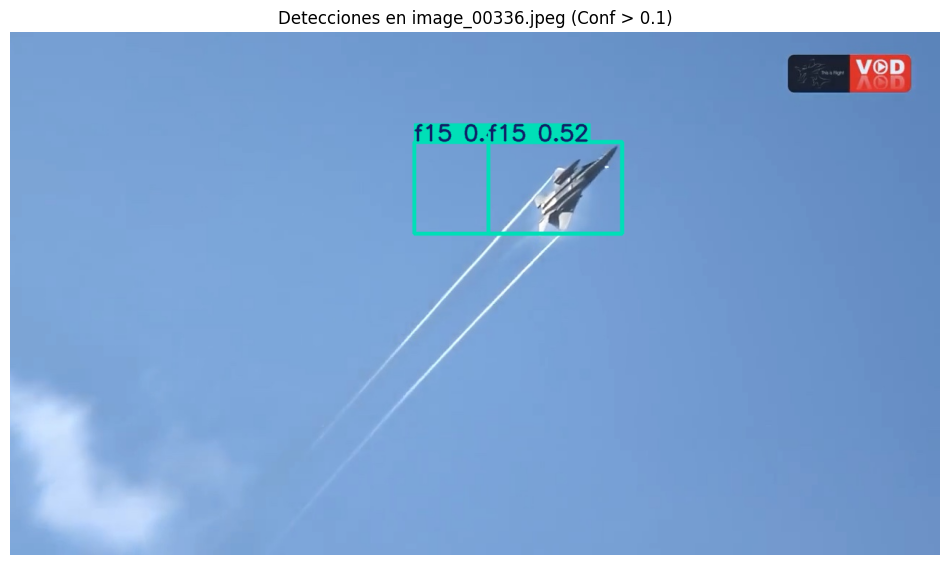

In [25]:
# Cargar el modelo entrenado (usando los mejores pesos)
if os.path.exists(best_model_path):
    model_inference = YOLO(best_model_path)
    print(f"Modelo cargado desde {best_model_path} para inferencia.")

    # --- Opción 1: Detectar en una sola imagen y guardar resultado ---
    new_image_path = './images/image_00336.jpeg' # ¡CAMBIA ESTO A UNA IMAGEN REAL! image_00078.jpeg image_00373.jpeg image_00336.jpeg
    confidence_threshold = 0.1 # Umbral de confianza (ignorar detecciones < 0.5)

    if os.path.exists(new_image_path):
        print(f"\nRealizando inferencia en: {new_image_path}")
        results_inference = model_inference.predict(
            source=new_image_path,
            conf=confidence_threshold,
            save=True, # Guarda la imagen con las detecciones dibujadas
            save_txt=True, # Guarda las detecciones en un archivo .txt
            project=project_name, # Guarda en la misma carpeta de proyecto
            name='inference_results', # Subcarpeta para inferencia
            exist_ok=True
        )
        print(f"Inferencia completada. Resultados guardados.")
        # La imagen con detecciones estará en project_name/inference_results/

        # --- Opción 2: Procesar resultados programáticamente ---
        # 'results_inference' es una lista (aunque procesemos una imagen, devuelve lista)
        if results_inference and len(results_inference) > 0:
            result = results_inference[0] # Obtener resultados para la primera (y única) imagen

            # Acceder a las cajas delimitadoras, confianzas y clases
            boxes = result.boxes  # Objeto Boxes
            if boxes is not None and len(boxes) > 0:
                print(f"\nSe detectaron {len(boxes)} objetos:")
                img_display = result.plot(conf=True, labels=True) # Obtiene la imagen con dibujos (NumPy array BGR)

                for i in range(len(boxes)):
                    box = boxes[i]
                    xyxy = box.xyxy[0].cpu().numpy() # Coordenadas [xmin, ymin, xmax, ymax]
                    conf = box.conf[0].cpu().numpy()  # Confianza
                    cls_id = int(box.cls[0].cpu().numpy()) # ID de clase
                    class_name = id_to_class[cls_id] # Obtener nombre de clase

                    print(f"  - Clase: {class_name} (ID: {cls_id}), Confianza: {conf:.2f}, Box: {xyxy}")

                # Mostrar la imagen con detecciones usando Matplotlib
                plt.figure(figsize=(12, 10))
                plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
                plt.title(f"Detecciones en {os.path.basename(new_image_path)} (Conf > {confidence_threshold})")
                plt.axis('off')
                plt.show()

            else:
                print("No se detectaron objetos con confianza >", confidence_threshold)
        else:
            print("La inferencia no devolvió resultados.")

    else:
        print(f"Error: La imagen para inferencia no existe: {new_image_path}")

    # --- Opción 3: Inferencia en un directorio de imágenes ---
    # new_images_dir = 'path/to/new_images_folder/'
    # if os.path.isdir(new_images_dir):
    #     results_dir = model_inference.predict(
    #         source=new_images_dir,
    #         conf=confidence_threshold,
    #         save=True, save_txt=True,
    #         project=project_name, name='inference_folder_results', exist_ok=True
    #     )
    #     print(f"Inferencia en directorio completada. Resultados en {project_name}/inference_folder_results")
    # else:
    #      print(f"El directorio {new_images_dir} no existe.")

else:
    print(f"Error: No se encontró el modelo entrenado en {best_model_path}. No se puede hacer inferencia.")

## 6 : Generando archivo submission

In [26]:
# --- 1. Definir Rutas ---
best_model_path = os.path.join(project_name, run_name, 'weights', 'best.pt')
test_csv_path = 'test.csv'
sample_submission_path = 'sample_submission.csv'
output_submission_path = 'submission_Yolo11n.csv' # Nuevo nombre de archivo
test_image_dir = './images/' # ¡¡¡VERIFICA ESTA RUTA!!!

# --- 2. Cargar Modelo y Mapeo de Clases ---
model_loaded = False
mapping_loaded = False

if 'id_to_class' not in locals() or not isinstance(id_to_class, dict):
     print("ERROR CRÍTICO: El diccionario 'id_to_class' no está definido o no es un diccionario.")
     print("Por favor, ejecuta de nuevo la celda del Paso 3 donde se crean los mapeos de clases.")
else:
    mapping_loaded = True
    print("Diccionario 'id_to_class' encontrado.")

if mapping_loaded:
    if not os.path.exists(best_model_path):
        print(f"Error: No se encontró el modelo entrenado en {best_model_path}.")
    else:
        try:
            model_inference = YOLO(best_model_path)
            print(f"Modelo cargado desde {best_model_path} para inferencia.")
            model_loaded = True
        except Exception as e:
            print(f"Error al cargar el modelo desde {best_model_path}: {e}")

# --- 3. Cargar Archivo de Test ---
test_df = None
if model_loaded and mapping_loaded:
    if not os.path.exists(test_csv_path):
        print(f"Error: No se encontró el archivo de test: {test_csv_path}")
    elif not os.path.isdir(test_image_dir):
         print(f"Error: El directorio de imágenes de test no existe: {test_image_dir}")
    else:
        try:
            test_df = pd.read_csv(test_csv_path)
            print(f"Archivo de test cargado: {test_csv_path}. Contiene {len(test_df)} imágenes.")
            if 'filename' not in test_df.columns:
                 print(f"Error: La columna 'filename' no se encuentra en {test_csv_path}.")
                 test_df = None
        except Exception as e:
            print(f"Error al leer {test_csv_path}: {e}")

# --- 4. Realizar Predicciones - Garantizando UNA Fila por Imagen de Test ---
all_final_predictions = [] # Lista para guardar la fila final de cada imagen
confidence_threshold = 0.1 # Umbral inicial

# --- Definir valores por defecto para cuando no hay detección ---
# ¡Ajusta estos valores si el formato de submission requiere algo diferente!
default_class_name = "none"
default_coords = {'xmin': 0, 'ymin': 0, 'xmax': 1, 'ymax': 1}
# ---


if model_loaded and mapping_loaded and test_df is not None:
    print(f"\nIniciando predicciones en {len(test_df)} imágenes (garantizando una fila por imagen)...")

    for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Procesando Imágenes"):
        filename = row['filename']
        current_image_path = os.path.join(test_image_dir, filename)
        processed_successfully = False # Flag para saber si se procesó bien

        # Crear la fila por defecto ahora, la usaremos si algo falla o no hay detección
        default_row_data = {
            'filename': filename,
            'class': default_class_name,
            'xmin': default_coords['xmin'],
            'ymin': default_coords['ymin'],
            'xmax': default_coords['xmax'],
            'ymax': default_coords['ymax']
        }

        if not os.path.exists(current_image_path):
            print(f"  Advertencia: Imagen no encontrada {current_image_path}. Usando fila por defecto.")
            all_final_predictions.append(default_row_data) # Añadir defecto y continuar
            continue

        highest_confidence_for_image = -1.0
        best_prediction_details_final_format = None # Reset para cada imagen

        try:
            results_list = model_inference.predict(
                source=current_image_path,
                conf=confidence_threshold,
                save=False, save_txt=False, verbose=False
            )

            if results_list and len(results_list) > 0:
                result = results_list[0]
                boxes = result.boxes

                if boxes is not None and len(boxes) > 0:
                    # Encontrar la mejor detección
                    for i in range(len(boxes)):
                        box = boxes[i]
                        conf = box.conf[0].cpu().numpy()

                        if conf > highest_confidence_for_image:
                            highest_confidence_for_image = conf
                            cls_id = int(box.cls[0].cpu().numpy())
                            try:
                                class_name = id_to_class[cls_id]
                            except KeyError:
                                class_name = f"ID_{cls_id}"
                            xyxy = box.xyxy[0].cpu().numpy()
                            xmin = int(np.round(xyxy[0]))
                            ymin = int(np.round(xyxy[1]))
                            xmax = int(np.round(xyxy[2]))
                            ymax = int(np.round(xyxy[3]))

                            best_prediction_details_final_format = {
                                'filename': filename, 'class': class_name,
                                'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax
                            }
            # Marcar como procesado exitosamente (incluso si no hubo detecciones)
            processed_successfully = True

            # === INICIO MODIFICACIÓN: Decidir qué fila añadir ===
            if best_prediction_details_final_format is not None:
                # Si encontramos una detección buena, la añadimos
                all_final_predictions.append(best_prediction_details_final_format)
            else:
                # Si NO encontramos ninguna detección, añadimos la fila por defecto
                # (No necesitamos imprimir mensaje aquí, solo añadir la fila)
                all_final_predictions.append(default_row_data)
            # === FIN MODIFICACIÓN ===


        except Exception as e:
            print(f"  Error procesando la imagen {filename}: {e}. Usando fila por defecto.")
            # Si ocurre un error durante predict/procesamiento, añadir fila por defecto
            if not processed_successfully: # Asegurar no añadir dos veces si el error es después de procesar
                 all_final_predictions.append(default_row_data)


    print("\nProcesamiento completado. Se ha generado una fila por cada imagen de test.")
    print(f"Total de filas generadas: {len(all_final_predictions)}")
    if len(all_final_predictions) != len(test_df):
         print(f"¡Advertencia! El número de filas generadas ({len(all_final_predictions)}) no coincide con el número de imágenes de test ({len(test_df)}). Revisa los mensajes de error.")


# --- 5. Crear DataFrame de Submission y Guardar ---
if model_loaded and mapping_loaded and test_df is not None:
    if not all_final_predictions:
        print("\nError Crítico: La lista final de predicciones está vacía, incluso después de intentar añadir filas por defecto.")
        # Crear DataFrame vacío como último recurso
        try:
            sample_df = pd.read_csv(sample_submission_path)
            output_columns = [col for col in sample_df.columns if col.lower() != 'confidence']
            if 'class_id' in output_columns and 'class' not in output_columns:
                 output_columns[output_columns.index('class_id')] = 'class'
            elif 'class_id' in output_columns and 'class' in output_columns:
                 output_columns.remove('class_id')
            submission_df = pd.DataFrame(columns=output_columns)
        except Exception:
            output_columns = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
            submission_df = pd.DataFrame(columns=output_columns)

    else:
        # Crear DataFrame a partir de la lista (ahora tiene una fila por imagen de test)
        submission_df = pd.DataFrame(all_final_predictions)

        # Definir explícitamente las columnas finales y su orden
        output_columns = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

        # Asegurar que el DataFrame solo contenga estas columnas y en este orden
        try:
            # Añadir columnas faltantes si es necesario (por si alguna fila por defecto no las tuviera todas)
            for col in output_columns:
                if col not in submission_df.columns:
                    submission_df[col] = np.nan # O un valor por defecto apropiado
            submission_df = submission_df[output_columns] # Seleccionar y ordenar
            print(f"Asegurando que el DataFrame final contiene solo las columnas: {output_columns}")
        except KeyError as e:
             print(f"Error: Faltan columnas esperadas en las predicciones generadas. Columnas faltantes: {e}")
             submission_df = pd.DataFrame(columns=output_columns) # Crear DF vacío con formato correcto

    # Guardar el DataFrame final
    try:
        submission_df.to_csv(output_submission_path, index=False)
        print(f"\nArchivo de submission final ('{output_submission_path}') guardado exitosamente.")
        print(f"Número total de registros guardados: {len(submission_df)}")
        # Verificar si coincide con el número de imágenes en test.csv
        if test_df is not None and len(submission_df) == len(test_df):
             print("El número de filas coincide con el número de imágenes en test.csv.")
        elif test_df is not None:
             print(f"¡Advertencia! El número de filas ({len(submission_df)}) no coincide con el número de imágenes en test.csv ({len(test_df)}).")

        print("\nPrimeras filas del archivo de submission:")
        print(submission_df.head())
    except Exception as e:
        print(f"\nError al guardar el archivo de submission en {output_submission_path}: {e}")

# ... (rest of the error handling for model/mapping not loaded) ...

Diccionario 'id_to_class' encontrado.
Modelo cargado desde custom_yolo_training\run_1\weights\best.pt para inferencia.
Archivo de test cargado: test.csv. Contiene 63 imágenes.

Iniciando predicciones en 63 imágenes (garantizando una fila por imagen)...


Procesando Imágenes:   0%|          | 0/63 [00:00<?, ?it/s]


Procesamiento completado. Se ha generado una fila por cada imagen de test.
Total de filas generadas: 63
Asegurando que el DataFrame final contiene solo las columnas: ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

Archivo de submission final ('submission_Yolo11n.csv') guardado exitosamente.
Número total de registros guardados: 63
El número de filas coincide con el número de imágenes en test.csv.

Primeras filas del archivo de submission:
           filename    class  xmin  ymin  xmax  ymax
0  image_00219.jpeg  chinook   397     9  1119   563
1  image_00034.jpeg      f16   343   356   993   631
2  image_00265.jpeg     ah64   456   195   747   378
3  image_00042.jpeg      f16   291   299   647   475
4  image_00294.jpeg     ah64   197    28   850   461


## 7 : Mostrar imagenes de test

Archivo de test cargado: test.csv. Contiene 63 imágenes.
Modelo cargado desde custom_yolo_training\run_1\weights\best.pt para inferencia.


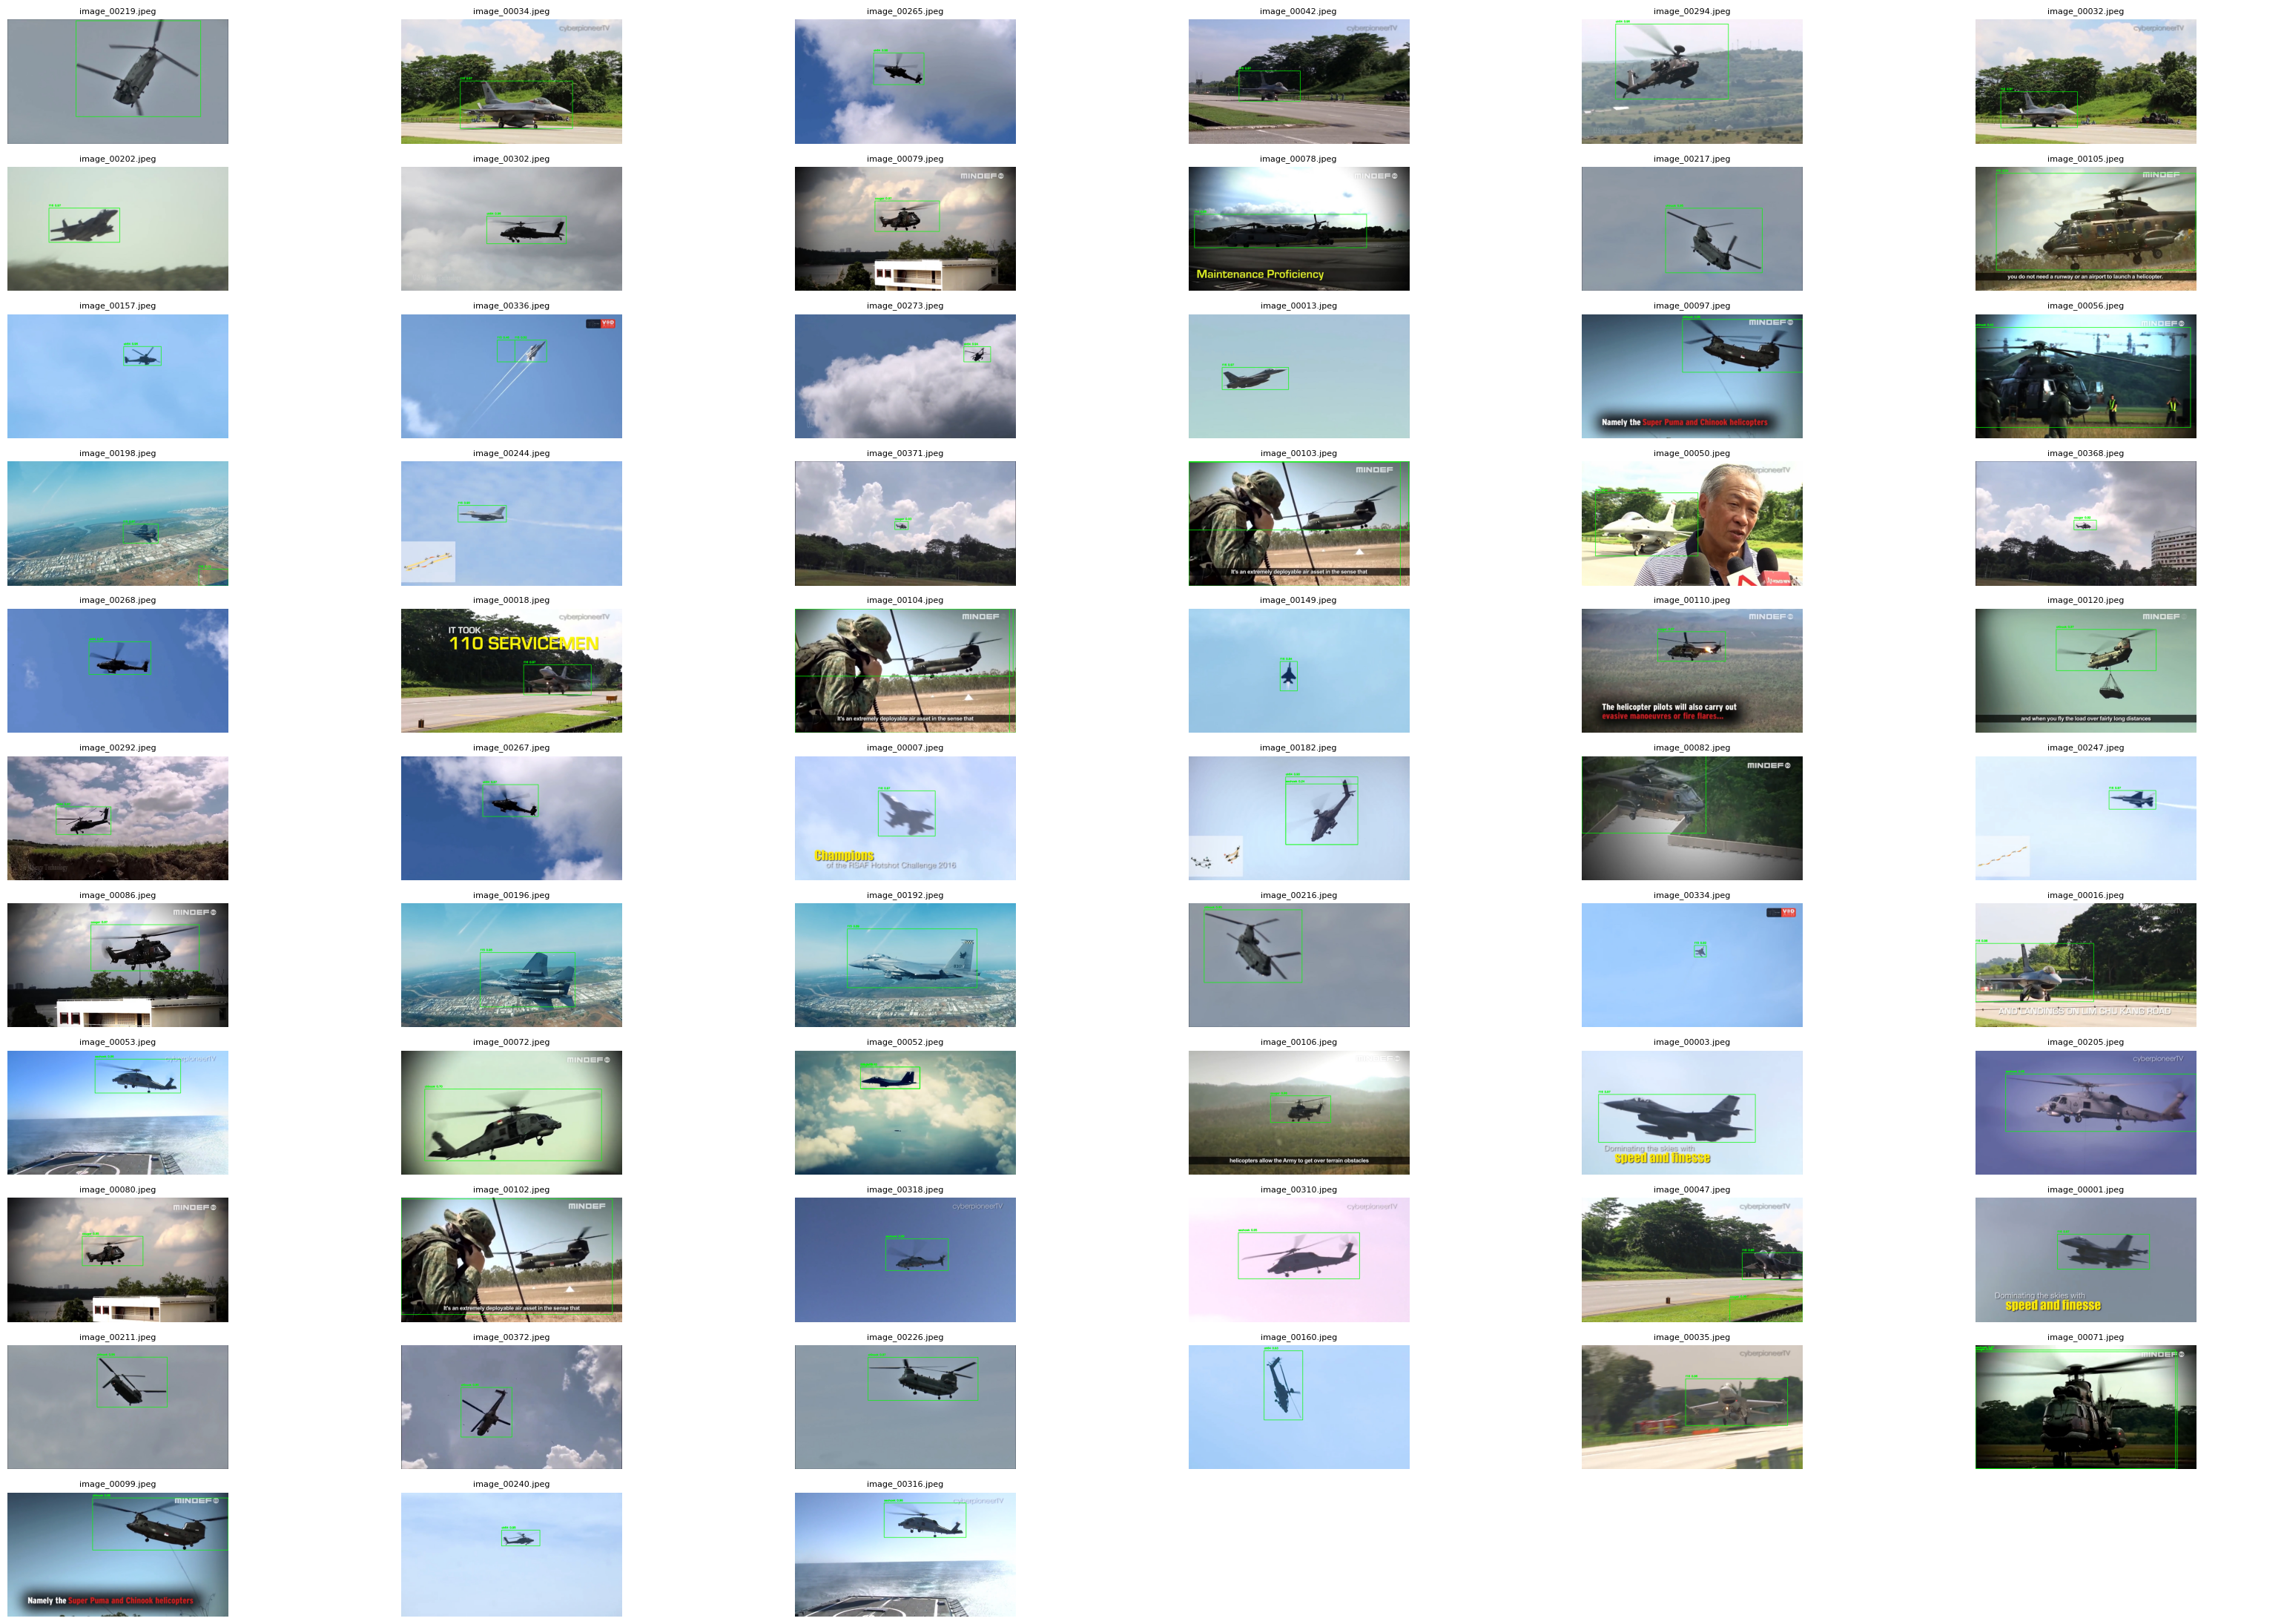

In [27]:
# --- 1. Definir Rutas y Cargar Datos ---
test_csv_path = 'test.csv'
test_image_dir = './images/'
best_model_path = os.path.join(project_name, run_name, 'weights', 'best.pt')  # Asegúrate de que project_name y run_name estén definidos

# Cargar el archivo CSV con la información de las imágenes de prueba
try:
    test_df = pd.read_csv(test_csv_path)
    print(f"Archivo de test cargado: {test_csv_path}. Contiene {len(test_df)} imágenes.")
    if 'filename' not in test_df.columns:
        print(f"Error: La columna 'filename' no se encuentra en {test_csv_path}.")
        test_df = None
except Exception as e:
    print(f"Error al leer {test_csv_path}: {e}")
    test_df = None

# --- 2. Cargar Modelo YOLO ---
try:
    model_inference = YOLO(best_model_path)
    print(f"Modelo cargado desde {best_model_path} para inferencia.")
except Exception as e:
    print(f"Error al cargar el modelo desde {best_model_path}: {e}")
    model_inference = None

# --- 3. Configuración de la Grilla ---
num_cols = 6
num_rows = 11  # Ajustado para mostrar todas las imágenes (63 imágenes)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(32, 22))  # Ajusta el tamaño de la figura
axes = axes.flatten()

flag = True

# --- 4. Iterar sobre las imágenes y mostrarlas con detecciones ---
if test_df is not None and model_inference is not None:
    confidence_threshold = 0.1  # Umbral de confianza para las detecciones

    for i, row in enumerate(test_df.iterrows()):
        index, row_data = row  # Desempaquetar el resultado de enumerate
        filename = row_data['filename']
        image_path = os.path.join(test_image_dir, filename)
        flag = True
        try:
            # Leer la imagen con OpenCV
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"No se pudo leer la imagen en: {image_path}")
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Realizar inferencia con YOLO
            results = model_inference.predict(
                source=image_path,
                conf=confidence_threshold,
                verbose=False  # Suprimir mensajes de inferencia
            )

            # Dibujar bounding boxes en la imagen
            if results and results[0].boxes:
                boxes = results[0].boxes
                for box in boxes:
                    xyxy = box.xyxy[0].cpu().numpy()
                    xmin, ymin, xmax, ymax = map(int, xyxy)
                    class_id = int(box.cls[0].cpu().numpy())
                    confidence = box.conf[0].cpu().numpy()

                    # Obtener el nombre de la clase (si está disponible)
                    try:
                        class_name = id_to_class[class_id]  # Usar el mapeo id_to_class
                    except (NameError, KeyError):
                        class_name = f"Clase {class_id}"  # Si no, usar un nombre genérico

                    # Dibujar el bounding box y la etiqueta
                    cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                    label = f"{class_name} {confidence:.2f}"
                    cv2.putText(img_rgb, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                flag = False
            #     # Si no hay detecciones, mostrar el nombre del archivo en rojo
                print(f"No se detectaron objetos en {filename} con el umbral de confianza actual.")
            #     axes[i].text(0.5, 0.5, filename, ha='center', va='center', color='red', fontsize=10)
            #     axes[i].axis('off')
            #     continue  # Saltar la visualización normal de la imagen

            # Mostrar la imagen en el subplot correspondiente
            axes[i].imshow(img_rgb)
            if flag:              
                axes[i].set_title(filename, fontsize=8)
            else:
                axes[i].set_title(filename, fontsize=8, color='red')
            axes[i].axis('off')

        except Exception as e:
            print(f"Error al procesar {filename}: {e}")
            axes[i].text(0.5, 0.5, filename, ha='center', va='center', color='red', fontsize=10)
            axes[i].axis('off')

    # Ocultar subplots vacíos si hay menos imágenes que subplots
    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se pueden mostrar las imágenes porque no se cargó el archivo test.csv o el modelo YOLO.")